In [1]:
## Catálogo das Abordagens
#  A1: Cadastro
#  A2: Medidas
#      A2.1: Medidas Importantes
#      A2.2: Select KBeast
#  A3: Estatística
#  A4: Doenças
#      A4.1: Select KBest
#  A5: Doenças sem Hipotensão e Normotenso
#  A6: Escolho Doença
#  A7: Categorias
#  A8: Extratificação Sexo Masculino
#  A9: Extratificação Sexo Feminino
#  A10: Sistólicas
#  A11: Diastólicas
#  A12: Medidas Mais Importantes

In [2]:
#bibliotecas pandas de leitura de arquivos
import pandas as pd
#biblioteca do kmeans
from sklearn.cluster import KMeans
import numpy as np
#avaliar classificacao cluster
#from sklearn.metrics.cluster import adjusted_rand_score
#visualizar graficos
import matplotlib.pyplot as plt
#caracter 
import re
#countar os itens de uma lista
from collections import Counter
#separar treino, teste, validação
from sklearn.model_selection import train_test_split
# métricas de avaliação do K-Means
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
# Método Silhouette
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import math
from sklearn import svm

from IPython.display import Image
from pathlib import Path


In [3]:
# Definição de diretórios e Disco de leitura dos arquivos (Desktop ou Notebook) 
config_dirs = open("prefixo_dados.txt").readlines() 
DIR_PREFIXO = Path(config_dirs[0].strip())


DIRETORIO_PRINCIPAL =  DIR_PREFIXO / "Projeto_PA" / "Projeto_PA_validado"
DIR_BASE = DIR_PREFIXO / "Projeto_PA" / "dataset_modificado"
DIR_KMEANS = DIRETORIO_PRINCIPAL / "KMeansRandom"


In [4]:
#leitura do dataset completo com dados cadastrais, medidas e estatísticas

dataset = pd.read_csv(DIR_BASE / "pacientes_completos_tratados.csv",sep=';', encoding="Latin1")
dataset_apos_tratamento = dataset

#dataset = dataset.drop ("Unnamed: 0", axis=1)
#for i in dataset.columns:
#    print(repr(i))
#

In [5]:
############################### FUNÇÕES ##########################################

#Funções para calcular o melhor numero de cluster(grupos) que seu dataset gerar

def calculate_wcss(data):
    """
    Calcula a soma dos quadrados intra-clusters para 19
    quantidades de clusters, iniciando com o mínimo de 2 clusters
    
    Parametros
    ----------
    data : DataFrame
        conjunto de dados para fazer o `.fit()` do KMeans

    
    Returns
    -------
    wcss : lista contendo os valores de soma de quadrados intra-cluster
    """
    from sklearn.cluster import KMeans
    wcss = []
    for n in range(2, 21):
        kmeans = KMeans(n_clusters=n, random_state=10)
        kmeans.fit(X=data)
        wcss.append(kmeans.inertia_)

    return wcss

def optimal_number_of_clusters(wcss):
    """
    Calcula a maior distância entre os pontos que marcam as 
    somas dos quadrados intra-clusters para 19 calculadas 
    com `calculate_wcss()`
    
    Parametros
    ----------
    wcss : lista
        lista contendo os valores de soma de quadrados intra-cluster

    
    Returns
    -------
    int : número de clusters 
    """
    from math import sqrt
    x1, y1 = 2, wcss[0]
    x2, y2 = 20, wcss[len(wcss)-1]

    distances = []
    for i in range(len(wcss)):
        x0 = i+2
        y0 = wcss[i]

        numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)
    return distances.index(max(distances)) + 2

In [6]:
#converter peso em float

#def Tratar_Peso(peso):    
#    
#    try:
#        if peso[-1] == ',' or peso[-1] == '.':
#            peso =  peso[:-1]
#    except:
#        pass
#    
#    
#    try:
#        peso = float(peso)
#    except:
#        peso = float(peso.replace(',','.'))
#    return peso
#
##converter altura
#def Tratar_Altura(altura):       
#       
#    altura = str(altura)
#    if re.match('\d,,\d', altura):
#        altura = altura.replace(',,','')
#    
#    try:
#        if altura[-1] == ',' or altura[-1] == '.' or  altura[-1] == ']':
#            altura =  altura[:-1]
#    except:
#        pass
#    
#    try:
#        altura = float(altura)
#    except:
#        altura = float(altura.replace(',','.'))     
#    
#    # convt 150.00 para 1.50
#    if altura >= 3:
#        altura = altura/100 
#    
#    
#    return altura
#
##calcular o IMC
#def IMC(peso,altura):  
#        
#    imc = float(peso) / (float(altura) ** 2)
#    
#    return np.round (imc, 1)
#
#
##Trocar  True para 1 e False para 0
def verdadeiro_falso(valor):
    if valor == True:
        return 1
    else:
        return 0
#
#def normaliza_float(n):
#    if isinstance(n, (float, int)):
#        return n
#    if isinstance(n, str):
#        if "," in n:
#            n = n.replace(",", ".")
#        if not n.replace(".", "").isdigit():
#            n = "".join(digito for digito in n if digito in "0123456789.")
#        n = n.replace("..", ".")
#        if not n or n.count(".") > 1:
#            n = float("nan")
#         # convt 150.00 para 1.50
#        n = float(n)
#        if n >= 3:
#            while 1:
#                if (n//10 == 0.0 or n//10 == 0):
#                    break
#                else:
#                    n = n/10 
#    return float(n)

In [7]:
dataset_apos_tratamento['IMC']

0        33.2
1        29.4
2        25.8
3        24.2
4        40.6
         ... 
19237    27.5
19238    26.9
19239    33.3
19240    25.0
19241    30.9
Name: IMC, Length: 19242, dtype: float64

In [8]:
# transform Gender M and F to binary 

#limpa_coluna_genero = {"genero": {"M": True, "F": False}}
#controle = 1
#genero0 = dataset['genero']
#for i in range(len(genero0)):
#    if genero0.iloc[i] != 'M' and genero0.iloc[i] != 'F':
#        if controle == 1:
#            genero0.iloc[i] = 0
#            controle = 0
#        else:
#            genero0.iloc[i] = 1
#            controle = 1
#
#dataset_apos_tratamento['genero'] = genero0
#
#dataset_apos_tratamento = dataset_apos_tratamento.replace(limpa_coluna_genero)
#
#dataset_apos_tratamento["genero"] = dataset_apos_tratamento["genero"].astype(int)
##
##
#
genero_M_F = {"genero": {1: "M", 0: "F"}}

##  Tratar os dados para colocá-los em Categorias

In [9]:
# Cálculo do Indice de Massa Corporal:
#         IMC entre 18,0 e 24,9 Kg/m2: normal
#         IMC menor do que 18,0 Kg/m2: baixo peso
#         IMC entre 25,0 e 29,9 Kg/m2: sobrepeso 
#         IMC entre 30,0 e 34,9 Kg/m2: obesidade grau I 
#         IMC entre 35,0 e 39,9 Kg/m2: obesidade grau II 
#         IMC maior do que 40,0 Kg/m2: obesidade grau III  

def faixas_imc(imc):
    classes = ["baixo peso","normal","sobrepeso",
               "obesidade grau I","obesidade grau II","obesidade Grau III"]
    intervalos = [(0, 18),(18, 25),(25, 30),(30, 35),(35, 40),(40, 1000)]
    
    for faixa in range(len(classes)):
        if imc < intervalos[faixa][1]:
            return classes[faixa]
        
def faixas_imc_classe(imc):
    classes = [1, 2, 3, 4, 5, 6]
    
    intervalos = [(0, 18),(18, 25),(25, 30),(30, 35),(35, 40),(40, 1000)]
    
    for faixa in range(len(classes)):
        if imc < intervalos[faixa][1]:
            return classes[faixa]
    
def faixas_etarias(idade):
    classes = ["Jovens","Adultos","Meia-idade","Idoso", "Ancião","Velhice extrema"]
    intervalos = [(0, 20),(20, 45),(45, 60),(60, 75),(75, 90),(90, 200)]
    
    for faixa in range(len(classes)):
        if idade <= intervalos[faixa][1]:
            return classes[faixa]

def faixas_etarias_classe(idade):
    classes = [1, 2, 3, 4, 5, 6]
    intervalos = [(0, 20),(20, 45),(45, 60),(60, 75),(75, 90),(90, 200)]
    
    for faixa in range(len(classes)):
        if idade <= intervalos[faixa][1]:
            return classes[faixa]

In [10]:
#dataset_apos_tratamento['idade'] = dataset_apos_tratamento['idade'].fillna(-1)
#dataset_apos_tratamento = dataset_apos_tratamento[dataset_apos_tratamento['idade'] != -1]

In [11]:
#dataset_apos_tratamento = dataset_apos_tratamento[dataset_apos_tratamento['altura_normalizada'] <= 2.5]
#dataset_apos_tratamento = pd.concat([dataset_apos_tratamento.loc[:,'numero_identificacao':'altura'],
#                                     dataset_apos_tratamento['IMC'],
#                                    dataset_apos_tratamento.loc[:,'data_exame':'Picos Diastolica']],
#                                    axis=1)
#
#print(len(dataset_apos_tratamento))
## Dataset com IMC e tratamento de Nans com a política de normalização
#dataset_apos_tratamento.to_csv(DIR_BASE / "pacientes_completos_tratados.csv", 
#                        sep=";", encoding="latin1", index=False)
#
#dataset_apos_tratamento.to_csv(DIR_BASE / "pacientes_com_tab.csv", 
#                        sep="\t", encoding="latin1", index=False)

In [12]:
dataset_apos_tratamento.loc[:,'Hipotensao':'Whitecoat']

Hipotensao  Sistolica Isolada  Diastolica Isolada  Dipping  \
0            True              False               False    False   
1            True              False               False    False   
2            True              False               False    False   
3            True              False               False     True   
4            True              False               False     True   
...           ...                ...                 ...      ...   
19237        True              False               False     True   
19238        True              False               False    False   
19239        True              False               False    False   
19240        True              False               False    False   
19241        True              False               False    False   

       Non Dipping  Extreme Dipping  Reverse Dipping  Morning Surge  Masked  \
0            False            False             True          False   False   
1            False            False             True          False   False   
2             True            False            False          False   False   
3            False            False            False          False   False   
4            False            False            False          False   False   
...            ...              ...              ...            ...     ...   
19237        False            False            False           True   False   
19238         True            False            False          False   False   
19239         True            False            False          False   False   
19240        False             True            False          False   False   
19241        False            False             True          False   False   

       Whitecoat  
0          False  
1          False  
2           True  
3           True  
4          False  
...          ...  
19237       True  
19238       True  
19239       True  
19240      False  
19241       True  

[19242 rows x 10 columns]

In [13]:
def verdadeiro_falso(valor):
    if valor == True:
        return 1
    else:
        return 0

In [14]:
dataset_por_classes = pd.DataFrame()
dataset_por_classes['numero_identificacao'] = dataset_apos_tratamento['numero_identificacao']
dataset_por_classes['genero'] = dataset_apos_tratamento['genero']
dataset_por_classes['idade'] = dataset_apos_tratamento['idade'].apply(faixas_etarias_classe)
dataset_por_classes['IMC'] = dataset_apos_tratamento['IMC'].apply(faixas_imc_classe)
dataset_por_classes = pd.concat([dataset_por_classes, dataset_apos_tratamento.loc[:,'sist 9:00':'diast 8:45']],axis=1)
for doenca in list(dataset_apos_tratamento.loc[:,'Hipotensao':'Whitecoat'].columns):
    dataset_por_classes[doenca] = dataset_apos_tratamento[doenca].apply(verdadeiro_falso)
dataset_por_classes

numero_identificacao  genero  idade  IMC  sist 9:00  sist 9:15  \
0                         4       1      6    4      105.0      108.0   
1                         5       1      4    3      103.0      114.0   
2                         6       1      1    3      147.0      148.0   
3                         7       0      2    2      140.0      139.0   
4                         8       1      2    6      113.0      110.0   
...                     ...     ...    ...  ...        ...        ...   
19237                 21786       1      3    3      163.0      198.0   
19238                 21787       1      3    3      114.0      120.0   
19239                 21788       0      2    4      107.0      110.0   
19240                 21792       0      4    3       94.0      107.0   
19241                 21793       1      3    4      111.0      104.0   

       sist 9:30  sist 9:45  sist 10:00  sist 10:15  ...  Hipotensao  \
0          116.0      104.0       106.0        98.0  ...           1   
1           82.0      104.0        98.0       106.0  ...           1   
2          156.0      140.0       130.0       132.0  ...           1   
3          142.0      137.0       135.0       177.0  ...           1   
4          101.0      108.0       111.0       111.0  ...           1   
...          ...        ...         ...         ...  ...         ...   
19237      172.0      148.0       161.0       156.0  ...           1   
19238      164.0      116.0       119.0       126.0  ...           1   
19239      103.0      105.0       108.0       111.0  ...           1   
19240      112.0      124.0       120.0        94.0  ...           1   
19241      103.0      101.0        97.0       110.0  ...           1   

       Sistolica Isolada  Diastolica Isolada  Dipping  Non Dipping  \
0                      0                   0        0            0   
1                      0                   0        0            0   
2                      0                   0        0            1   
3                      0                   0        1            0   
4                      0                   0        1            0   
...                  ...                 ...      ...          ...   
19237                  0                   0        1            0   
19238                  0                   0        0            1   
19239                  0                   0        0            1   
19240                  0                   0        0            0   
19241                  0                   0        0            0   

       Extreme Dipping  Reverse Dipping  Morning Surge  Masked  Whitecoat  
0                    0                1              0       0          0  
1                    0                1              0       0          0  
2                    0                0              0       0          1  
3                    0                0              0       0          1  
4                    0                0              0       0          0  
...                ...              ...            ...     ...        ...  
19237                0                0              1       0          1  
19238                0                0              0       0          1  
19239                0                0              0       0          1  
19240                1                0              0       0          0  
19241                0                1              0       0          1  

[19242 rows x 178 columns]

In [15]:
dataset_apos_tratamento['IMC'].unique

<bound method Series.unique of 0        33.2
1        29.4
2        25.8
3        24.2
4        40.6
         ... 
19237    27.5
19238    26.9
19239    33.3
19240    25.0
19241    30.9
Name: IMC, Length: 19242, dtype: float64>

In [16]:
dataset_apos_tratamento

numero_identificacao data_nascimento  genero  idade   peso altura  \
0                         4      1923-10-05       1   94.0   85.0    160   
1                         5      1948-10-07       1   70.0   80.0    165   
2                         6      1999-03-23       1   19.0  100.0    197   
3                         7      1978-01-26       0   40.0   65.0   1,64   
4                         8      1990-03-07       1   28.0  120.0    172   
...                     ...             ...     ...    ...    ...    ...   
19237                 21786      1972-11-25       1   47.0   75.0    165   
19238                 21787      1970-10-19       1   49.0   90.0    183   
19239                 21788      1985-03-15       0   35.0   93.0    167   
19240                 21792      1952-04-21       0   68.0   64.0    160   
19241                 21793      1971-01-14       1   49.0   99.0    179   

        IMC           data_exame  sist 9:00  sist 9:15  ...  \
0      33.2  2018-09-10 12:25:23      105.0      108.0  ...   
1      29.4  2018-12-26 07:39:41      103.0      114.0  ...   
2      25.8  2018-12-26 08:06:19      147.0      148.0  ...   
3      24.2  2018-12-26 08:19:06      140.0      139.0  ...   
4      40.6  2018-12-26 08:26:59      113.0      110.0  ...   
...     ...                  ...        ...        ...  ...   
19237  27.5  2020-09-10 16:03:08      163.0      198.0  ...   
19238  26.9  2020-09-10 16:21:02      114.0      120.0  ...   
19239  33.3  2020-09-10 16:44:53      107.0      110.0  ...   
19240  25.0  2020-09-10 17:25:50       94.0      107.0  ...   
19241  30.9  2020-09-10 17:42:01      111.0      104.0  ...   

       Mediana Diastolica em 24h  AUC Sistolica em 24h  AUC Diastolica em 24h  \
0                           59.0                9545.5                 4902.0   
1                           62.0                8586.5                 5034.5   
2                           79.0               10674.0                 6154.0   
3                           80.0               10679.5                 6420.5   
4                           78.0                9141.5                 6118.0   
...                          ...                   ...                    ...   
19237                      116.0               12224.5                 9265.0   
19238                       85.0               10970.0                 6819.0   
19239                       62.0                9245.0                 4935.5   
19240                       68.0                8989.5                 5660.0   
19241                       86.0                9812.0                 6746.5   

       AUC PP Daytime  AUC PP Nighttime  DP Sistolica em 24h  \
0              3748.0             841.5                16.52   
1              2915.0             606.0                 7.51   
2              3721.0             751.5                12.70   
3              3642.0             602.5                16.13   
4              2405.0             566.0                12.27   
...               ...               ...                  ...   
19237          2439.0             474.5                18.66   
19238          3319.0             738.0                17.22   
19239          3556.0             713.5                14.36   
19240          2815.5             460.0                14.14   
19241          2400.5             612.0                13.92   

       DP Diastolica em 24h  Diferenca % Dipping  Picos Sistolica  \
0                     11.36                0.966               11   
1                      6.65                0.969                9   
2                     13.01                1.056               19   
3                     10.34                1.107               21   
4                     12.79                1.137               10   
...                     ...                  ...              ...   
19237                 14.80                1.134               49   
19238                 13.67                

In [17]:
# Dataset com cadastro, IMC e medidas
dataset_cadastro = pd.concat([dataset_apos_tratamento['numero_identificacao'],
                             dataset_apos_tratamento['genero'],dataset_apos_tratamento['idade'],
                             dataset_apos_tratamento['IMC'],
                     dataset_apos_tratamento.loc[:,'sist 9:00':'diast 8:45']],axis=1)

# Dataset com as medidas
dataset_medidas = pd.concat([dataset_apos_tratamento['numero_identificacao'],
                     dataset_apos_tratamento.loc[:,'sist 9:00':'diast 8:45']],axis=1)

# Dataset com numero identificação e estatísticas
dataset_estatistica = pd.concat([dataset_apos_tratamento['numero_identificacao'],
                     dataset_apos_tratamento.loc[:,'Media Sistolica em 24h':'DP Diastolica em 24h']],axis=1)

# Dataset com numero identificação e doenças
dataset_doenca = pd.concat([dataset_apos_tratamento['numero_identificacao'],
                     dataset_apos_tratamento.loc[:,'Hipotensao':'Normotenso']],axis=1)

dataset_masc = dataset_apos_tratamento[dataset_apos_tratamento['genero'] == 1]

dataset_masc_medidas =  pd.concat([dataset_masc['numero_identificacao'],
                     dataset_masc.loc[:,'sist 9:00':'diast 8:45']],axis=1)


dataset_fem = dataset_apos_tratamento[dataset_apos_tratamento['genero'] == 0]

dataset_fem_medidas =  pd.concat([dataset_fem['numero_identificacao'],
                     dataset_fem.loc[:,'sist 9:00':'diast 8:45']],axis=1)

In [18]:
print(f'Quantidade F: {len(dataset_fem_medidas)}\nQuantidade M: {len(dataset_masc_medidas)}')

Quantidade F: 10482
Quantidade M: 8760


# Abordagem 1: Cadastro e Medidas como entrada

In [19]:
dataset_cadastro

numero_identificacao  genero  idade   IMC  sist 9:00  sist 9:15  \
0                         4       1   94.0  33.2      105.0      108.0   
1                         5       1   70.0  29.4      103.0      114.0   
2                         6       1   19.0  25.8      147.0      148.0   
3                         7       0   40.0  24.2      140.0      139.0   
4                         8       1   28.0  40.6      113.0      110.0   
...                     ...     ...    ...   ...        ...        ...   
19237                 21786       1   47.0  27.5      163.0      198.0   
19238                 21787       1   49.0  26.9      114.0      120.0   
19239                 21788       0   35.0  33.3      107.0      110.0   
19240                 21792       0   68.0  25.0       94.0      107.0   
19241                 21793       1   49.0  30.9      111.0      104.0   

       sist 9:30  sist 9:45  sist 10:00  sist 10:15  ...  diast 6:30  \
0          116.0      104.0       106.0        98.0  ...        41.0   
1           82.0      104.0        98.0       106.0  ...        74.0   
2          156.0      140.0       130.0       132.0  ...        80.0   
3          142.0      137.0       135.0       177.0  ...        49.0   
4          101.0      108.0       111.0       111.0  ...        64.0   
...          ...        ...         ...         ...  ...         ...   
19237      172.0      148.0       161.0       156.0  ...       102.0   
19238      164.0      116.0       119.0       126.0  ...        87.0   
19239      103.0      105.0       108.0       111.0  ...        49.0   
19240      112.0      124.0       120.0        94.0  ...        63.0   
19241      103.0      101.0        97.0       110.0  ...        67.0   

       diast 6:45  diast 7:00  diast 7:15  diast 7:30  diast 7:45  diast 8:00  \
0            46.0        51.0        56.0        61.0        67.0        61.0   
1            74.0        74.0        70.0        67.0        63.0        60.0   
2            86.0        93.0        91.0        89.0        87.0        86.0   
3            56.0        62.0        83.0       104.0        99.0        94.0   
4            73.0        83.0        93.0        68.0        91.0        87.0   
...           ...         ...         ...         ...         ...         ...   
19237       114.0       126.0       125.0       124.0       123.0       123.0   
19238        73.0        59.0        74.0        68.0        86.0        96.0   
19239        50.0        50.0        53.0        52.0        62.0        68.0   
19240        63.0        64.0        76.0        72.0        69.0        75.0   
19241        68.0        69.0        71.0        73.0        56.0        57.0   

       diast 8:15  diast 8:30  diast 8:45  
0            69.0        62.0        51.0  
1            74.0        70.0        67.0  
2            87.0        82.0        82.0  
3            89.0        90.0        72.0  
4            84.0        81.0        72.0  
...           ...         ...         ...  
19237       121.0       119.0       123.0  
19238       107.0       106.0        93.0  
19239        61.0        64.0        60.0  
19240        74.0        69.0        67.0  
19241        65.0        68.0        82.0  

[19242 rows x 168 columns]

In [20]:
#selecionando variaveis de medidad : sist 9:00 a diast 8:45
#campos sist e diast

#   Gera uma lista com cabeçalhos
ls_cadastro = list(dataset_cadastro.loc[:,'genero':'diast 8:45'].columns)

dados_cadastro_sem_id = dataset_cadastro.loc[:,'genero':'diast 8:45']
#dados_sist_diast = dados_sist_diast.drop(['peso','altura','data_exame'],axis=1)

dados_cadastro_sem_id.head(5)

genero  idade   IMC  sist 9:00  sist 9:15  sist 9:30  sist 9:45  \
0       1   94.0  33.2      105.0      108.0      116.0      104.0   
1       1   70.0  29.4      103.0      114.0       82.0      104.0   
2       1   19.0  25.8      147.0      148.0      156.0      140.0   
3       0   40.0  24.2      140.0      139.0      142.0      137.0   
4       1   28.0  40.6      113.0      110.0      101.0      108.0   

   sist 10:00  sist 10:15  sist 10:30  ...  diast 6:30  diast 6:45  \
0       106.0        98.0       102.0  ...        41.0        46.0   
1        98.0       106.0       108.0  ...        74.0        74.0   
2       130.0       132.0       121.0  ...        80.0        86.0   
3       135.0       177.0       148.0  ...        49.0        56.0   
4       111.0       111.0       114.0  ...        64.0        73.0   

   diast 7:00  diast 7:15  diast 7:30  diast 7:45  diast 8:00  diast 8:15  \
0        51.0        56.0        61.0        67.0        61.0        69.0   
1        74.0        70.0        67.0        63.0        60.0        74.0   
2        93.0        91.0        89.0        87.0        86.0        87.0   
3        62.0        83.0       104.0        99.0        94.0        89.0   
4        83.0        93.0        68.0        91.0        87.0        84.0   

   diast 8:30  diast 8:45  
0        62.0        51.0  
1        70.0        67.0  
2        82.0        82.0  
3        90.0        72.0  
4        81.0        72.0  

[5 rows x 167 columns]

## Trata nulos, quando houver

In [21]:
#  ****** trocar a variável de dados_cadastro_sem_id  para  dados_cadastro_sem_nan

#dados_medidas_sem_nan = dados_medidas.fillna(0)

#  Retirar a linha que contém NaN em alguma coluna 
# dados_cadastro_sem_nan = dados_cadastro
# ls_cadastro = list(dados_cadastro_sem_nan.columns)

## Abordagem 1: Número de Clusters gerado pelo k-Means

In [22]:
#calculando a quantidade ótima de clusters (é possivel dividir os pacientes em quantos grupos)
sum_of_squares_cadastro = calculate_wcss(dados_cadastro_sem_id)
num_otimo_clusters_cadastro = optimal_number_of_clusters(sum_of_squares_cadastro)
num_otimo_clusters_cadastro

7

In [23]:
#convertendo os dados para a clusterização
dados_cadastro_array = np.array(dados_cadastro_sem_id)

In [24]:
#habilitando o kmeans com 8 grupos (foi calculado na etapa anterior)
kmeans_cadastro = KMeans(n_clusters=num_otimo_clusters_cadastro, random_state=42).fit(dados_cadastro_array)

In [25]:
#listar os grupos 
grupos_cadastro = kmeans_cadastro.fit_predict(dados_cadastro_array)

In [26]:
#incluir grupos nos dados de sist e diast
dados_cadastro_sem_id['grupo'] = grupos_cadastro
dados_cadastro_sem_id['grupo'] = dados_cadastro_sem_id['grupo'] + 1
dados_cadastro_sem_id


genero  idade   IMC  sist 9:00  sist 9:15  sist 9:30  sist 9:45  \
0           1   94.0  33.2      105.0      108.0      116.0      104.0   
1           1   70.0  29.4      103.0      114.0       82.0      104.0   
2           1   19.0  25.8      147.0      148.0      156.0      140.0   
3           0   40.0  24.2      140.0      139.0      142.0      137.0   
4           1   28.0  40.6      113.0      110.0      101.0      108.0   
...       ...    ...   ...        ...        ...        ...        ...   
19237       1   47.0  27.5      163.0      198.0      172.0      148.0   
19238       1   49.0  26.9      114.0      120.0      164.0      116.0   
19239       0   35.0  33.3      107.0      110.0      103.0      105.0   
19240       0   68.0  25.0       94.0      107.0      112.0      124.0   
19241       1   49.0  30.9      111.0      104.0      103.0      101.0   

       sist 10:00  sist 10:15  sist 10:30  ...  diast 6:45  diast 7:00  \
0           106.0        98.0       102.0  ...        46.0        51.0   
1            98.0       106.0       108.0  ...        74.0        74.0   
2           130.0       132.0       121.0  ...        86.0        93.0   
3           135.0       177.0       148.0  ...        56.0        62.0   
4           111.0       111.0       114.0  ...        73.0        83.0   
...           ...         ...         ...  ...         ...         ...   
19237       161.0       156.0       156.0  ...       114.0       126.0   
19238       119.0       126.0       123.0  ...        73.0        59.0   
19239       108.0       111.0       114.0  ...        50.0        50.0   
19240       120.0        94.0       102.0  ...        63.0        64.0   
19241        97.0       110.0       111.0  ...        68.0        69.0   

       diast 7:15  diast 7:30  diast 7:45  diast 8:00  diast 8:15  diast 8:30  \
0            56.0        61.0        67.0        61.0        69.0        62.0   
1            70.0        67.0        63.0        60.0        74.0        70.0   
2            91.0        89.0        87.0        86.0        87.0        82.0   
3            83.0       104.0        99.0        94.0        89.0        90.0   
4            93.0        68.0        91.0        87.0        84.0        81.0   
...           ...         ...         ...         ...         ...         ...   
19237       125.0       124.0       123.0       123.0       121.0       119.0   
19238        74.0        68.0        86.0        96.0       107.0       106.0   
19239        53.0        52.0        62.0        68.0        61.0        64.0   
19240        76.0        72.0        69.0        75.0        74.0        69.0   
19241        71.0        73.0        56.0        57.0        65.0        68.0   

       diast 8:45  grupo  
0            51.0      6  
1            67.0      5  
2            82.0      1  
3            72.0      1  
4            72.0      2  
...           ...    ...  
19237       123.0      3  
19238        93.0      4  
19239        60.0      5  
19240        67.0      2  
19241        82.0      7  

[19242 rows x 168 columns]

## Abordagem 1: O método Elbow

### Esse método para calcular o melhor número de cluster para o algoritmo e mostar o gráfico

### https://minerandodados.com.br/algoritmo-k-means-python-passo-passo/#:~:text=O%20m%C3%A9todo%20Elbow%20se%20trata,um%20valor%20significativo%20de%20ganho.

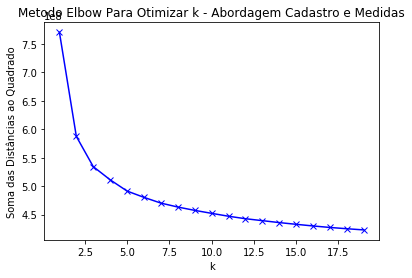

Wall time: 80.4 ms


In [27]:
#metodo de Elbow
Sum_of_squared_distances = []
K = range(1,20)

for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(dados_cadastro_array)
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Soma das Distâncias ao Quadrado')
plt.title('Metodo Elbow Para Otimizar k - Abordagem Cadastro e Medidas')
fig = plt.gcf() 
fig.savefig( DIR_KMEANS / 'graficos' / f'metodoelbow_cadastro.svg', format="svg")
%time plt.show()

In [28]:
#fig.savefig('D:\Projeto_PA\\Projeto_PA_validado\\KMeansRandom\\graficos\\grafico_metodoelbow_medidas.svg', format='svg')
#plt.savefig(DIR_NMF / f'NMF_classificado_{grupo}.svg',format="svg")
#fig.savefig('diastolica_sistolica/diast_sist_elbow.png', format='png')


## Abordagem 1: Silhouette

####  A análise da Silhouette pode ser usada para determinar o grau de separação entre os clusters. O coeficiente de Silhouette quando próximo de +1, indica que os pontos estão muito longe dos pontos do outro cluster, e quando próximo de 0, indica que os pontos então muito perto ou até interseccionando um outro cluster



Para n_clusters = 2 O score_silhouette medio e : 0.2045786679636461
Para n_clusters = 3 O score_silhouette medio e : 0.12716390317272128
Para n_clusters = 4 O score_silhouette medio e : 0.0822771317882518
Para n_clusters = 5 O score_silhouette medio e : 0.07794982083882049
Para n_clusters = 6 O score_silhouette medio e : 0.06117490845408647
Para n_clusters = 7 O score_silhouette medio e : 0.0581404675532212
Para n_clusters = 8 O score_silhouette medio e : 0.05513256405387636


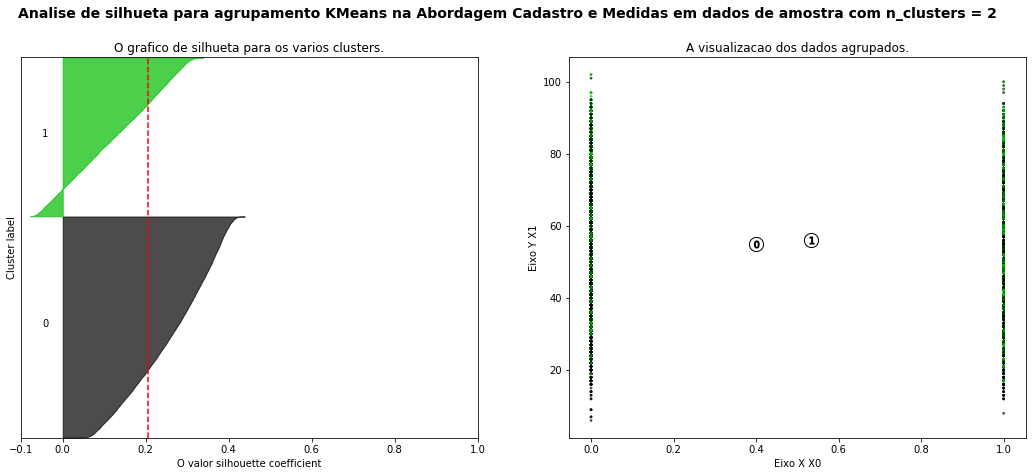

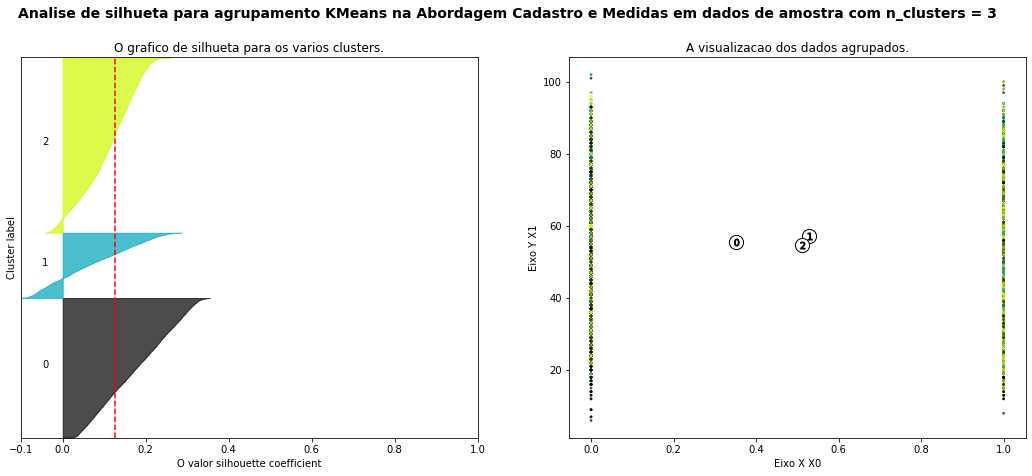

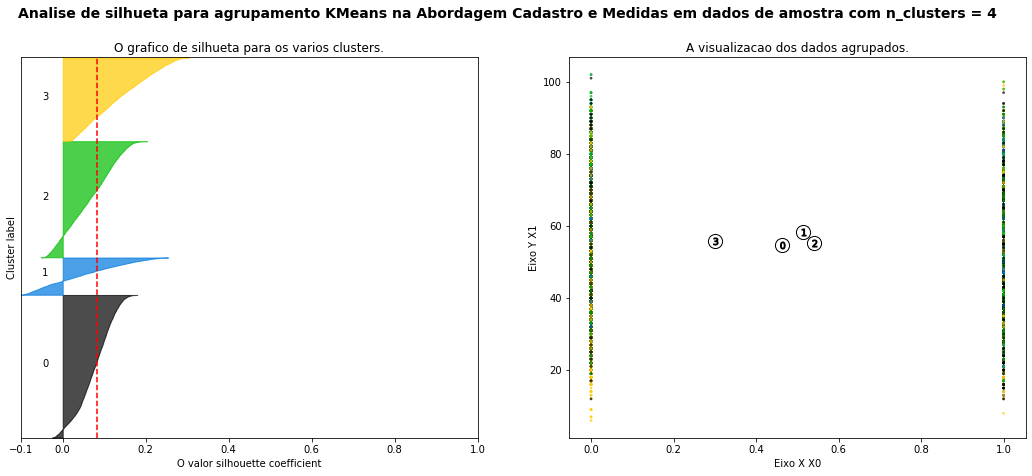

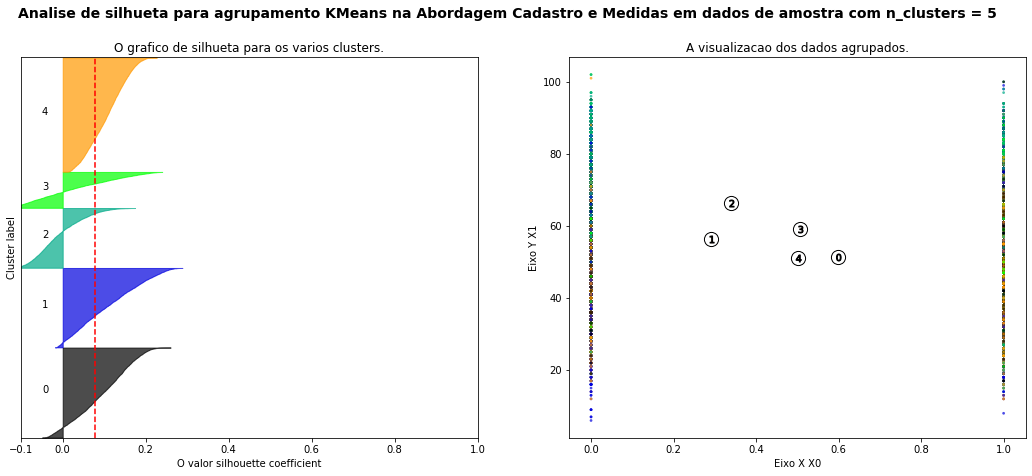

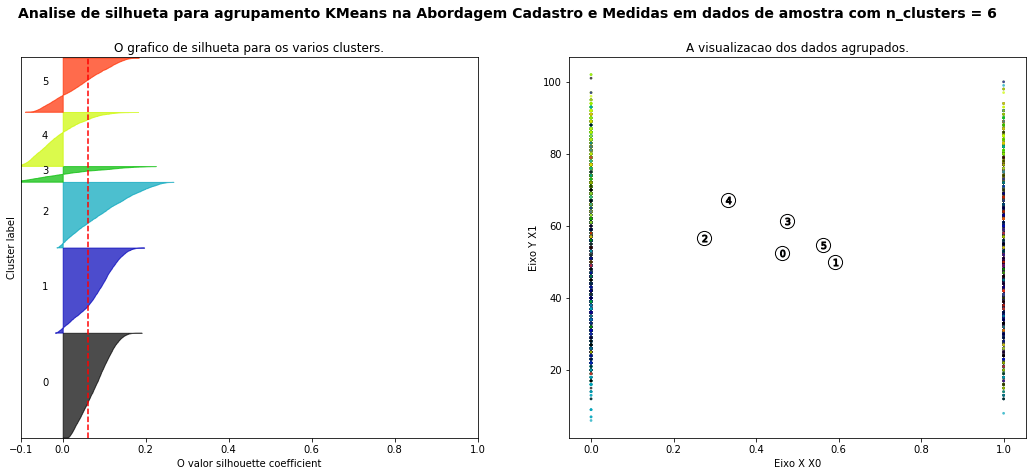

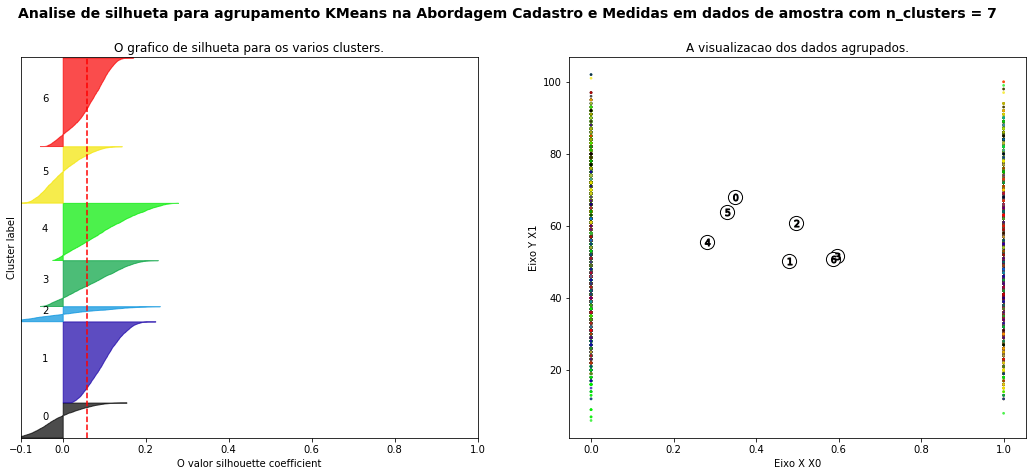

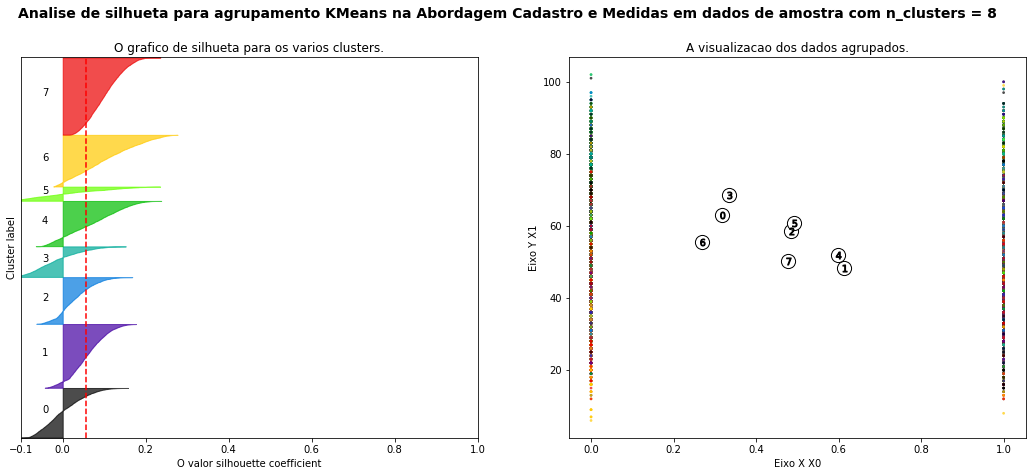

In [29]:
#Silhouette
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for n_clusters in range_n_clusters:    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    # O 1st subplot é o grafico silhouette
    # O coeficiente silhouette  um range de -1, 1 but in this example all
    # Os exemplos vão ficar em [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # O (n_clusters + 1) * 10 é para inserir um espaço em branco entre a silhueta
    # Para gerar destaque
    ax1.set_ylim([0, len(dados_cadastro_array) + (n_clusters + 1) * 10])
    # Inicialize o clusterer com o valor n_clusters e um valor aleatorio
    # seed 10.
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(dados_cadastro_array)
# O silhouette_score fornece o valor médio para todas as amostras.
    # Isso dá uma perspectiva sobre a densidade e separação das formas
    # clusters
    #  Cálculo de toda a matriz que entra no cálculo do Silhouette
    silhouette_avg = silhouette_score(dados_cadastro_array, cluster_labels)
    print("Para n_clusters =", n_clusters,
          "O score_silhouette medio e :", silhouette_avg)
    # Calcule as pontuações da silhueta para cada amostra
    sample_silhouette_values = silhouette_samples(dados_cadastro_array, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        # Agregue as pontuações de silhueta para amostras pertencentes a
        # cluster i, e classifica-los
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color,       alpha=0.7)
        # Rotule os gráficos de silhueta com seus números de cluster no meio
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        # Calcule o novo y_lower para o próximo gráfico
        y_lower = y_upper + 10  #10 para as 0 amostras
    ax1.set_title("O grafico de silhueta para os varios clusters.")
    ax1.set_xlabel("O valor silhouette coefficient")
    ax1.set_ylabel("Cluster label")
    # A linha vertical para a pontuação média da silhueta de todos os valores
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])  # Limpar os yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    # 2º gráfico mostrando os clusters reais formados
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(dados_cadastro_array[:, 0], dados_cadastro_array[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
    # Labeling dos clusters
    centers = clusterer.cluster_centers_
    # Desenhe círculos brancos nos centros do cluster
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')
    ax2.set_title("A visualizacao dos dados agrupados.")
    ax2.set_xlabel("Eixo X X0")
    ax2.set_ylabel("Eixo Y X1")
    plt.suptitle(("Analise de silhueta para agrupamento KMeans na Abordagem Cadastro e Medidas em dados de amostra "
                  "com n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    fig = plt.gcf()
    fig.savefig( DIR_KMEANS / 'graficos' / f'metodosilhouette_cadastro_{n_clusters}.svg', format="svg")
    
plt.show()

#fig.savefig('diast_sist_kmeans.png', format='png')

### Não existe um valor de k clusters que não esteja se intersectando 

In [30]:
#dataset com grupos e com os dados de cadastro e medidas
# nume id, data exame, idade, peso, altura, medidas, 22 estaitsticos, 11 doenças em cada grupo 
dataset_s_d = dataset_apos_tratamento.loc[:,'numero_identificacao':'altura']
dataset_s_d['IMC'] = dataset_cadastro['IMC']
dataset_s_d['grupo'] = grupos_cadastro
dataset_s_d = pd.concat([dataset_s_d,dataset_apos_tratamento.loc[:,'sist 9:00':'Picos Diastolica']],axis=1)
dataset_s_d

# Salva dataset com dados completos após o K-Means com abordagem 1 (cadastro e medidas)
dataset_s_d.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'mapa_apos_kmeans_cadastro.csv', 
             sep=';',index=False,encoding='UTF-8')

In [31]:
dataset_s_d.head()

numero_identificacao data_nascimento  genero  idade   peso altura   IMC  \
0                     4      1923-10-05       1   94.0   85.0    160  33.2   
1                     5      1948-10-07       1   70.0   80.0    165  29.4   
2                     6      1999-03-23       1   19.0  100.0    197  25.8   
3                     7      1978-01-26       0   40.0   65.0   1,64  24.2   
4                     8      1990-03-07       1   28.0  120.0    172  40.6   

   grupo  sist 9:00  sist 9:15  ...  Mediana Diastolica em 24h  \
0      5      105.0      108.0  ...                       59.0   
1      4      103.0      114.0  ...                       62.0   
2      0      147.0      148.0  ...                       79.0   
3      0      140.0      139.0  ...                       80.0   
4      1      113.0      110.0  ...                       78.0   

   AUC Sistolica em 24h  AUC Diastolica em 24h  AUC PP Daytime  \
0                9545.5                 4902.0          3748.0   
1                8586.5                 5034.5          2915.0   
2               10674.0                 6154.0          3721.0   
3               10679.5                 6420.5          3642.0   
4                9141.5                 6118.0          2405.0   

   AUC PP Nighttime  DP Sistolica em 24h  DP Diastolica em 24h  \
0             841.5                16.52                 11.36   
1             606.0                 7.51                  6.65   
2             751.5                12.70                 13.01   
3             602.5                16.13                 10.34   
4             566.0                12.27                 12.79   

   Diferenca % Dipping  Picos Sistolica  Picos Diastolica  
0                0.966               11                34  
1                0.969                9                23  
2                1.056               19                19  
3                1.107               21                 9  
4                1.137               10                11  

[5 rows x 210 columns]

## Abordagem 1: Random Forest

In [32]:
from sklearn.ensemble import RandomForestClassifier

In [33]:
#parametro simples do modelo
%time random_forest_cadastro = RandomForestClassifier(n_estimators=50)

Wall time: 0 ns


In [34]:
#base para modelo

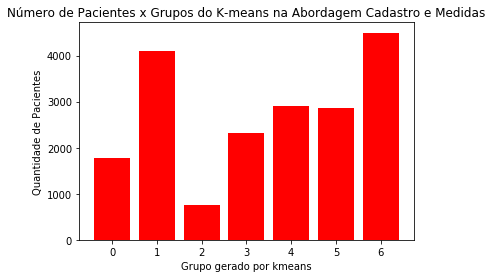

In [35]:
classes = []
qtds = []

contagem = Counter(grupos_cadastro)

for i in range(0,num_otimo_clusters_cadastro):
    classes.append(i)
    qtds.append(contagem[i])

plt.bar(classes,qtds,color="red")
plt.xticks(classes)
plt.ylabel('Quantidade de Pacientes')
plt.xlabel('Grupo gerado por kmeans')
plt.title('Número de Pacientes x Grupos do K-means na Abordagem Cadastro e Medidas')
fig = plt.gcf()
fig.savefig(DIR_KMEANS / 'graficos' / 'grafico_Random_Abordagem1_pacientes_por_grupos.svg',format="svg")
plt.show()


In [36]:
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

#separar train(75%) - 14.485, test (10%) - 7.726  and validation (15%) - 11.588
#  O parâmetro random_state=42 garante o rastreio do numero de identificação
x_train, x_test, y_train, y_test = train_test_split(dados_cadastro_array, grupos_cadastro, test_size=1 - train_ratio,random_state=42)
x_val, x_test, y_val, y_test = train_test_split(dados_cadastro_array, grupos_cadastro, test_size=test_ratio/(test_ratio + validation_ratio),random_state=42)

In [37]:
#treino
random_forest_cadastro.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

#### Abordagem 1: VALIDAÇÃO

In [38]:
#calcular acuracia, recall e f1
y_prev_val = random_forest_cadastro.predict(x_val)

accuracy = accuracy_score(y_val, y_prev_val)
recall = recall_score(y_val, y_prev_val,average='macro')
f1 = f1_score(y_val, y_prev_val,average='macro')

In [39]:
print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

Accuracy: 1.0 - Recall: 1.0 - F1 Score: 1.0


In [40]:
#Matriz de Confusão
mat=list(confusion_matrix(y_val, y_prev_val, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

0     1    2     3     4     5     6
0  1060     0    0     0     0     0     0
1     0  2467    0     0     0     0     0
2     0     0  478     0     0     0     0
3     0     0    0  1425     0     0     0
4     0     0    0     0  1731     0     0
5     0     0    0     0     0  1734     0
6     0     0    0     0     0     0  2650

#### Abordagem 1: TESTE

In [41]:
#calcular acuracia, recall e f1
y_prev_test = random_forest_cadastro.predict(x_test)

accuracy = accuracy_score(y_test, y_prev_test)
recall = recall_score(y_test, y_prev_test,average='macro')
f1 = f1_score(y_test, y_prev_test,average='macro')

In [42]:
print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

Accuracy: 0.9137326230999091 - Recall: 0.8917428595357616 - F1 Score: 0.9076479928455573


In [43]:
#Matriz da Confusão
mat=list(confusion_matrix(y_test, y_prev_test, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

0     1    2    3     4     5     6
0  605     0    0   16     0    50    50
1    0  1528    0    0    31    19    65
2   11     0  225   48     0     0     0
3    5     0    2  819     0     0    76
4    0    66    0    0  1086    18     0
5   13    60    0    0    26  1004    27
6    8    48    0   10     0    15  1766

In [44]:
dataset_s_d.describe()
dados_cadastro_array.shape
dados_cadastro_sem_id

genero  idade   IMC  sist 9:00  sist 9:15  sist 9:30  sist 9:45  \
0           1   94.0  33.2      105.0      108.0      116.0      104.0   
1           1   70.0  29.4      103.0      114.0       82.0      104.0   
2           1   19.0  25.8      147.0      148.0      156.0      140.0   
3           0   40.0  24.2      140.0      139.0      142.0      137.0   
4           1   28.0  40.6      113.0      110.0      101.0      108.0   
...       ...    ...   ...        ...        ...        ...        ...   
19237       1   47.0  27.5      163.0      198.0      172.0      148.0   
19238       1   49.0  26.9      114.0      120.0      164.0      116.0   
19239       0   35.0  33.3      107.0      110.0      103.0      105.0   
19240       0   68.0  25.0       94.0      107.0      112.0      124.0   
19241       1   49.0  30.9      111.0      104.0      103.0      101.0   

       sist 10:00  sist 10:15  sist 10:30  ...  diast 6:45  diast 7:00  \
0           106.0        98.0       102.0  ...        46.0        51.0   
1            98.0       106.0       108.0  ...        74.0        74.0   
2           130.0       132.0       121.0  ...        86.0        93.0   
3           135.0       177.0       148.0  ...        56.0        62.0   
4           111.0       111.0       114.0  ...        73.0        83.0   
...           ...         ...         ...  ...         ...         ...   
19237       161.0       156.0       156.0  ...       114.0       126.0   
19238       119.0       126.0       123.0  ...        73.0        59.0   
19239       108.0       111.0       114.0  ...        50.0        50.0   
19240       120.0        94.0       102.0  ...        63.0        64.0   
19241        97.0       110.0       111.0  ...        68.0        69.0   

       diast 7:15  diast 7:30  diast 7:45  diast 8:00  diast 8:15  diast 8:30  \
0            56.0        61.0        67.0        61.0        69.0        62.0   
1            70.0        67.0        63.0        60.0        74.0        70.0   
2            91.0        89.0        87.0        86.0        87.0        82.0   
3            83.0       104.0        99.0        94.0        89.0        90.0   
4            93.0        68.0        91.0        87.0        84.0        81.0   
...           ...         ...         ...         ...         ...         ...   
19237       125.0       124.0       123.0       123.0       121.0       119.0   
19238        74.0        68.0        86.0        96.0       107.0       106.0   
19239        53.0        52.0        62.0        68.0        61.0        64.0   
19240        76.0        72.0        69.0        75.0        74.0        69.0   
19241        71.0        73.0        56.0        57.0        65.0        68.0   

       diast 8:45  grupo  
0            51.0      6  
1            67.0      5  
2            82.0      1  
3            72.0      1  
4            72.0      2  
...           ...    ...  
19237       123.0      3  
19238        93.0      4  
19239        60.0      5  
19240        67.0      2  
19241        82.0      7  

[19242 rows x 168 columns]

In [45]:
#salvar dataframe numero_paciente, grupo_real, grupo, previsto validação
x_train_, x_test_, y_train_, y_test_ = train_test_split(dataset_s_d, grupos_cadastro, test_size=1 - train_ratio, random_state=42)
x_val_, x_test_, y_val_, y_test_ = train_test_split(dataset_s_d, grupos_cadastro, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42)

#validacao
pacientes_validacao_diast_sisto = x_val_[['numero_identificacao']]
pacientes_validacao_diast_sisto['Grupo_Real'] = y_val_
pacientes_validacao_diast_sisto['Grupo_Previsto'] = y_prev_val

pacientes_validacao_diast_sisto.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'pacientes_validacao_cadastro.csv', 
             sep=';',index=False,encoding='UTF-8')

#teste
pacientes_teste_diast_sisto = x_test_[['numero_identificacao']]
pacientes_teste_diast_sisto['Grupo_Real'] = y_test_
pacientes_teste_diast_sisto['Grupo_Previsto'] = y_prev_test

pacientes_teste_diast_sisto.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'pacientes_teste_cadastro.csv', 
             sep=';',index=False,encoding='UTF-8')


c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

#### Abordagem 1: Importância das Features Random Forest

In [46]:
len(ls_cadastro), len(random_forest_cadastro.feature_importances_)

(167, 167)

In [47]:
#calculo da importancia de cada variavel para idenficar os grupos com 3 casas decimais
importancia = pd.DataFrame({'features':ls_cadastro,'importance':np.round(random_forest_cadastro.feature_importances_,3)})
importancia = importancia.sort_values('importance',ascending=False)

#importances.to_excel('diastolica_sistolica/features_sisto_diasto.xlsx')

importancia.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'importancia_features_cadastro.csv', 
             sep=';',index=False,encoding='UTF-8')

importancia

features  importance
76     sist 6:45       0.015
74     sist 6:15       0.015
43    sist 19:00       0.013
95   diast 11:30       0.011
47    sist 20:00       0.011
..           ...         ...
141  diast 23:00       0.003
20    sist 13:15       0.003
139  diast 22:30       0.003
2            IMC       0.002
0         genero       0.000

[167 rows x 2 columns]

# Abordagem 2: Medidas como entrada

In [48]:
#selecionando variaveis de medidas : sist 9:00 a diast 8:45

#   Gera uma lista com cabeçalhos
ls_sist_diast = list(dataset_medidas.loc[:,'sist 9:00':'diast 8:45'].columns)

dados_medidas_sem_id = dataset_medidas.loc[:,'sist 9:00':'diast 8:45']

#dados_medidas_sem_id.head(5)
dados_medidas_sem_id.loc[1:70]


sist 9:00  sist 9:15  sist 9:30  sist 9:45  sist 10:00  sist 10:15  \
1       103.0      114.0       82.0      104.0        98.0       106.0   
2       147.0      148.0      156.0      140.0       130.0       132.0   
3       140.0      139.0      142.0      137.0       135.0       177.0   
4       113.0      110.0      101.0      108.0       111.0       111.0   
5       152.0      152.0      152.0      152.0       154.0       138.0   
..        ...        ...        ...        ...         ...         ...   
66       80.0       80.0       85.0       96.0       106.0       105.0   
67      113.0      119.0      120.0      122.0       117.0       122.0   
68      154.0      142.0      123.0      125.0       111.0       113.0   
69      118.0      122.0      116.0      115.0        84.0       102.0   
70      146.0      162.0      108.0      112.0       117.0       128.0   

    sist 10:30  sist 10:45  sist 11:00  sist 11:15  ...  diast 6:30  \
1        108.0       107.0       109.0       100.0  ...        74.0   
2        121.0       113.0       149.0       128.0  ...        80.0   
3        148.0       152.0       135.0       136.0  ...        49.0   
4        114.0       115.0       113.0       112.0  ...        64.0   
5        137.0       152.0        95.0       117.0  ...        67.0   
..         ...         ...         ...         ...  ...         ...   
66       103.0       105.0       104.0       100.0  ...        59.0   
67       118.0       122.0       126.0       133.0  ...        85.0   
68       114.0       118.0       113.0       121.0  ...        67.0   
69       120.0       118.0       116.0       115.0  ...        68.0   
70       128.0       127.0       126.0       137.0  ...        76.0   

    diast 6:45  diast 7:00  diast 7:15  diast 7:30  diast 7:45  diast 8:00  \
1         74.0        74.0        70.0        67.0        63.0        60.0   
2         86.0        93.0        91.0        89.0        87.0        86.0   
3         56.0        62.0        83.0       104.0        99.0        94.0   
4         73.0        83.0        93.0        68.0        91.0        87.0   
5         94.0       120.0       109.0       109.0       110.0       111.0   
..         ...         ...         ...         ...         ...         ...   
66        60.0        61.0        60.0        60.0        55.0        61.0   
67        85.0        85.0        86.0        87.0        62.0        63.0   
68        78.0        89.0        97.0        82.0        87.0        96.0   
69        68.0        67.0        56.0        62.0        66.0        73.0   
70        80.0        84.0        73.0        71.0        71.0        80.0   

    diast 8:15  diast 8:30  diast 8:45  
1         74.0        70.0        67.0  
2         87.0        82.0        82.0  
3         89.0        90.0        72.0  
4         84.0        81.0        72.0  
5        112.0       114.0       115.0  
..         ...         ...         ...  
66        47.0        49.0        45.0  
67        86.0        81.0        84.0  
68       100.0        83.0        85.0  
69        66.0        72.0        75.0  
70        77.0        76.0        74.0  

[70 rows x 164 columns]

## Abordagem 2: Número de Clusters gerado pelo k-Means

In [49]:
#calculando a quantidade ótima de clusters (é possivel dividir os pacientes em quantos grupos)
%time sum_of_squares_medidas = calculate_wcss(dados_medidas_sem_id)
num_otimo_clusters_medidas = optimal_number_of_clusters(sum_of_squares_medidas)
num_otimo_clusters_medidas

Wall time: 2min 47s


7

In [50]:
#convertendo os dados para a clusterização

dados_medidas_array = np.array(dados_medidas_sem_id)

In [51]:
#habilitando o kmeans com "num_otimo_clusters" grupos (foi calculado na etapa anterior)

kmeans_medidas = KMeans(n_clusters=num_otimo_clusters_medidas, random_state=42).fit(dados_medidas_array)

In [52]:
#listar os grupos 

%time grupos_medidas = kmeans_medidas.fit_predict(dados_medidas_array)

Wall time: 6.05 s


In [53]:
#incluir grupos nos dados de sist e diast

dados_medidas_sem_id['grupo'] = grupos_medidas
dados_medidas_sem_id['grupo'] = dados_medidas_sem_id['grupo'] + 1
dados_medidas_sem_id

sist 9:00  sist 9:15  sist 9:30  sist 9:45  sist 10:00  sist 10:15  \
0          105.0      108.0      116.0      104.0       106.0        98.0   
1          103.0      114.0       82.0      104.0        98.0       106.0   
2          147.0      148.0      156.0      140.0       130.0       132.0   
3          140.0      139.0      142.0      137.0       135.0       177.0   
4          113.0      110.0      101.0      108.0       111.0       111.0   
...          ...        ...        ...        ...         ...         ...   
19237      163.0      198.0      172.0      148.0       161.0       156.0   
19238      114.0      120.0      164.0      116.0       119.0       126.0   
19239      107.0      110.0      103.0      105.0       108.0       111.0   
19240       94.0      107.0      112.0      124.0       120.0        94.0   
19241      111.0      104.0      103.0      101.0        97.0       110.0   

       sist 10:30  sist 10:45  sist 11:00  sist 11:15  ...  diast 6:45  \
0           102.0       107.0       111.0       116.0  ...        46.0   
1           108.0       107.0       109.0       100.0  ...        74.0   
2           121.0       113.0       149.0       128.0  ...        86.0   
3           148.0       152.0       135.0       136.0  ...        56.0   
4           114.0       115.0       113.0       112.0  ...        73.0   
...           ...         ...         ...         ...  ...         ...   
19237       156.0       138.0       107.0        76.0  ...       114.0   
19238       123.0       122.0       122.0       159.0  ...        73.0   
19239       114.0       144.0       128.0       104.0  ...        50.0   
19240       102.0       113.0       104.0        96.0  ...        63.0   
19241       111.0       116.0       104.0       121.0  ...        68.0   

       diast 7:00  diast 7:15  diast 7:30  diast 7:45  diast 8:00  diast 8:15  \
0            51.0        56.0        61.0        67.0        61.0        69.0   
1            74.0        70.0        67.0        63.0        60.0        74.0   
2            93.0        91.0        89.0        87.0        86.0        87.0   
3            62.0        83.0       104.0        99.0        94.0        89.0   
4            83.0        93.0        68.0        91.0        87.0        84.0   
...           ...         ...         ...         ...         ...         ...   
19237       126.0       125.0       124.0       123.0       123.0       121.0   
19238        59.0        74.0        68.0        86.0        96.0       107.0   
19239        50.0        53.0        52.0        62.0        68.0        61.0   
19240        64.0        76.0        72.0        69.0        75.0        74.0   
19241        69.0        71.0        73.0        56.0        57.0        65.0   

       diast 8:30  diast 8:45  grupo  
0            62.0        51.0      1  
1            70.0        67.0      1  
2            82.0        82.0      6  
3            90.0        72.0      6  
4            81.0        72.0      5  
...           ...         ...    ...  
19237       119.0       123.0      7  
19238       106.0        93.0      3  
19239        64.0        60.0      1  
19240        69.0        67.0      5  
19241        68.0        82.0      4  

[19242 rows x 165 columns]

###  Abordagem 2: Método Elbow
####  Esse método para calcular o melhor número de cluster para o algoritmo e mostar o gráfico
####  https://minerandodados.com.br/algoritmo-k-means-python-passo-passo/#:~:text=O%20m%C3%A9todo%20Elbow%20se%20trata,um%20valor%20significativo%20de%20ganho.

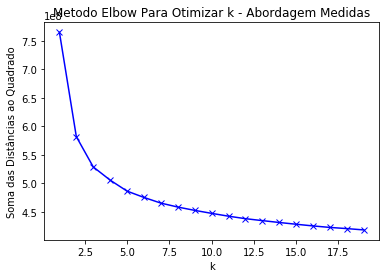

Wall time: 79 ms


In [54]:
#metodo de Elbow

Sum_of_squared_distances = []
K = range(1,20)

for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(dados_medidas_array)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Soma das Distâncias ao Quadrado')
plt.title('Metodo Elbow Para Otimizar k - Abordagem Medidas')
fig = plt.gcf() 
fig.savefig( DIR_KMEANS / 'graficos' / f'metodoelbow_medida.svg', format="svg")
%time plt.show()

### Abordagem 2: Silhouette

####  A análise da Silhouette pode ser usada para determinar o grau de separação entre os clusters. O coeficiente de Silhouette quando próximo de +1, indica que os pontos estão muito longe dos pontos do outro cluster, e quando próximo de 0, indica que os pontos então muito perto ou até interseccionando um outro cluster



Para n_clusters = 2 O score_silhouette medio e : 0.205980053119702
Para n_clusters = 3 O score_silhouette medio e : 0.12819025665515218
Para n_clusters = 4 O score_silhouette medio e : 0.08315678031265275
Para n_clusters = 5 O score_silhouette medio e : 0.07932143504308604
Para n_clusters = 6 O score_silhouette medio e : 0.06197238886121969
Para n_clusters = 7 O score_silhouette medio e : 0.05924834908170122
Para n_clusters = 8 O score_silhouette medio e : 0.055022330904016786


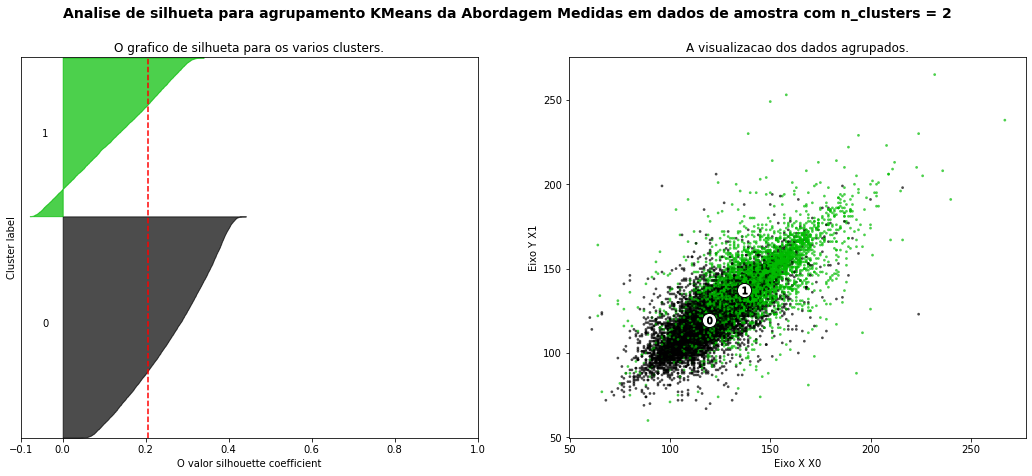

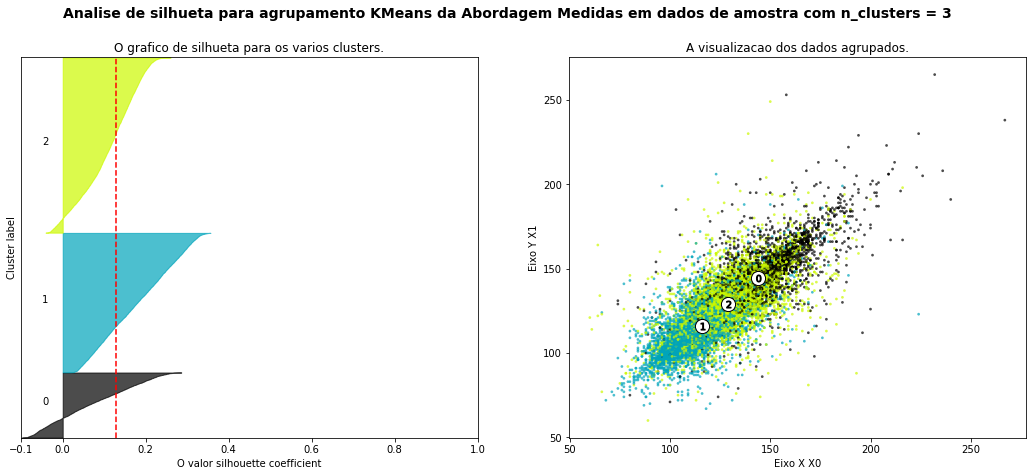

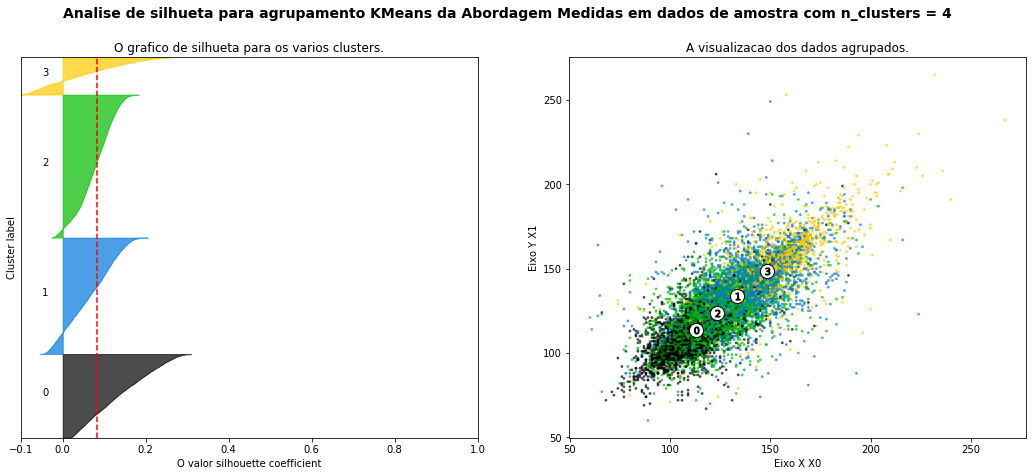

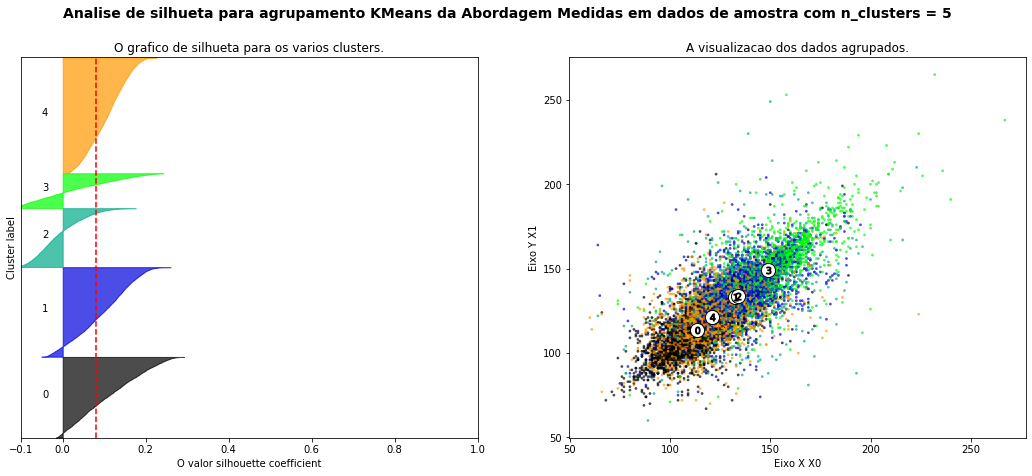

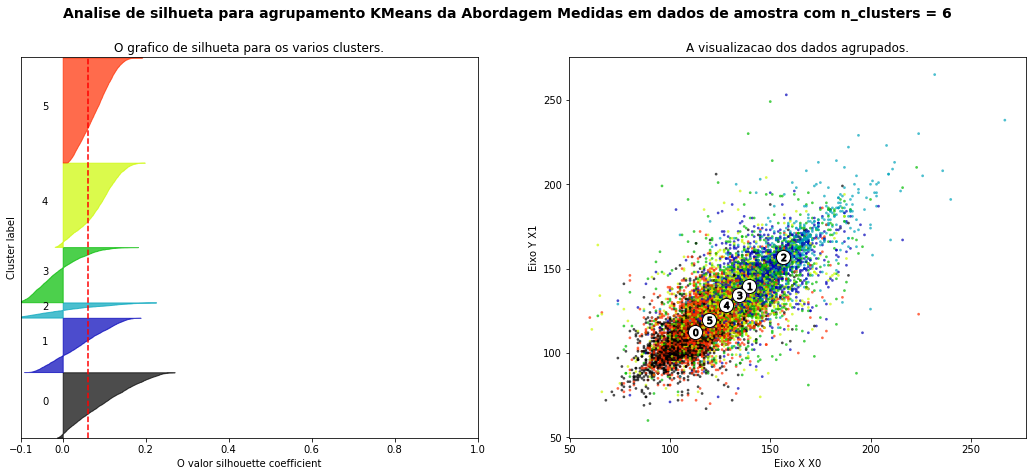

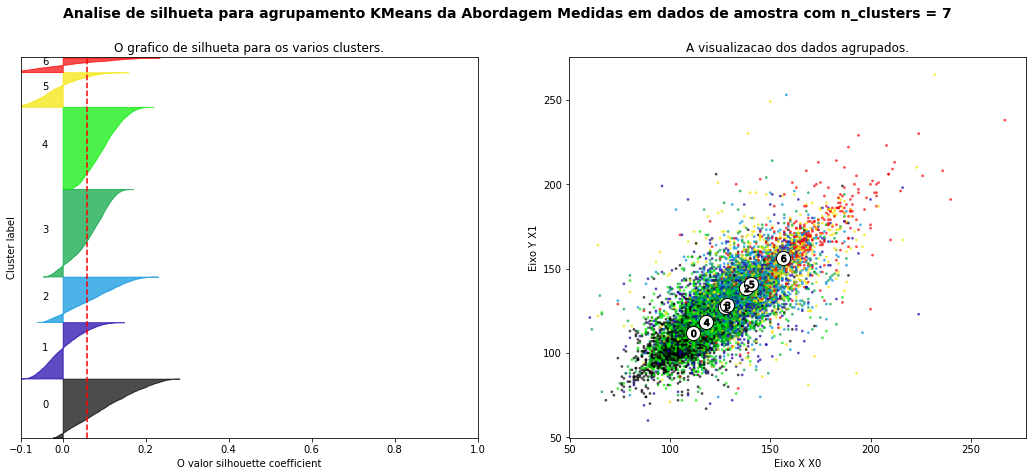

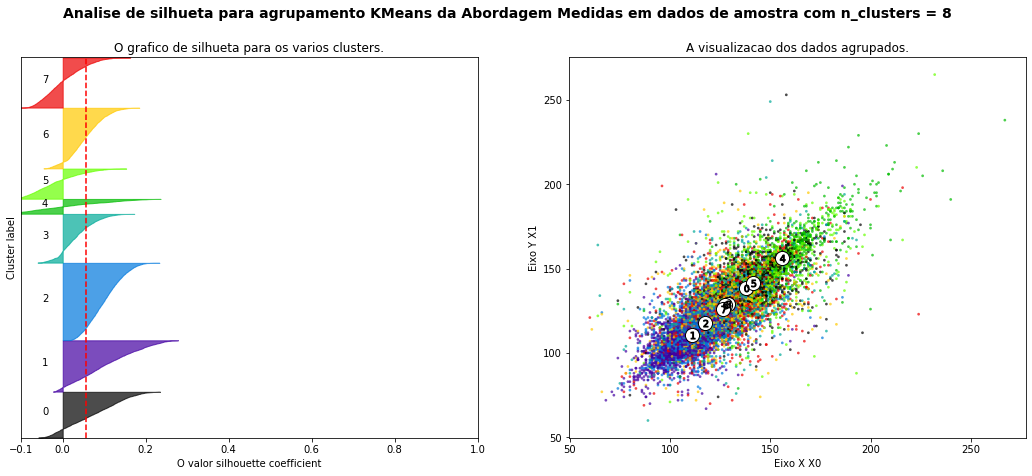

In [55]:
#Silhouette

range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for n_clusters in range_n_clusters:    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    # O 1st subplot é o grafico silhouette
    # O coeficiente silhouette  um range de -1, 1 but in this example all
    # Os exemplos vão ficar em [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # O (n_clusters + 1) * 10 é para inserir um espaço em branco entre a silhueta
    # Para gerar destaque
    ax1.set_ylim([0, len(dados_medidas_array) + (n_clusters + 1) * 10])
    # Inicialize o clusterer com o valor n_clusters e um valor aleatorio
    # seed 10.
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(dados_medidas_array)
# O silhouette_score fornece o valor médio para todas as amostras.
    # Isso dá uma perspectiva sobre a densidade e separação das formas
    # clusters
    #  Cálculo de toda a matriz que entra no cálculo do Silhouette
    silhouette_avg = silhouette_score(dados_medidas_array, cluster_labels)
    print("Para n_clusters =", n_clusters,
          "O score_silhouette medio e :", silhouette_avg)
    # Calcule as pontuações da silhueta para cada amostra
    sample_silhouette_values = silhouette_samples(dados_medidas_array, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        # Agregue as pontuações de silhueta para amostras pertencentes a
        # cluster i, e classifica-los
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        # Rotule os gráficos de silhueta com seus números de cluster no meio
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        # Calcule o novo y_lower para o próximo gráfico
        y_lower = y_upper + 10  #10 para as 0 amostras
    ax1.set_title("O grafico de silhueta para os varios clusters.")
    ax1.set_xlabel("O valor silhouette coefficient")
    ax1.set_ylabel("Cluster label")
    # A linha vertical para a pontuação média da silhueta de todos os valores
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])  # Limpar os yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    # 2º gráfico mostrando os clusters reais formados
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(dados_medidas_array[:, 0], dados_medidas_array[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
    # Labeling dos clusters
    centers = clusterer.cluster_centers_
    # Desenhe círculos brancos nos centros do cluster
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')
    ax2.set_title("A visualizacao dos dados agrupados.")
    ax2.set_xlabel("Eixo X X0")
    ax2.set_ylabel("Eixo Y X1")
    plt.suptitle(("Analise de silhueta para agrupamento KMeans da Abordagem Medidas em dados de amostra "
                  "com n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    fig = plt.gcf()
    fig.savefig( DIR_KMEANS / 'graficos' / f'metodosilhouette_medidas_{n_clusters}.svg', format="svg")
    
plt.show()

#fig.savefig('diast_sist_kmeans.png', format='png')

### Não existe um valor de k clusters que não esteja se intersectando¶

In [56]:
# Dataset com grupos e medidas
# nume id, data exame, idade, peso, altura, medidas, 22 estatisticas, 11 doenças em cada grupo 

#
dataset_medidas_apos_kmeans = dataset_apos_tratamento.loc[:,'numero_identificacao':'IMC']

dataset_medidas_apos_kmeans['grupo'] = grupos_medidas
dataset_medidas_apos_kmeans = pd.concat([dataset_medidas_apos_kmeans,
                                         dataset_apos_tratamento.loc[:,'sist 9:00':'Picos Diastolica']],axis=1)
dataset_medidas_apos_kmeans

# Salva dataset com dados completos após o K-Means com abordagem 1 (medidas)
dataset_medidas_apos_kmeans.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'mapa_apos_kmeans_medidas.csv', 
             sep=';',index=False,encoding='UTF-8')

In [57]:
dataset_medidas_apos_kmeans.head()

numero_identificacao data_nascimento  genero  idade   peso altura   IMC  \
0                     4      1923-10-05       1   94.0   85.0    160  33.2   
1                     5      1948-10-07       1   70.0   80.0    165  29.4   
2                     6      1999-03-23       1   19.0  100.0    197  25.8   
3                     7      1978-01-26       0   40.0   65.0   1,64  24.2   
4                     8      1990-03-07       1   28.0  120.0    172  40.6   

   grupo  sist 9:00  sist 9:15  ...  Mediana Diastolica em 24h  \
0      0      105.0      108.0  ...                       59.0   
1      0      103.0      114.0  ...                       62.0   
2      5      147.0      148.0  ...                       79.0   
3      5      140.0      139.0  ...                       80.0   
4      4      113.0      110.0  ...                       78.0   

   AUC Sistolica em 24h  AUC Diastolica em 24h  AUC PP Daytime  \
0                9545.5                 4902.0          3748.0   
1                8586.5                 5034.5          2915.0   
2               10674.0                 6154.0          3721.0   
3               10679.5                 6420.5          3642.0   
4                9141.5                 6118.0          2405.0   

   AUC PP Nighttime  DP Sistolica em 24h  DP Diastolica em 24h  \
0             841.5                16.52                 11.36   
1             606.0                 7.51                  6.65   
2             751.5                12.70                 13.01   
3             602.5                16.13                 10.34   
4             566.0                12.27                 12.79   

   Diferenca % Dipping  Picos Sistolica  Picos Diastolica  
0                0.966               11                34  
1                0.969                9                23  
2                1.056               19                19  
3                1.107               21                 9  
4                1.137               10                11  

[5 rows x 210 columns]

### Abordagem 2: Random Forest

In [58]:
from sklearn.ensemble import RandomForestClassifier

In [59]:
#parametro simples do modelo
random_forest_medidas = RandomForestClassifier(n_estimators=50)

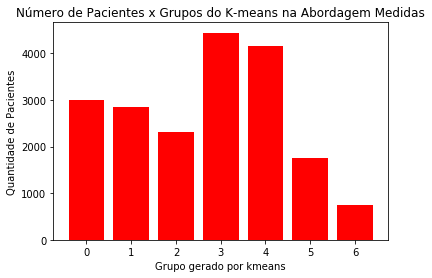

In [60]:
# Plota Gráfico da qtd pacientes em cada Grupos

classes = []
qtds = []

contagem = Counter(grupos_medidas)

for i in range(0,num_otimo_clusters_medidas):
    classes.append(i)
    qtds.append(contagem[i])

plt.bar(classes,qtds,color="red")
plt.xticks(classes)
plt.ylabel('Quantidade de Pacientes')
plt.xlabel('Grupo gerado por kmeans')
plt.title('Número de Pacientes x Grupos do K-means na Abordagem Medidas')
fig = plt.gcf()
fig.savefig(DIR_KMEANS / 'graficos' / 'grafico_Random_Abordagem1_pacientes_por_grupos.svg',format="svg")
plt.show()


In [61]:
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

#separar train(75%) - 14.485, test (10%) - 7.726  and validation (15%) - 11.588
#  O parâmetro random_state=42 garante o rastreio do numero de identificação
x_train, x_test, y_train, y_test = train_test_split(dados_medidas_array, grupos_medidas, test_size=1 - train_ratio,random_state=42)
x_val, x_test, y_val, y_test = train_test_split(dados_medidas_array, grupos_medidas, test_size=test_ratio/(test_ratio + validation_ratio),random_state=42)

In [62]:
#treino
random_forest_medidas.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

#### Abordagem 2: VALIDAÇÃO

In [63]:
#calcular acuracia, recall e f1
y_prev_val = random_forest_medidas.predict(x_val)

accuracy = accuracy_score(y_val, y_prev_val)
recall = recall_score(y_val, y_prev_val,average='macro')
f1 = f1_score(y_val, y_prev_val,average='macro')

In [64]:
print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

Accuracy: 1.0 - Recall: 1.0 - F1 Score: 1.0


In [65]:
#Matriz de Confusão
mat=list(confusion_matrix(y_val, y_prev_val, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

0     1     2     3     4     5    6
0  1794     0     0     0     0     0    0
1     0  1718     0     0     0     0    0
2     0     0  1418     0     0     0    0
3     0     0     0  2620     0     0    0
4     0     0     0     0  2492     0    0
5     0     0     0     0     0  1040    0
6     0     0     0     0     0     0  463

#### Abordagem 2: TESTE

In [66]:
#calcular acuracia, recall e f1
y_prev_test = random_forest_medidas.predict(x_test)

accuracy = accuracy_score(y_test, y_prev_test)
recall = recall_score(y_test, y_prev_test,average='macro')
f1 = f1_score(y_test, y_prev_test,average='macro')

In [67]:
print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

Accuracy: 0.9133428608548785 - Recall: 0.888959063914353 - F1 Score: 0.9061505418821462


In [68]:
#Matriz da Confusão
mat=list(confusion_matrix(y_test, y_prev_test, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

0     1    2     3     4    5    6
0  1130    18    0     0    52    0    0
1    29  1010    0    43    53    4    0
2     0     0  811    67     0    6    0
3     0    12   15  1749    38    7    0
4    35    24    0    69  1538    0    0
5     0    49   14    71     0  575    1
6     0     0   48     0     0   12  217

In [69]:
dataset_medidas_apos_kmeans.describe()


numero_identificacao        genero         idade          peso  \
count          19242.000000  19242.000000  19242.000000  19242.000000   
mean           10810.899023      0.455254     55.437013     77.364515   
std             6302.234699      0.498007     15.954655     16.986592   
min                4.000000      0.000000      6.000000      4.000000   
25%             5336.250000      0.000000     43.000000     65.000000   
50%            10724.500000      0.000000     55.000000     75.000000   
75%            16279.750000      1.000000     68.000000     87.000000   
max            21793.000000      1.000000    102.000000    200.000000   

                IMC         grupo     sist 9:00     sist 9:15    sist 9:30  \
count  19242.000000  19242.000000  19242.000000  19242.000000  19242.00000   
mean      27.903253      2.629976    126.651855    126.919239    126.93140   
std        5.725094      1.703862     17.561449     17.629175     17.50377   
min        1.400000      0.000000     60.000000     60.000000     61.00000   
25%       24.600000      1.000000    115.000000    115.000000    115.00000   
50%       27.200000      3.000000    125.000000    126.000000    125.00000   
75%       30.400000      4.000000    137.000000    137.000000    137.00000   
max      181.000000      6.000000    267.000000    265.000000    257.00000   

          sist 9:45  ...  Mediana Diastolica em 24h  AUC Sistolica em 24h  \
count  19242.000000  ...               19242.000000          19242.000000   
mean     126.876884  ...                  77.176281           9946.294330   
std       17.398486  ...                   9.953922            942.800934   
min       62.000000  ...                  43.000000           6903.000000   
25%      115.000000  ...                  70.000000           9298.125000   
50%      125.000000  ...                  77.000000           9863.250000   
75%      137.000000  ...                  84.000000          10480.500000   
max      243.000000  ...                 138.500000          15230.000000   

       AUC Diastolica em 24h  AUC PP Daytime  AUC PP Nighttime  \
count           19242.000000    19242.000000      19242.000000   
mean             6221.795473     3072.353368        604.875065   
std               766.662561      616.105693        122.748114   
min              3651.500000     1641.500000        281.500000   
25%              5695.500000     2630.000000        519.500000   
50%              6188.500000     2975.000000        587.000000   
75%              6706.000000     3411.500000        669.500000   
max             11134.500000     7329.500000       1418.500000   

       DP Sistolica em 24h  DP Diastolica em 24h  Diferenca % Dipping  \
count         19242.000000          19242.000000         19241.000000   
mean             12.919029             10.579450             1.080988   
std               3.471377              2.308248             0.080884   
min               4.570000              3.980000             0.739000   
25%              10.490000              8.960000             1.028000   
50%              12.390000             10.380000             1.079000   
75%              14.790000             11.960000             1.132000   
max              39.550000             24.390000             1.607000   

       Picos Sistolica  Picos Diastolica  
count     19242.000000      19242.000000  
mean         16.191664         20.633302  
std          13.083714         13.834369  
min           0.000000          0.000000  
25%           7.000000         11.000000  
50%          12.000000         17.000000  
75%          21.000000         27.000000  
max          81.000000         82.000000  

[8 rows x 195 columns]

In [70]:
#salvar dataframe numero_paciente, grupo_real, grupo, previsto validação
x_train_, x_test_, y_train_, y_test_ = train_test_split(dataset_medidas_apos_kmeans, grupos_medidas, test_size=1 - train_ratio, random_state=42)
x_val_, x_test_, y_val_, y_test_ = train_test_split(dataset_medidas_apos_kmeans, grupos_medidas, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42)

#validacao
pacientes_validacao_diast_sisto = x_val_[['numero_identificacao']]
pacientes_validacao_diast_sisto['Grupo_Real'] = y_val_
pacientes_validacao_diast_sisto['Grupo_Previsto'] = y_prev_val

pacientes_validacao_diast_sisto.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'pacientes_validacao_medidas.csv', 
             sep=';',index=False,encoding='UTF-8')

#teste
pacientes_teste_diast_sisto = x_test_[['numero_identificacao']]
pacientes_teste_diast_sisto['Grupo_Real'] = y_test_
pacientes_teste_diast_sisto['Grupo_Previsto'] = y_prev_test

pacientes_teste_diast_sisto.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'pacientes_teste_medidas.csv', 
             sep=';',index=False,encoding='UTF-8')


c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

#### Abordagem 2: Importância das Features Random Forest

In [71]:
len(ls_sist_diast), len(random_forest_medidas.feature_importances_)

(164, 164)

In [72]:
#calculo da importancia de cada variavel para idenficar os grupos com 3 casas decimais
importancia = pd.DataFrame({'features':ls_sist_diast,'importance':np.round(random_forest_medidas.feature_importances_,3)})
importancia = importancia.sort_values('importance',ascending=False)

importancia.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'importancia_features_medidas.csv', 
             sep=';',index=False,encoding='UTF-8')

importancia


features  importance
71     sist 6:15       0.016
73     sist 6:45       0.014
92   diast 11:30       0.013
42    sist 19:30       0.012
46    sist 20:30       0.011
..           ...         ...
141   diast 0:30       0.003
139  diast 23:30       0.003
138  diast 23:00       0.003
137  diast 22:45       0.003
140   diast 0:00       0.003

[164 rows x 2 columns]

# Abordagem 2.1: Medidas Importantes

In [73]:
ls_importantes = importancia['features'].iloc[:7].values
ls_importantes

array(['sist 6:15', 'sist 6:45', 'diast 11:30', 'sist 19:30',
       'sist 20:30', 'diast 15:00', 'sist 19:00'], dtype=object)

In [74]:
medidas_importantes = dataset_apos_tratamento[ls_importantes]
medidas_importantes

sist 6:15  sist 6:45  diast 11:30  sist 19:30  sist 20:30  diast 15:00  \
0          104.0       94.0         62.0       123.0       110.0         58.0   
1          107.0      111.0         60.0       107.0       108.0         71.0   
2          122.0      136.0         72.0       111.0       137.0         98.0   
3          116.0      104.0         84.0       124.0       137.0         66.0   
4          102.0      116.0         78.0       138.0       117.0         82.0   
...          ...        ...          ...         ...         ...          ...   
19237      152.0      162.0        135.0       158.0       163.0        118.0   
19238      146.0      136.0         88.0       123.0       147.0         83.0   
19239       94.0       96.0         64.0       117.0       133.0         68.0   
19240      107.0      124.0         64.0       126.0       130.0         92.0   
19241      102.0      105.0         99.0       112.0       110.0         99.0   

       sist 19:00  
0           129.0  
1           104.0  
2           125.0  
3           113.0  
4           102.0  
...           ...  
19237       163.0  
19238       118.0  
19239       145.0  
19240       118.0  
19241       121.0  

[19242 rows x 7 columns]

## Abordagem 2.1: Número de Clusters gerado pelo k-Means

In [75]:
#calculando a quantidade ótima de clusters (é possivel dividir os pacientes em quantos grupos)
%time sum_of_squares_medidas_importantes = calculate_wcss(medidas_importantes)
num_otimo_clusters_medidas_importantes = optimal_number_of_clusters(sum_of_squares_medidas_importantes)
num_otimo_clusters_medidas_importantes

Wall time: 46 s


7

In [76]:
#convertendo os dados para a clusterização

dados_medidas_importantes_array = np.array(medidas_importantes)

In [77]:
#habilitando o kmeans com "num_otimo_clusters" grupos (foi calculado na etapa anterior)

kmeans_medidas_importantes = KMeans(n_clusters=num_otimo_clusters_medidas_importantes, random_state=42).fit(dados_medidas_importantes_array)

In [78]:
#listar os grupos 

%time grupos_medidas_importantes = kmeans_medidas_importantes.fit_predict(dados_medidas_importantes_array)
grupos_medidas_importantes

Wall time: 1.3 s


array([4, 4, 3, ..., 2, 6, 6])

In [79]:
medidas_importantes.insert(0,'grupo',grupos_medidas_importantes + 1)
medidas_importantes

grupo  sist 6:15  sist 6:45  diast 11:30  sist 19:30  sist 20:30  \
0          5      104.0       94.0         62.0       123.0       110.0   
1          5      107.0      111.0         60.0       107.0       108.0   
2          4      122.0      136.0         72.0       111.0       137.0   
3          3      116.0      104.0         84.0       124.0       137.0   
4          7      102.0      116.0         78.0       138.0       117.0   
...      ...        ...        ...          ...         ...         ...   
19237      6      152.0      162.0        135.0       158.0       163.0   
19238      4      146.0      136.0         88.0       123.0       147.0   
19239      3       94.0       96.0         64.0       117.0       133.0   
19240      7      107.0      124.0         64.0       126.0       130.0   
19241      7      102.0      105.0         99.0       112.0       110.0   

       diast 15:00  sist 19:00  
0             58.0       129.0  
1             71.0       104.0  
2             98.0       125.0  
3             66.0       113.0  
4             82.0       102.0  
...            ...         ...  
19237        118.0       163.0  
19238         83.0       118.0  
19239         68.0       145.0  
19240         92.0       118.0  
19241         99.0       121.0  

[19242 rows x 8 columns]

In [80]:
df_medidas_importantes = pd.concat([dataset_apos_tratamento.loc[:,:'data_exame'],medidas_importantes,dataset_apos_tratamento.loc[:,:'data_exame'],dataset_apos_tratamento.loc[:,'whitecoat':]], axis=1)
df_medidas_importantes

numero_identificacao data_nascimento  genero  idade   peso altura  \
0                         4      1923-10-05       1   94.0   85.0    160   
1                         5      1948-10-07       1   70.0   80.0    165   
2                         6      1999-03-23       1   19.0  100.0    197   
3                         7      1978-01-26       0   40.0   65.0   1,64   
4                         8      1990-03-07       1   28.0  120.0    172   
...                     ...             ...     ...    ...    ...    ...   
19237                 21786      1972-11-25       1   47.0   75.0    165   
19238                 21787      1970-10-19       1   49.0   90.0    183   
19239                 21788      1985-03-15       0   35.0   93.0    167   
19240                 21792      1952-04-21       0   68.0   64.0    160   
19241                 21793      1971-01-14       1   49.0   99.0    179   

        IMC           data_exame  grupo  sist 6:15  ...  \
0      33.2  2018-09-10 12:25:23      5      104.0  ...   
1      29.4  2018-12-26 07:39:41      5      107.0  ...   
2      25.8  2018-12-26 08:06:19      4      122.0  ...   
3      24.2  2018-12-26 08:19:06      3      116.0  ...   
4      40.6  2018-12-26 08:26:59      7      102.0  ...   
...     ...                  ...    ...        ...  ...   
19237  27.5  2020-09-10 16:03:08      6      152.0  ...   
19238  26.9  2020-09-10 16:21:02      4      146.0  ...   
19239  33.3  2020-09-10 16:44:53      3       94.0  ...   
19240  25.0  2020-09-10 17:25:50      7      107.0  ...   
19241  30.9  2020-09-10 17:42:01      7      102.0  ...   

       Mediana Diastolica em 24h  AUC Sistolica em 24h  AUC Diastolica em 24h  \
0                           59.0                9545.5                 4902.0   
1                           62.0                8586.5                 5034.5   
2                           79.0               10674.0                 6154.0   
3                           80.0               10679.5                 6420.5   
4                           78.0                9141.5                 6118.0   
...                          ...                   ...                    ...   
19237                      116.0               12224.5                 9265.0   
19238                       85.0               10970.0                 6819.0   
19239                       62.0                9245.0                 4935.5   
19240                       68.0                8989.5                 5660.0   
19241                       86.0                9812.0                 6746.5   

       AUC PP Daytime  AUC PP Nighttime  DP Sistolica em 24h  \
0              3748.0             841.5                16.52   
1              2915.0             606.0                 7.51   
2              3721.0             751.5                12.70   
3              3642.0             602.5                16.13   
4              2405.0             566.0                12.27   
...               ...               ...                  ...   
19237          2439.0             474.5                18.66   
19238          3319.0             738.0                17.22   
19239          3556.0             713.5                14.36   
19240          2815.5             460.0                14.14   
19241          2400.5             612.0                13.92   

       DP Diastolica em 24h Diferenca % Dipping  Picos Sistolica  \
0                     11.36               0.966               11   
1                      6.65               0.969                9   
2                     13.01               1.056               19   
3                     10.34               1.107               21   
4                     12.79               1.137               10   
...                     ...                 ...              ...   
19237                 14.80               1.134               49   
19238                 13.67               1.046               32   
19239                  8.29    

# Abordagem 2.2: Features Selection: Select Kbest na Abordagem 2

In [81]:
#  Uso do SelectKBest para identificar as melhores 5 features

from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, chi2

medidas_mais_importantes_ml = SelectKBest(chi2, k=7).fit_transform(dados_medidas_array, grupos_medidas)
medidas_mais_importantes_ml.shape

(19242, 7)

In [82]:
# Transforma a variável acima em dataframe para automatizar a identificação de quais colunas foram escolhidas

medidas_mais_importantes = pd.DataFrame(medidas_mais_importantes_ml)

In [83]:
# identificação de quais colunas foram escolhidas
#
lista_colunas_escolhidas = []
#
## X é o dataset das doenças que precisa ser transformado em df
medidas_transformadas = pd.DataFrame(dados_medidas_array)

##medidas_transformadas.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'kbest.csv', 
#             sep=';',index=False,encoding='UTF-8')
#
for coluna_ml in range(len(medidas_mais_importantes.columns)):
    for coluna_base in range(len(medidas_transformadas.columns)):
        # para identificar valores únicos
        if set(np.array(medidas_transformadas[coluna_base]) == np.array(medidas_mais_importantes[coluna_ml])) == {True}:
            lista_colunas_escolhidas.append(coluna_base)
            break

lista_colunas_escolhidas

## Foram escolhidas as colunas sist 5:30, sist 6:00, sist 6:15, sist 6:30, sist 6:45, sist 7:00, sist 7:15, sist 7:30
#

[70, 71, 72, 73, 74, 75, 76]

In [84]:
#selecionando padrões de doencas

ls_medidas_kbest = ['sist 5:30', 'sist 6:00', 'sist 6:15', 'sist 6:30', 'sist 6:45', 'sist 7:00', 'sist 7:15']

dados_padrao_medidas_kbest =  dataset_apos_tratamento[ls_medidas_kbest]

## K-means para Abordagem 2.2: SelectKbest

In [85]:
#  Cálculo do "n_clusters" considerando as colunas definidas por SelectKBest

sum_of_squares = calculate_wcss(medidas_mais_importantes_ml)
medidas_kbest = optimal_number_of_clusters(sum_of_squares)
kmeans = KMeans(n_clusters=medidas_kbest, random_state=42).fit(medidas_mais_importantes_ml)
grupos_medidas = kmeans.fit_predict(medidas_mais_importantes_ml)
print(medidas_kbest)
print(grupos_medidas)

6
[4 1 3 ... 4 1 4]


###  Abordagem 2.2: Random Forest for KBest

In [86]:
from sklearn.ensemble import RandomForestClassifier

#parametro simples do modelo
random_forest = RandomForestClassifier(n_estimators=50)

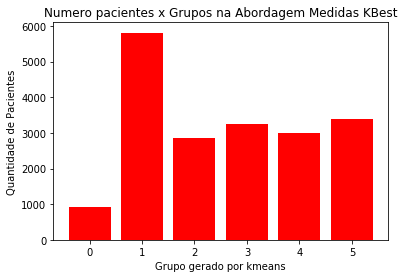

In [87]:
#base para modelo
classes = []
qtds = []

contagem_medidas = Counter(grupos_medidas)

for i in range(0,medidas_kbest):
    classes.append(i)
    qtds.append(contagem_medidas[i])

plt.bar(classes,qtds,color="red")
plt.xticks(classes)
plt.ylabel('Quantidade de Pacientes')
plt.xlabel('Grupo gerado por kmeans')
plt.title('Numero pacientes x Grupos na Abordagem Medidas KBest')
fig = plt.gcf()
fig.savefig(DIR_KMEANS / 'graficos' / 'grafico_Random_Abordagem2_medidasKBest_por_grupos.svg',format="svg")
plt.show()

## Train, Test, Validation for KBest

In [88]:
# Separa o grupo de dados para treino e teste
#separar train(75%) - 14.485, test (10%) - 7.726  and validation (15%) - 11.588

train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

# Feature Selection: SelectKBest
x_train, x_test, y_train, y_test = train_test_split(medidas_mais_importantes_ml, grupos_medidas, test_size=1 - train_ratio,random_state=42)

# Feature Selection: SelectKBest
x_val, x_test, y_val, y_test = train_test_split(medidas_mais_importantes_ml, grupos_medidas, test_size=test_ratio/(test_ratio + validation_ratio),random_state=42)


# Feature Selection: SelectKBest sem validação
#X_train, X_test, y_train, y_test = train_test_split(features_mais_importante_ml, grupos, test_size=0.15, random_state=0)

#X_train.shape, y_train.shape

#X_test.shape, y_test.shape

# Feature Selection: Cross Validation
#clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
#clf.score(X_test, y_test)

In [89]:
# Aplicação do modelo Random Forest no conjunto de dados de treino
random_forest.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

#### Abordagem 2.2: VALIDAÇÃO

In [90]:
#calcular acuracia, recall e f1
y_prev_val = random_forest.predict(x_val)

accuracy = accuracy_score(y_val, y_prev_val)
recall = recall_score(y_val, y_prev_val,average='macro')
f1 = f1_score(y_val, y_prev_val,average='macro')

print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

Accuracy: 1.0 - Recall: 1.0 - F1 Score: 1.0


In [91]:
#Matriz de Confusão
mat=list(confusion_matrix(y_val, y_prev_val, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

0     1     2     3     4     5
0  562     0     0     0     0     0
1    0  3494     0     0     0     0
2    0     0  1765     0     0     0
3    0     0     0  1987     0     0
4    0     0     0     0  1768     0
5    0     0     0     0     0  1969

#### Abordagem 2.2: TESTE

In [92]:
#calcular acuracia, recall e f1
y_prev_test = random_forest.predict(x_test)

accuracy = accuracy_score(y_test, y_prev_test)
recall = recall_score(y_test, y_prev_test,average='macro')
f1 = f1_score(y_test, y_prev_test,average='macro')

print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

Accuracy: 0.9668702091724048 - Recall: 0.9653448215370318 - F1 Score: 0.9673199738467234


In [93]:
#Matriz de Confusão
mat=list(confusion_matrix(y_test, y_prev_test, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

0     1     2     3     4     5
0  353     0    12     0     0     0
1    0  2271     0    14    21    12
2    6     0  1060    10     0    17
3    0    26    10  1204     0    24
4    0    44     0     0  1187     0
5    0    15    18    26     0  1367

####  Abordagem 2.2: Importância das Features Random Forest

In [94]:
#calculo da importancia de cada variavel para idenficar os grupos com 3 casas decimais

# Importância para SelctKBest
importancia_medidas = pd.DataFrame({'features':ls_medidas_kbest,'importance':np.round(random_forest.feature_importances_,3)})

importancia_medidas = importancia_medidas.sort_values('importance',ascending=False)

importancia_medidas.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'importancia_kbest_medidas.csv', 
             sep=';',index=False,encoding='UTF-8')

importancia_medidas

features  importance
3  sist 6:30       0.212
1  sist 6:00       0.208
5  sist 7:00       0.172
6  sist 7:15       0.129
2  sist 6:15       0.104
4  sist 6:45       0.099
0  sist 5:30       0.076

# Abordagem 3: Estatísticas como entrada

In [95]:
#selecionando variaveis estatisticas


ls_estatistica = [
    'Media Sistolica em 24h',
#    'Media Diastolica em 24h',
#    'Media Sistolica Diurna',
#    'Media Sistolica Matutina',
#    'Media Sistolica Vespertina',
#    'Media Sistolica Daytime',
#    'Media Sistolica Nighttime',
#    'Media Diastolica Diurna',
#    'Media Diastolica Matutina',
#    'Media Diastolica Vespertina',
#    'Media Diastolica Daytime',
#    'Media Diastolica Nighttime',
#    'Variancia Sistolica em 24h',
#    'Variancia Diastolica em 24h',
#    'Mediana Sistolica em 24h',
#    'Mediana Diastolica em 24h',
    'AUC Sistolica em 24h',
    'AUC Diastolica em 24h',
    'AUC PP Daytime',
#    'AUC PP Nighttime',
#    'DP Sistolica em 24h',
#    'DP Diastolica em 24h',
]

dados_estatistica =  dataset_estatistica[ls_estatistica]

In [96]:
#tratar nulos
dados_estatistica_sem_nan = dados_estatistica.fillna(0)

## Abordagem 3: Número de Clusters gerado pelo k-Means

In [97]:
#calculando a quantidade ótima de clusters (é possivel dividir os pacientes em quantos grupos)
%time sum_of_squares = calculate_wcss(dados_estatistica_sem_nan)
n = optimal_number_of_clusters(sum_of_squares)
print (n)

Wall time: 34.8 s
7


In [98]:
#convertendo os dados para a clusterização
X = np.array(dados_estatistica_sem_nan)

In [99]:
#habilitando o kmeans com 7 grupos (foi calculado na etapa anterior)
kmeans = KMeans(n_clusters=n, random_state=42).fit(X)

In [100]:
#listar os grupos 
grupos = kmeans.fit_predict(X)

In [101]:
#incluir grupos nos dados de sist e diast
dados_estatistica_sem_nan['grupo'] = grupos
dados_estatistica_sem_nan['grupo'] = dados_estatistica_sem_nan['grupo'] + 1

##   Abordagem 3: Método Elbow 

###  Esse método para calcular o melhor número de cluster para o algoritmo e mostar o gráfico
###  https://minerandodados.com.br/algoritmo-k-means-python-passo-passo/#:~:text=O%20m%C3%A9todo%20Elbow%20se%20trata,um%20valor%20significativo%20de%20ganho.

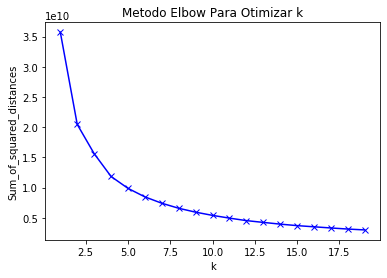

In [102]:
#metodo Elbow
Sum_of_squared_distances = []
K = range(1,20)

for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Metodo Elbow Para Otimizar k')
fig = plt.gcf() 
fig.savefig( DIR_KMEANS / 'graficos' / f'metodoelbow_estatistica.svg', format="svg")
plt.show()



## Abordagem 3: Silhouette

####  A análise da Silhouette pode ser usada para determinar o grau de separação entre os clusters. O coeficiente de Silhouette quando próximo de +1, indica que os pontos estão muito longe dos pontos do outro cluster, e quando próximo de 0, indica que os pontos então muito perto ou até interseccionando um outro cluster

Para n_clusters = 2 O score_silhouette medio e : 0.38513090306026887
Para n_clusters = 3 O score_silhouette medio e : 0.3262308332383108
Para n_clusters = 4 O score_silhouette medio e : 0.35046788484192215
Para n_clusters = 5 O score_silhouette medio e : 0.32604693975878896
Para n_clusters = 6 O score_silhouette medio e : 0.32642228672860985
Para n_clusters = 7 O score_silhouette medio e : 0.32254380436763713


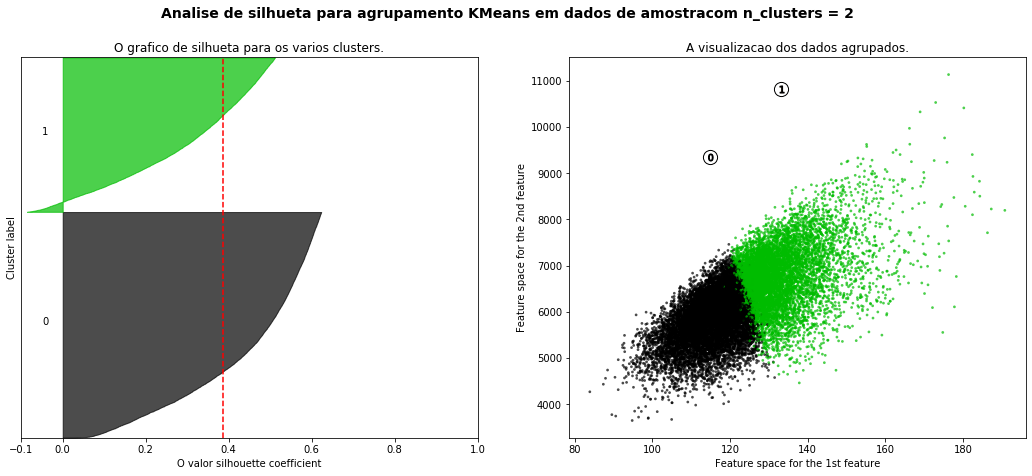

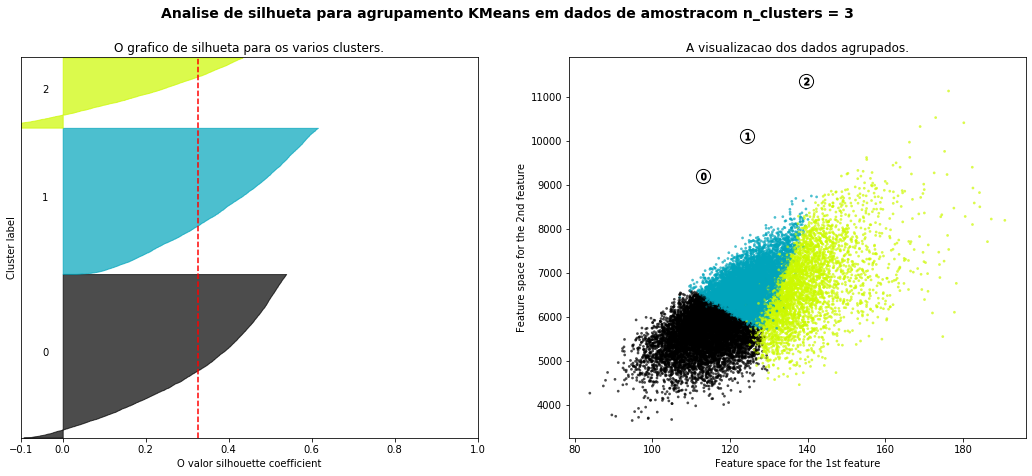

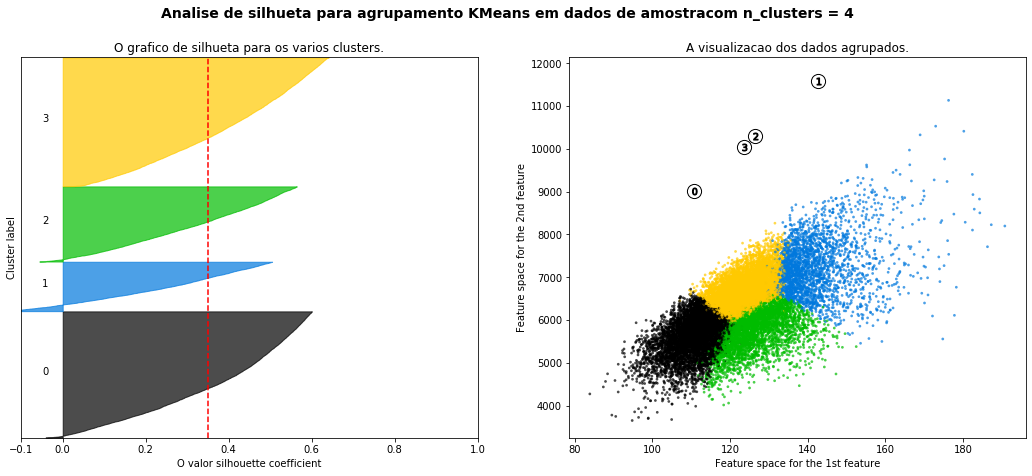

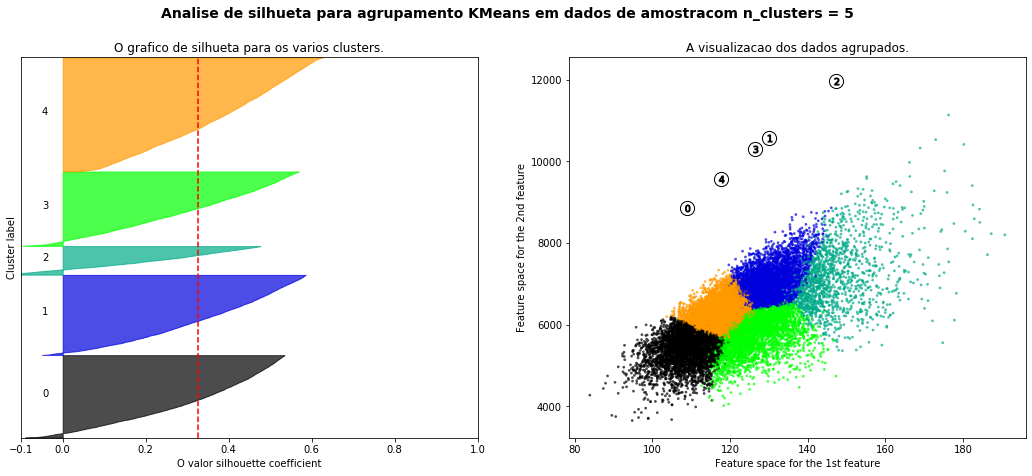

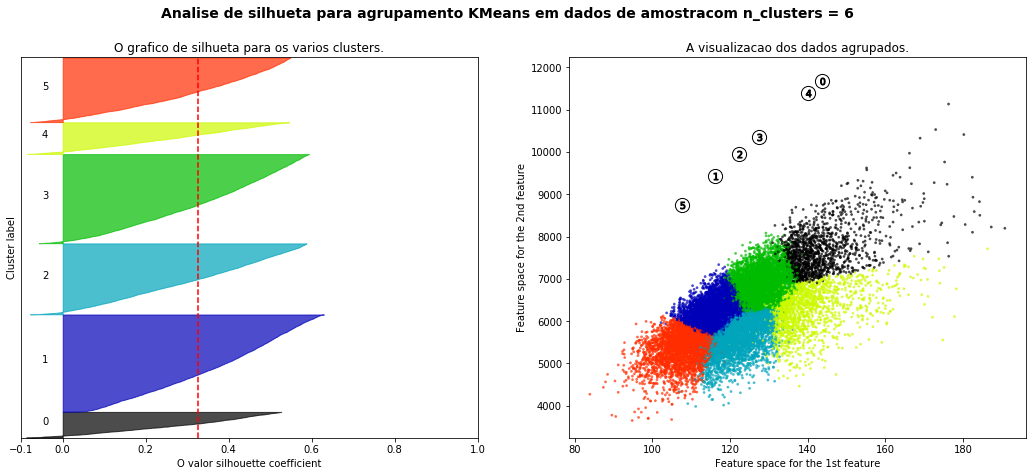

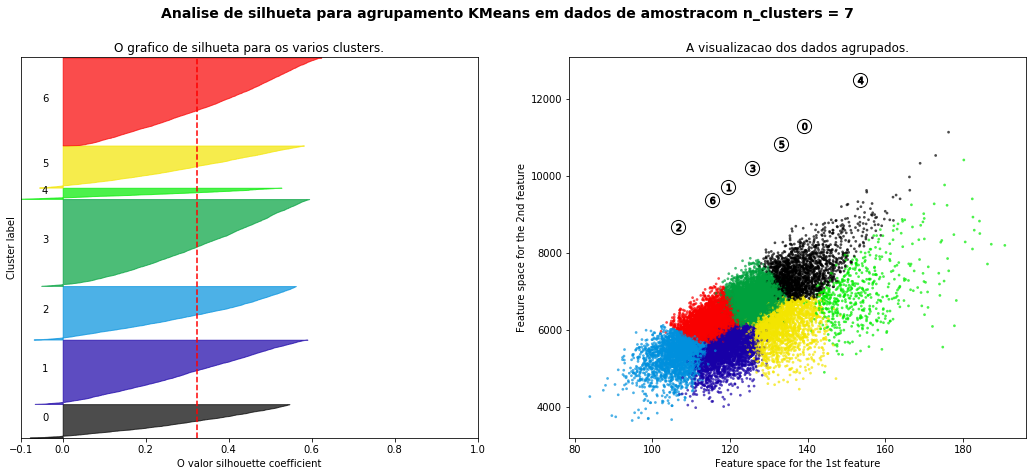

In [103]:
#Silhouette
range_n_clusters = [2, 3, 4, 5, 6, 7]
for n_clusters in range_n_clusters:    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    # O 1st subplot é o grafico silhouette
    # O coeficiente silhouette  um range de -1, 1 but in this example all
    # Os exemplos vão ficar em [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # O (n_clusters + 1) * 10 é para inserir um espaço em branco entre a silhueta
    # Para gerar destaque
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    # Inicialize o clusterer com o valor n_clusters e um valor aleatorio
    # seed 10.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
# O silhouette_score fornece o valor médio para todas as amostras.
    # Isso dá uma perspectiva sobre a densidade e separação das formas
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("Para n_clusters =", n_clusters,
          "O score_silhouette medio e :", silhouette_avg)
    # Calcule as pontuações da silhueta para cada amostra
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        # Agregue as pontuações de silhueta para amostras pertencentes a
        # cluster i, e classifica-los
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color,       alpha=0.7)
        # Rotule os gráficos de silhueta com seus números de cluster no meio
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        # Calcule o novo y_lower para o próximo gráfico
        y_lower = y_upper + 10  #10 para as 0 amostras
    ax1.set_title("O grafico de silhueta para os varios clusters.")
    ax1.set_xlabel("O valor silhouette coefficient")
    ax1.set_ylabel("Cluster label")
    # A linha vertical para a pontuação média da silhueta de todos os valores
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])  # Limpar os yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    # 2º gráfico mostrando os clusters reais formados
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 2], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
    # Labeling dos clusters
    centers = clusterer.cluster_centers_
    # Desenhe círculos brancos nos centros do cluster
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')
    ax2.set_title("A visualizacao dos dados agrupados.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")
    plt.suptitle(("Analise de silhueta para agrupamento KMeans em dados de amostra"
                  "com n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    fig = plt.gcf()
    fig.savefig( DIR_KMEANS / 'graficos' / f'metodosilhouette_estatistica_{n_clusters}.svg', format="svg")
    #fig.savefig('estatisticas/estatisticas_kmeans_'+str(n_clusters)+'.png', format='png')

plt.show()

#fig.savefig('kmeans_estatisticas.png', format='png')

In [104]:
#dataset com grupos e por estatisticas

dataset_estatistica = dataset_apos_tratamento.loc[:,'numero_identificacao':'IMC']
#############################################################################################
#dataset_estatistica = dataset_apos_tratamento.loc[:,'numero_identificacao':'altura']
#dataset_estatistica['IMC'] = dataset_medidas['IMC']
dataset_estatistica['grupo'] = grupos
dataset_estatistica = pd.concat([dataset_estatistica,dataset_apos_tratamento.loc[:,'sist 9:00':'Picos Diastolica']],axis=1)

dataset_estatistica.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'mapa_apos_kmeans_estatistica.csv', 
             sep=';',index=False,encoding='UTF-8')


### Abordagem 3: Random Forest

In [105]:
from sklearn.ensemble import RandomForestClassifier

In [106]:
#parametro simples do modelo
random_forest = RandomForestClassifier(n_estimators=50)

In [107]:
#base para modelo

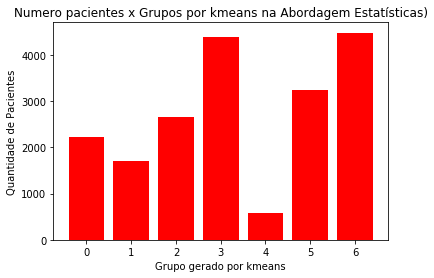

In [108]:
classes = []
qtds = []

contagem = Counter(grupos)

for i in range(0,n):
    classes.append(i)
    qtds.append(contagem[i])

plt.bar(classes,qtds,color="red")
plt.xticks(classes)
plt.ylabel('Quantidade de Pacientes')
plt.xlabel('Grupo gerado por kmeans')
plt.title('Numero pacientes x Grupos por kmeans na Abordagem Estatísticas)')
fig = plt.gcf()
fig.savefig(DIR_KMEANS / 'graficos' / 'grafico_Random_Abordagem2_estatistica_por_grupos.svg',format="svg")
plt.show()

In [109]:
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

#separar train(75%) - 14.485, test (10%) - 7.726  and validation (15%) - 11.588
x_train, x_test, y_train, y_test = train_test_split(X, grupos, test_size=1 - train_ratio,random_state=42)
x_val, x_test, y_val, y_test = train_test_split(X, grupos, test_size=test_ratio/(test_ratio + validation_ratio),random_state=42)

In [110]:
#treino
random_forest.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

#### Abordagem 3: VALIDAÇÃO

In [111]:
#calcular acuracia, recall e f1
y_prev_val = random_forest.predict(x_val)

accuracy = accuracy_score(y_val, y_prev_val)
recall = recall_score(y_val, y_prev_val,average='macro')
f1 = f1_score(y_val, y_prev_val,average='macro')

In [112]:
print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

Accuracy: 1.0 - Recall: 1.0 - F1 Score: 1.0


In [113]:
#Matriz da Confusão
mat=list(confusion_matrix(y_val, y_prev_val, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

0     1     2     3    4     5     6
0  1314     0     0     0    0     0     0
1     0  1062     0     0    0     0     0
2     0     0  1563     0    0     0     0
3     0     0     0  2615    0     0     0
4     0     0     0     0  345     0     0
5     0     0     0     0    0  1974     0
6     0     0     0     0    0     0  2672

#### Abordagem 3: TESTE

In [114]:
#calcular acuracia, recall e f1
y_prev_test = random_forest.predict(x_test)

accuracy = accuracy_score(y_test, y_prev_test)
recall = recall_score(y_test, y_prev_test,average='macro')
f1 = f1_score(y_test, y_prev_test,average='macro')

In [115]:
print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

Accuracy: 0.9892165778874886 - Recall: 0.9854510057619567 - F1 Score: 0.9874751430209895


In [116]:
#Matriz da Confusão
mat=list(confusion_matrix(y_test, y_prev_test, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

0    1     2     3    4     5     6
0  898    2     0     4    0    10     0
1    0  636     0     1    0     0     0
2    0    0  1072     0    0    10     5
3    3    6     0  1751    0     1    10
4    5    5     0     0  218     0     0
5    4    0     0     2    0  1248     3
6    0    0     3     6    0     3  1791

In [117]:
#salvar dataframe numero_paciente, grupo_real, grupo, previsto validação
x_train_, x_test_, y_train_, y_test_ = train_test_split(dataset_estatistica, grupos, test_size=1 - train_ratio, random_state=42)
x_val_, x_test_, y_val_, y_test_ = train_test_split(dataset_estatistica, grupos, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42)

#validacao
pacientes_validacao_estatistica = x_val_[['numero_identificacao']]
pacientes_validacao_estatistica['Grupo_Real'] = y_val_
pacientes_validacao_estatistica['Grupo_Previsto'] = y_prev_val
pacientes_validacao_estatistica.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'pacientes_validacao_estatistica.csv', 
             sep=';',index=False,encoding='UTF-8')


#teste
pacientes_teste_estatistica = x_test_[['numero_identificacao']]
pacientes_teste_estatistica['Grupo_Real'] = y_test_
pacientes_teste_estatistica['Grupo_Previsto'] = y_prev_test
pacientes_teste_estatistica.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'pacientes_teste_estatistica.csv', 
             sep=';',index=False,encoding='UTF-8')


c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

#### Abordagem 3: Importância das Features Random Forest

In [118]:
#calculo da importancia de cada variavel para idenficar os grupos com 3 casas decimais
importancia = pd.DataFrame({'features':ls_estatistica,'importance':np.round(random_forest.feature_importances_,3)})
importancia = importancia.sort_values('importance',ascending=False)

importancia.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'importancia_features_estatistica.csv', 
             sep=';',index=False,encoding='UTF-8')

importancia

features  importance
1    AUC Sistolica em 24h       0.321
2   AUC Diastolica em 24h       0.273
3          AUC PP Daytime       0.217
0  Media Sistolica em 24h       0.189

# Abordagem 4: Padrão de Doenças

In [119]:
#selecionando padrões de doencas

ls_padroes_doencas = ['Hipotensao', 'Sistolica Isolada', 'Diastolica Isolada', 'Dipping',
       'Non Dipping', 'Extreme Dipping', 'Reverse Dipping', 'Morning Surge',
       'Masked', 'Whitecoat', 'Normotenso']

dados_padrao_doencas =  dataset_apos_tratamento[ls_padroes_doencas]

In [120]:
dados_padrao_doencas[dados_padrao_doencas['Non Dipping'] == True]

Hipotensao  Sistolica Isolada  Diastolica Isolada  Dipping  \
2            True              False               False    False   
5            True              False               False    False   
6            True              False               False    False   
7            True              False               False    False   
8            True              False               False    False   
...           ...                ...                 ...      ...   
19230        True              False               False    False   
19231        True              False               False    False   
19233        True              False               False    False   
19238        True              False               False    False   
19239        True              False               False    False   

       Non Dipping  Extreme Dipping  Reverse Dipping  Morning Surge  Masked  \
2             True            False            False          False   False   
5             True            False            False          False   False   
6             True            False            False          False   False   
7             True            False            False          False   False   
8             True            False            False          False   False   
...            ...              ...              ...            ...     ...   
19230         True            False            False          False   False   
19231         True            False            False          False   False   
19233         True            False            False          False   False   
19238         True            False            False          False   False   
19239         True            False            False          False   False   

       Whitecoat  Normotenso  
2           True       False  
5           True       False  
6           True       False  
7          False       False  
8          False       False  
...          ...         ...  
19230       True       False  
19231       True       False  
19233       True       False  
19238       True       False  
19239       True       False  

[8727 rows x 11 columns]

In [121]:
#tratar nulos
dados_padrao_doencas_sem_nan = dados_padrao_doencas.fillna(0)
dados_padrao_doencas_sem_nan

Hipotensao  Sistolica Isolada  Diastolica Isolada  Dipping  \
0            True              False               False    False   
1            True              False               False    False   
2            True              False               False    False   
3            True              False               False     True   
4            True              False               False     True   
...           ...                ...                 ...      ...   
19237        True              False               False     True   
19238        True              False               False    False   
19239        True              False               False    False   
19240        True              False               False    False   
19241        True              False               False    False   

       Non Dipping  Extreme Dipping  Reverse Dipping  Morning Surge  Masked  \
0            False            False             True          False   False   
1            False            False             True          False   False   
2             True            False            False          False   False   
3            False            False            False          False   False   
4            False            False            False          False   False   
...            ...              ...              ...            ...     ...   
19237        False            False            False           True   False   
19238         True            False            False          False   False   
19239         True            False            False          False   False   
19240        False             True            False          False   False   
19241        False            False             True          False   False   

       Whitecoat  Normotenso  
0          False       False  
1          False       False  
2           True       False  
3           True       False  
4          False       False  
...          ...         ...  
19237       True       False  
19238       True       False  
19239       True       False  
19240      False       False  
19241       True       False  

[19242 rows x 11 columns]

In [122]:
#trocar nulos do dataframe
d_p_d = dados_padrao_doencas
dados_padrao_doencas

Hipotensao  Sistolica Isolada  Diastolica Isolada  Dipping  \
0            True              False               False    False   
1            True              False               False    False   
2            True              False               False    False   
3            True              False               False     True   
4            True              False               False     True   
...           ...                ...                 ...      ...   
19237        True              False               False     True   
19238        True              False               False    False   
19239        True              False               False    False   
19240        True              False               False    False   
19241        True              False               False    False   

       Non Dipping  Extreme Dipping  Reverse Dipping  Morning Surge  Masked  \
0            False            False             True          False   False   
1            False            False             True          False   False   
2             True            False            False          False   False   
3            False            False            False          False   False   
4            False            False            False          False   False   
...            ...              ...              ...            ...     ...   
19237        False            False            False           True   False   
19238         True            False            False          False   False   
19239         True            False            False          False   False   
19240        False             True            False          False   False   
19241        False            False             True          False   False   

       Whitecoat  Normotenso  
0          False       False  
1          False       False  
2           True       False  
3           True       False  
4          False       False  
...          ...         ...  
19237       True       False  
19238       True       False  
19239       True       False  
19240      False       False  
19241       True       False  

[19242 rows x 11 columns]

In [123]:
##############################################################################################################
#Trocar True e False para 1 e 0
#d_p_d['Hipotensao'] = d_p_d['Hipotensao'].apply(verdadeiro_falso)
#d_p_d['Sistolica Isolada'] = d_p_d['Sistolica Isolada'].apply(verdadeiro_falso)
#d_p_d['Diastolica Isolada'] = d_p_d['Diastolica Isolada'].apply(verdadeiro_falso)
#d_p_d['Dipping'] = d_p_d['Dipping'].apply(verdadeiro_falso)
#d_p_d['Non Dipping'] = d_p_d['Non Dipping'].apply(verdadeiro_falso)
#d_p_d['Extreme Dipping'] = d_p_d['Extreme Dipping'].apply(verdadeiro_falso)
#d_p_d['Reverse Dipping'] = d_p_d['Reverse Dipping'].apply(verdadeiro_falso)
#d_p_d['Morning Surge'] = d_p_d['Morning Surge'].apply(verdadeiro_falso)
#d_p_d['Masked'] = d_p_d['Masked'].apply(verdadeiro_falso)
#d_p_d['Whitecoat'] = d_p_d['Whitecoat'].apply(verdadeiro_falso)
#d_p_d['Normotenso'] = d_p_d['Normotenso'].apply(verdadeiro_falso)

##  Abordagem 4: Número de Clusters gerado pelo k-Means

In [124]:
#calculando a quantidade ótima de clusters (é possivel dividir os pacientes em quantos grupos)
sum_of_squares = calculate_wcss(d_p_d)
n = optimal_number_of_clusters(sum_of_squares)
print (n)

8


In [125]:
kmeans

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [126]:
#convertendo os dados para entrga ao Random - Classifcação
X = np.array(d_p_d)

In [127]:
#   habilitando o k-means com "optimal_number_of_clusters" grupos (calculado na etapa anterior)

kmeans = KMeans(n_clusters=n, random_state=42).fit(X)


In [128]:
#listar os grupos 

grupos = kmeans.fit_predict(X)


In [129]:
grupos

array([2, 2, 0, ..., 0, 6, 2])

In [130]:
set(grupos)

{0, 1, 2, 3, 4, 5, 6, 7}

##   Abordagem 4: Método Elbow 

###  Método de cálculo do melhor número de cluster para o algoritmo e plota o gráfico

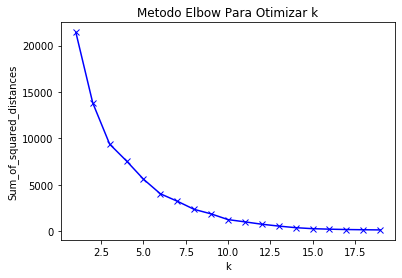

In [131]:
#metodo Elbow
Sum_of_squared_distances = []
K = range(1,20)

for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Metodo Elbow Para Otimizar k')
fig = plt.gcf()
fig.savefig( DIR_KMEANS / 'graficos' / f'metodoelbow_doenca.svg', format="svg")
plt.show()

## Abordagem 4: Silhouette

####  A análise da Silhouette pode ser usada para determinar o grau de separação entre os clusters. O coeficiente de Silhouette quando próximo de +1, indica que os pontos estão muito longe dos pontos do outro cluster, e quando próximo de 0, indica que os pontos então muito perto ou até interseccionando um outro cluster

Para n_clusters = 2 O score_silhouette medio e : 0.4171525768720948
Para n_clusters = 3 O score_silhouette medio e : 0.526652250779759
Para n_clusters = 4 O score_silhouette medio e : 0.5848841157511604
Para n_clusters = 5 O score_silhouette medio e : 0.6559234631454401
Para n_clusters = 6 O score_silhouette medio e : 0.6954211078587864
Para n_clusters = 7 O score_silhouette medio e : 0.7505080881487869
Para n_clusters = 8 O score_silhouette medio e : 0.8152129624791085


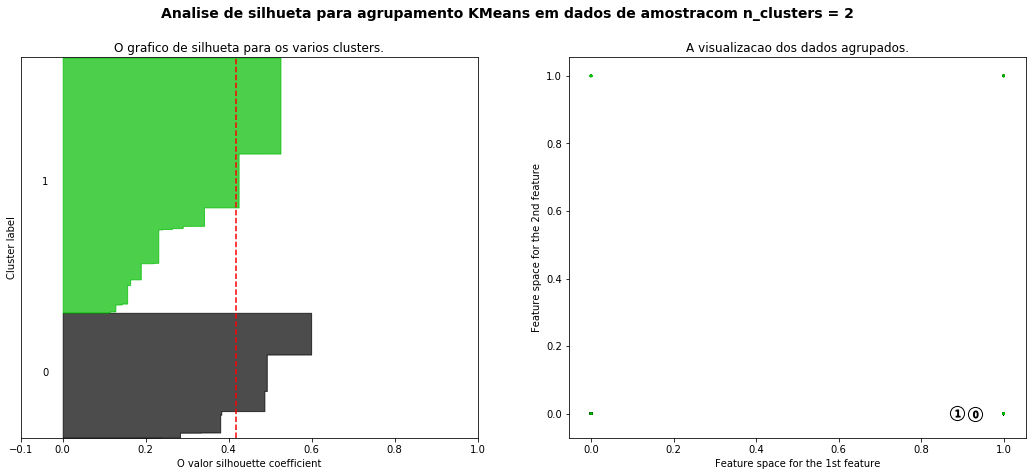

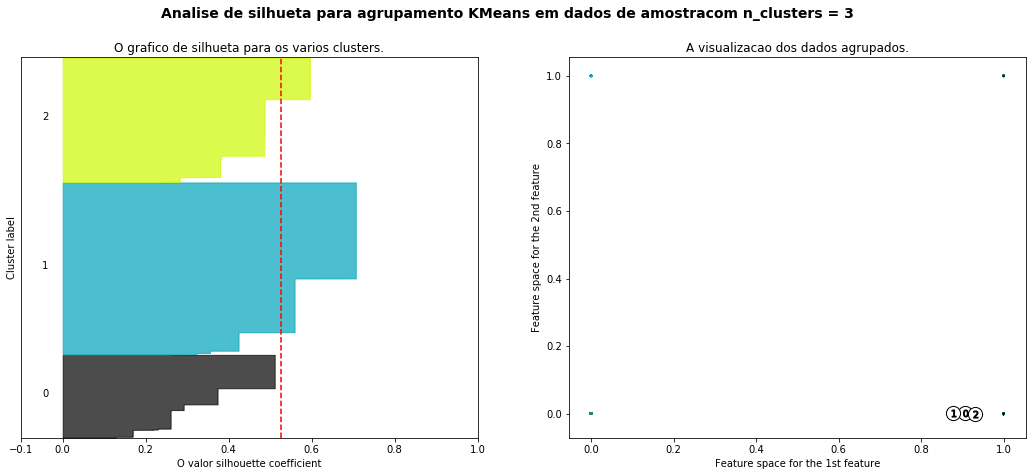

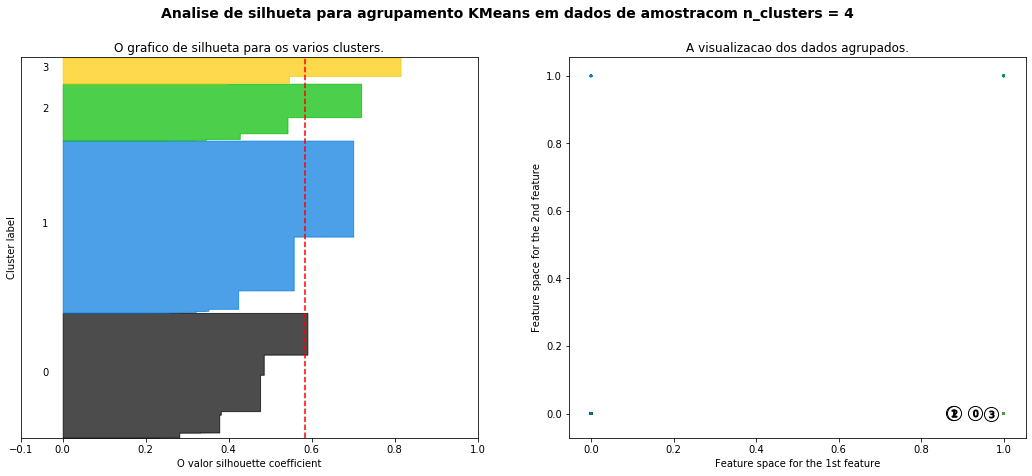

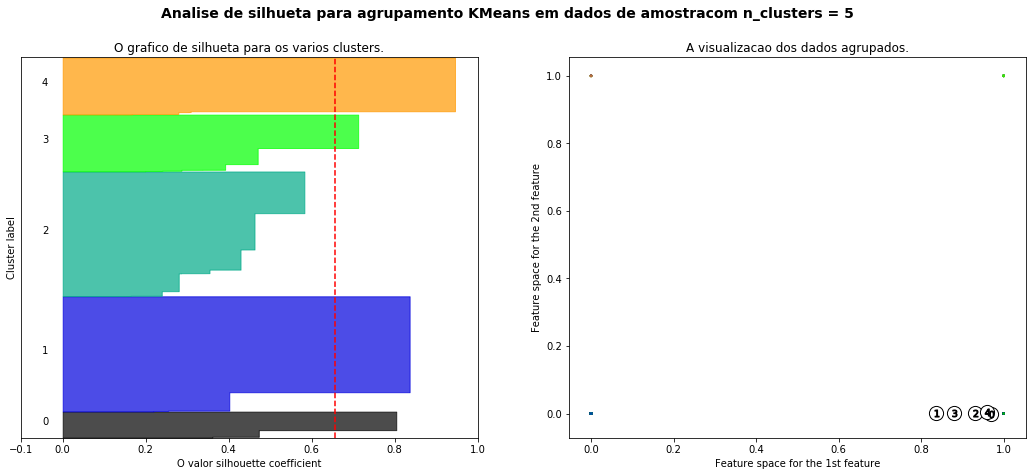

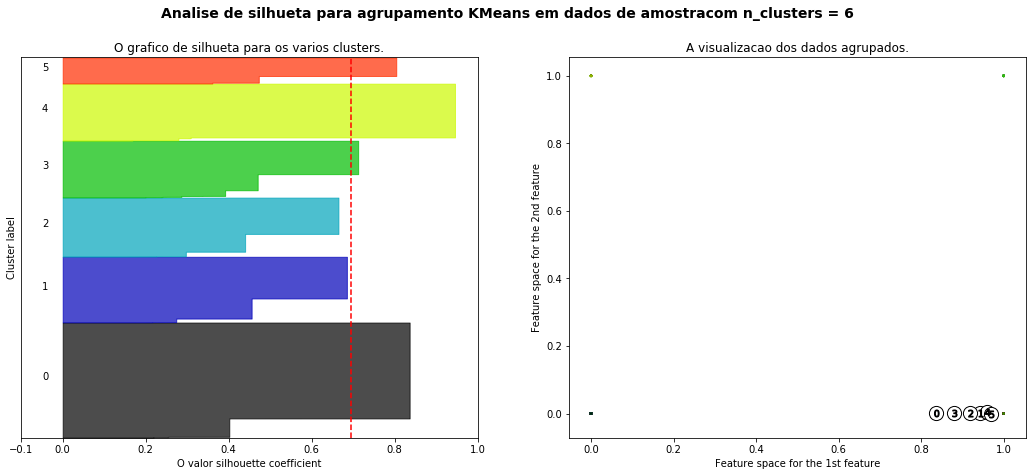

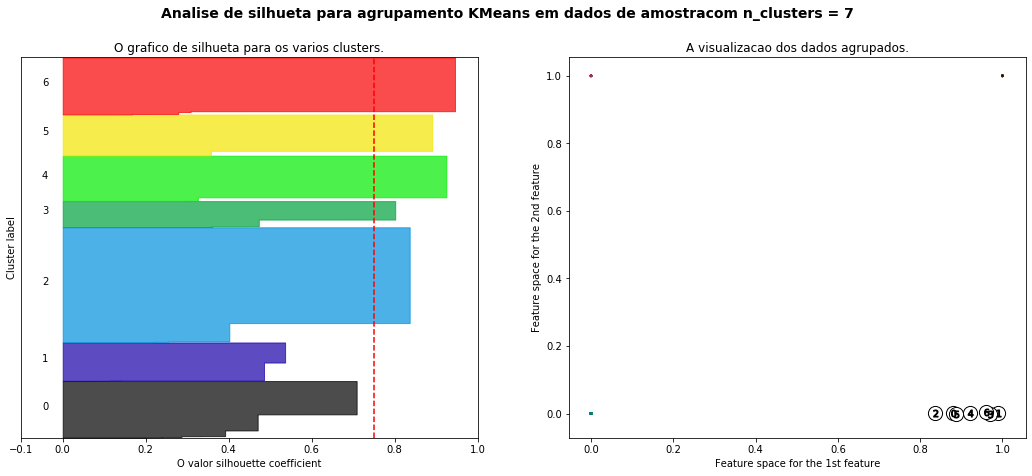

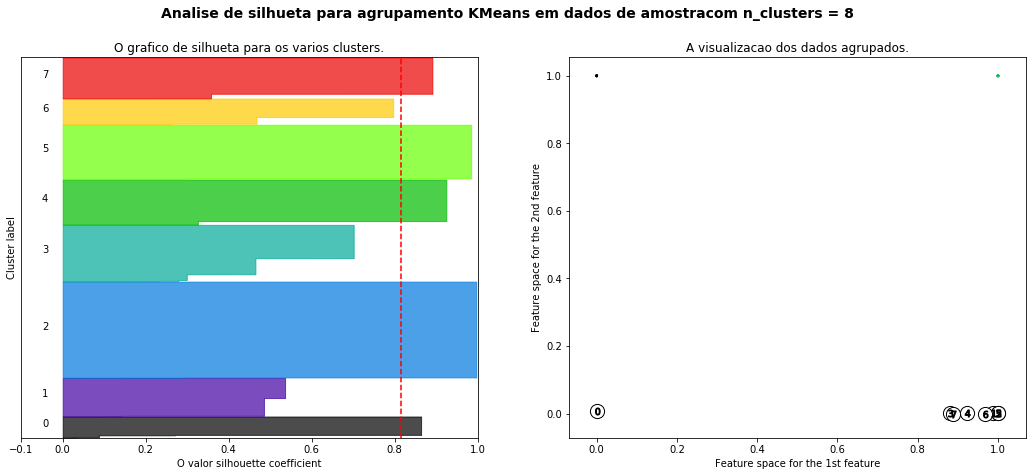

In [132]:
#Silhouette
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for n_clusters in range_n_clusters:    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    # O 1st subplot é o grafico silhouette
    # O coeficiente silhouette  um range de -1, 1 but in this example all
    # Os exemplos vão ficar em [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # O (n_clusters + 1) * 10 é para inserir um espaço em branco entre a silhueta
    # Para gerar destaque
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    # Inicialize o clusterer com o valor n_clusters e um valor aleatorio
    # seed 10.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
# O silhouette_score fornece o valor médio para todas as amostras.
    # Isso dá uma perspectiva sobre a densidade e separação das formas
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("Para n_clusters =", n_clusters,
          "O score_silhouette medio e :", silhouette_avg)
    # Calcule as pontuações da silhueta para cada amostra
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        # Agregue as pontuações de silhueta para amostras pertencentes a
        # cluster i, e classifica-los
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color,       alpha=0.7)
        # Rotule os gráficos de silhueta com seus números de cluster no meio
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        # Calcule o novo y_lower para o próximo gráfico
        y_lower = y_upper + 10  #10 para as 0 amostras
    ax1.set_title("O grafico de silhueta para os varios clusters.")
    ax1.set_xlabel("O valor silhouette coefficient")
    ax1.set_ylabel("Cluster label")
    # A linha vertical para a pontuação média da silhueta de todos os valores
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])  # Limpar os yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    # 2º gráfico mostrando os clusters reais formados
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
    # Labeling dos clusters
    centers = clusterer.cluster_centers_
    # Desenhe círculos brancos nos centros do cluster
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')
    ax2.set_title("A visualizacao dos dados agrupados.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")
    plt.suptitle(("Analise de silhueta para agrupamento KMeans em dados de amostra"
                  "com n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    fig = plt.gcf()
    fig.savefig( DIR_KMEANS / 'graficos' / f'metodosilhouette_doenca_{n_clusters}.svg', format="svg")
    #fig.savefig('padrao_doencas/padrao_doencas_kmeans_'+str(n_clusters)+'.png', format='png')  

plt.show()

#fig.savefig('kmeans_padroes_doencas.png', format='png')

In [133]:
#dataset com grupos e por padrão de doencas

dataset_padrao_doenca = dataset_apos_tratamento.loc[:,'numero_identificacao':'IMC']
#dataset_padrao_doenca = dataset_apos_tratamento.loc[:,'numero_identificacao':'altura']
#dataset_padrao_doenca['IMC'] = dataset_medidas['IMC']
dataset_padrao_doenca['grupo'] = grupos
dataset_padrao_doenca['grupo'] = dataset_padrao_doenca['grupo'] + 1

dataset_padrao_doenca = pd.concat([dataset_padrao_doenca,dataset_apos_tratamento.loc[:,'sist 9:00':'Picos Diastolica']],axis=1)

dataset_padrao_doenca.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'mapa_apos_kmeans_doenca.csv', 
             sep=';',index=False,encoding='UTF-8')

In [134]:
dados_padrao_doencas

Hipotensao  Sistolica Isolada  Diastolica Isolada  Dipping  \
0            True              False               False    False   
1            True              False               False    False   
2            True              False               False    False   
3            True              False               False     True   
4            True              False               False     True   
...           ...                ...                 ...      ...   
19237        True              False               False     True   
19238        True              False               False    False   
19239        True              False               False    False   
19240        True              False               False    False   
19241        True              False               False    False   

       Non Dipping  Extreme Dipping  Reverse Dipping  Morning Surge  Masked  \
0            False            False             True          False   False   
1            False            False             True          False   False   
2             True            False            False          False   False   
3            False            False            False          False   False   
4            False            False            False          False   False   
...            ...              ...              ...            ...     ...   
19237        False            False            False           True   False   
19238         True            False            False          False   False   
19239         True            False            False          False   False   
19240        False             True            False          False   False   
19241        False            False             True          False   False   

       Whitecoat  Normotenso  
0          False       False  
1          False       False  
2           True       False  
3           True       False  
4          False       False  
...          ...         ...  
19237       True       False  
19238       True       False  
19239       True       False  
19240      False       False  
19241       True       False  

[19242 rows x 11 columns]

# Abordagem 4.1: Features Selection: Kbest  na Abordagem 4: Doenças

In [135]:
#  Uso do SelectKBest para identificar as melhores 5 features

from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, chi2

features_mais_importante_ml = SelectKBest(chi2, k=5).fit_transform(X, grupos)
features_mais_importante_ml.shape

(19242, 5)

In [136]:
# Transforma a variável acima em dataframe para automatizar a identificação de quais colunas foram escolhidas

features_mais_importante = pd.DataFrame(features_mais_importante_ml)


In [137]:
# identificação de quais colunas foram escolhidas

lista_colunas_escolhidas = []
# X é o dataset das doenças que precisa ser transformado em df
x_df = pd.DataFrame(X)
for coluna_ml in range(len(features_mais_importante.columns)):
    for coluna_base in range(len(x_df.columns)):
        # para identificar valores únicos
        if set(np.array(x_df[coluna_base]) == np.array(features_mais_importante[coluna_ml])) == {True}:
            lista_colunas_escolhidas.append(coluna_base)
            break

lista_colunas_escolhidas

# Foram escolhidas as colunas 'Diastolica Isolada', 'Dipping','Non Dipping', 'Extreme Dipping', 'Reverse Dipping'

[3, 4, 5, 6, 7]

In [138]:
#selecionando padrões de doencas

ls_doencas_kbest = ['Diastolica Isolada', 'Dipping',
       'Non Dipping', 'Extreme Dipping', 'Reverse Dipping']

#ls_doencas_kbest = ['Hipotensao', 'Sistolica Isolada', 'Diastolica Isolada', 'Dipping',
#       'Non Dipping', 'Extreme Dipping', 'Reverse Dipping', 'Morning Surge',
#       'Masked', 'Whitecoat', 'Normotenso']

dados_padrao_doencas_kbest =  dataset_apos_tratamento[ls_doencas_kbest]

## Abordagem 4.1:  K-means para SelectKbest

In [139]:
#  Cálculo do "n_clusters" considerando as colunas definidas por SelectKBest

sum_of_squares = calculate_wcss(features_mais_importante_ml)
n_kbest = optimal_number_of_clusters(sum_of_squares)
kmeans = KMeans(n_clusters=n_kbest, random_state=42).fit(features_mais_importante_ml)
grupos = kmeans.fit_predict(features_mais_importante_ml)
print(n)
print(grupos)

c:\users\marta\anaconda3\envs\emoti\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  return_n_iter=True)
c:\users\marta\anaconda3\envs\emoti\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return_n_iter=True)
c:\users\marta\anaconda3\envs\emoti\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  return_n_iter=True)
c:\users\marta\anaconda3\envs\emoti\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return_n_iter=True)
c:\users\marta\anaconda3\envs\emoti\lib\site-packages\sklea

8
[3 3 1 ... 1 0 3]


c:\users\marta\anaconda3\envs\emoti\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (20). Possibly due to duplicate points in X.
  return_n_iter=True)


In [140]:
# Separa o grupo de dados para treino e teste

# Feature Selection: none
#X_train, X_test, y_train, y_test = train_test_split(X, grupos, test_size=0.15, random_state=0)

# Feature Selection: SelectKBest
#X_train, X_test, y_train, y_test = train_test_split(features_mais_importante_ml, grupos, test_size=0.15, random_state=0)
#
#X_train.shape, y_train.shape
#
#X_test.shape, y_test.shape

# Feature Selection: Cross Validation
#clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
#clf.score(X_test, y_test)

###  Abordagem 4.1: Random Forest

In [141]:
from sklearn.ensemble import RandomForestClassifier

In [142]:
#parametro simples do modelo
random_forest = RandomForestClassifier(n_estimators=10)

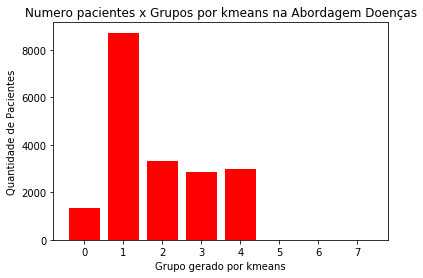

In [143]:
#base para modelo
classes = []
qtds = []

contagem = Counter(grupos)

for i in range(0,n):
    classes.append(i)
    qtds.append(contagem[i])

plt.bar(classes,qtds,color="red")
plt.xticks(classes)
plt.ylabel('Quantidade de Pacientes')
plt.xlabel('Grupo gerado por kmeans')
plt.title('Numero pacientes x Grupos por kmeans na Abordagem Doenças')
fig = plt.gcf()
fig.savefig(DIR_KMEANS / 'graficos' / 'grafico_Random_Abordagem3_doenca_por_grupos.svg',format="svg")
plt.show()

In [144]:
#salvar a imagem
#fig.savefig('padrao_doencas/qtd_x_padrao_doencas.png', format='png')

## Train, Test, Validation

In [145]:
# Separa o grupo de dados para treino e teste
#separar train(75%) - 14.485, test (10%) - 7.726  and validation (15%) - 11.588

train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

# Feature Selection: none
#X_train, X_test, y_train, y_test = train_test_split(X, grupos, test_size=0.15, random_state=42)
#x_train, x_test, y_train, y_test = train_test_split(X, grupos, test_size=1 - train_ratio,random_state=42)

# Feature Selection: SelectKBest
x_train, x_test, y_train, y_test = train_test_split(features_mais_importante_ml, grupos, test_size=1 - train_ratio,random_state=42)

# Feature Selection: none
#x_val, x_test, y_val, y_test = train_test_split(X, grupos, test_size=test_ratio/(test_ratio + validation_ratio),random_state=42)

# Feature Selection: SelectKBest
x_val, x_test, y_val, y_test = train_test_split(features_mais_importante_ml, grupos, test_size=test_ratio/(test_ratio + validation_ratio),random_state=42)


# Feature Selection: SelectKBest sem validação
#X_train, X_test, y_train, y_test = train_test_split(features_mais_importante_ml, grupos, test_size=0.15, random_state=0)

#X_train.shape, y_train.shape

#X_test.shape, y_test.shape

# Feature Selection: Cross Validation
#clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
#clf.score(X_test, y_test)

In [146]:
# Aplicação do modelo Random Forest no conjunto de dados de treino
random_forest.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

#### Abordagem 4.1: VALIDAÇÃO

In [147]:
#calcular acuracia, recall e f1
y_prev_val = random_forest.predict(x_val)

accuracy = accuracy_score(y_val, y_prev_val)
recall = recall_score(y_val, y_prev_val,average='macro')
f1 = f1_score(y_val, y_prev_val,average='macro')

In [148]:
print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

Accuracy: 1.0 - Recall: 1.0 - F1 Score: 1.0


In [149]:
#Matriz de Confusão
mat=list(confusion_matrix(y_val, y_prev_val, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

0     1     2     3     4  5  6  7
0  795     0     0     0     0  0  0  0
1    0  5240     0     0     0  0  0  0
2    0     0  2019     0     0  0  0  0
3    0     0     0  1713     0  0  0  0
4    0     0     0     0  1778  0  0  0
5    0     0     0     0     0  0  0  0
6    0     0     0     0     0  0  0  0
7    0     0     0     0     0  0  0  0

#### Abordagem 4.1: TESTE

In [150]:
#calcular acuracia, recall e f1
y_prev_test = random_forest.predict(x_test)

accuracy = accuracy_score(y_test, y_prev_test)
recall = recall_score(y_test, y_prev_test,average='macro')
f1 = f1_score(y_test, y_prev_test,average='macro')

In [151]:
print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

Accuracy: 1.0 - Recall: 1.0 - F1 Score: 1.0


In [152]:
#Matriz de Confusão
mat=list(confusion_matrix(y_test, y_prev_test, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

0     1     2     3     4  5  6  7
0  525     0     0     0     0  0  0  0
1    0  3487     0     0     0  0  0  0
2    0     0  1308     0     0  0  0  0
3    0     0     0  1161     0  0  0  0
4    0     0     0     0  1216  0  0  0
5    0     0     0     0     0  0  0  0
6    0     0     0     0     0  0  0  0
7    0     0     0     0     0  0  0  0

In [153]:
#salvar dataframe numero_paciente, grupo_real, grupo, previsto validação e teste
x_train_, x_test_, y_train_, y_test_ = train_test_split(dataset_padrao_doenca, grupos, test_size=1 - train_ratio, random_state=42)
x_val_, x_test_, y_val_, y_test_ = train_test_split(dataset_padrao_doenca, grupos, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42)

#validacao
pacientes_validacao_padrao_doencas = x_val_[['numero_identificacao']]
pacientes_validacao_padrao_doencas['Grupo_Real'] = y_val_
pacientes_validacao_padrao_doencas['Grupo_Previsto'] = y_prev_val
pacientes_validacao_padrao_doencas.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'pacientes_validacao_doenca.csv', 
             sep=';',index=False,encoding='UTF-8')

#teste
pacientes_teste_padrao_doencas = x_test_[['numero_identificacao']]
pacientes_teste_padrao_doencas['Grupo_Real'] = y_test_
pacientes_teste_padrao_doencas['Grupo_Previsto'] = y_prev_test
pacientes_teste_padrao_doencas.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'pacientes_teste_doenca.csv', 
             sep=';',index=False,encoding='UTF-8')


c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

####  Abordagem 4.1: Importância das Features Random Forest

In [154]:
#calculo da importancia de cada variavel para idenficar os grupos com 3 casas decimais

#importancia = pd.DataFrame({'features':ls_padroes_doencas,'importance':np.round(random_forest.feature_importances_,3)})

# Importância para SelctKBest
importancia = pd.DataFrame({'features':ls_doencas_kbest,'importance':np.round(random_forest.feature_importances_,3)})

importancia = importancia.sort_values('importance',ascending=False)

importancia.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'importancia_features_doenca.csv', 
             sep=';',index=False,encoding='UTF-8')

importancia

features  importance
1             Dipping       0.259
0  Diastolica Isolada       0.256
4     Reverse Dipping       0.246
3     Extreme Dipping       0.170
2         Non Dipping       0.069

In [155]:
# Troca valores 0 e 1 para F e M 
ajusta_coluna_genero = {"genero": {1: "M", 0:"F"}}
dataset_apos_tratamento = dataset_apos_tratamento.replace(ajusta_coluna_genero)

#  Grava dataset tratado
#dataset_apos_tratamento.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'pacientes_aceitos_apos_tratamento_dados.csv', 
#             sep=';',index=False,encoding='UTF-8')

# Abordagem 5 doença sem extremos (Sem Hipotensão e sem Normotenso)

In [156]:
#   Doenças SEM Hipotensão

ls_doencas = list(dataset_apos_tratamento.loc[:,'Hipotensao':'Whitecoat'].columns)
ls_doencas = ls_doencas[1:]

#  O índice zero é a 1a. coluna de doença que vai até 9 (a última até Whitecoat)
#  Usar esse comando para a abordagem em cada uma das doenças separadamente
#grupos_doenca = np.array(dataset_apos_tratamento[ls_doencas[0]])

#  Usar esse comando para a abordagem de um range de doenças. Aqui não entrou Hipotensão, nem Normotenso
escolho_doenca = np.array(dataset_apos_tratamento[ls_doencas])

In [157]:
#calculando a quantidade ótima de clusters (é possivel dividir os pacientes em quantos grupos)
%time sum_of_squares = calculate_wcss(escolho_doenca)
n = optimal_number_of_clusters(sum_of_squares)
print (n)

#habilitando o kmeans com 7 grupos (foi calculado na etapa anterior)
kmeans = KMeans(n_clusters=n, random_state=42).fit(escolho_doenca)

#listar os grupos 
grupo_escolho_doenca = kmeans.fit_predict(escolho_doenca)

#incluir grupos nos dados de sist e diast

grupo_df = pd.DataFrame()
grupo_df['grupo'] = grupo_escolho_doenca
grupo_df['grupo'] = grupo_df['grupo'] + 1

dados_completos_escolho_doenca = pd.concat([dataset_apos_tratamento.loc[:,:'IMC'],
                                    grupo_df['grupo'],
                                    dataset_apos_tratamento.loc[:,'data_exame':]],
                                   axis=1)

genero_M_F = {"genero": {1: "M", 0: "F"}}

dados_completos_escolho_doenca = dados_completos_escolho_doenca.replace(genero_M_F)

#dados_completos_escolho_doenca = dados_completos_generico
#dados_completos_escolho_doenca['grupo'] = grupo_escolho_doenca
#dados_completos_escolho_doenca['grupo'] = dados_completos_escolho_doenca['grupo'] + 1

Wall time: 3.24 s
7


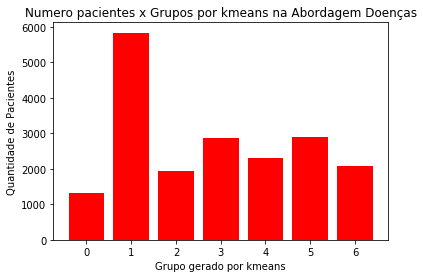

In [158]:
#     Aplicação do RANDOM FOREST

from sklearn.ensemble import RandomForestClassifier

#    Aplicação do modelo com parâmetro simples do modelo
random_forest = RandomForestClassifier(n_estimators=50)

#base para modelo
classes = []
qtds = []

contagem = Counter(grupo_escolho_doenca)

for i in range(0,n):
    classes.append(i)
    qtds.append(contagem[i])

plt.bar(classes,qtds,color="red")
plt.xticks(classes)
plt.ylabel('Quantidade de Pacientes')
plt.xlabel('Grupo gerado por kmeans')
plt.title('Numero pacientes x Grupos por kmeans na Abordagem Doenças')
fig = plt.gcf()
fig.savefig(DIR_KMEANS / 'graficos' / 'grafico_Random_Abordagem3_doenca_por_grupos.svg',format="svg")
plt.show()

In [159]:
#  Separação dos dados em Treino, Test e Validação
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

# Feature Selection
x_train, x_test, y_train, y_test = train_test_split(escolho_doenca, grupo_escolho_doenca, test_size=1 - train_ratio,random_state=42)

# Feature Selection
x_val, x_test, y_val, y_test = train_test_split(escolho_doenca, grupo_escolho_doenca, test_size=test_ratio/(test_ratio + validation_ratio),random_state=42)

# Aplicação do modelo Random Forest no conjunto de dados de treino
random_forest.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [160]:
#### Abordagem 5: VALIDAÇÃO

#calcular acuracia, recall e f1
y_prev_val = random_forest.predict(x_val)

accuracy = accuracy_score(y_val, y_prev_val)
recall = recall_score(y_val, y_prev_val,average='macro')
f1 = f1_score(y_val, y_prev_val,average='macro')

print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

#Matriz de Confusão
mat=list(confusion_matrix(y_val, y_prev_val, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

Accuracy: 1.0 - Recall: 1.0 - F1 Score: 1.0


0     1     2     3     4     5     6
0  795     0     0     0     0     0     0
1    0  3490     0     0     0     0     0
2    0     0  1171     0     0     0     0
3    0     0     0  1713     0     0     0
4    0     0     0     0  1398     0     0
5    0     0     0     0     0  1750     0
6    0     0     0     0     0     0  1228

In [161]:
#### Abordagem 5: TESTE

#calcular acuracia, recall e f1
y_prev_test = random_forest.predict(x_test)

accuracy = accuracy_score(y_test, y_prev_test)
recall = recall_score(y_test, y_prev_test,average='macro')
f1 = f1_score(y_test, y_prev_test,average='macro')

print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

#Matriz de Confusão
mat=list(confusion_matrix(y_test, y_prev_test, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

Accuracy: 0.9998700792516565 - Recall: 0.9998319327731092 - F1 Score: 0.9997797328049912


0     1    2     3    4     5    6
0  524     0    0     0    0     0    0
1    0  2349    0     0    0     0    0
2    0     0  777     0    0     0    0
3    0     0    0  1161    0     0    0
4    0     0    0     0  898     0    0
5    0     0    0     0    0  1138    0
6    1     0    0     0    0     0  849

In [162]:
####  Abordagem 5: Importância das Features Random Forest

#calculo da importancia de cada variavel para idenficar os grupos com 3 casas decimais


importancia = pd.DataFrame({'features':ls_doencas,'importance':np.round(random_forest.feature_importances_,3)})

importancia = importancia.sort_values('importance',ascending=False)

importancia.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'importancia_features_sem_hipo_normo.csv', 
             sep=';',index=False,encoding='UTF-8')

importancia

features  importance
8           Whitecoat       0.312
3         Non Dipping       0.206
2             Dipping       0.153
5     Reverse Dipping       0.142
6       Morning Surge       0.129
4     Extreme Dipping       0.058
0   Sistolica Isolada       0.000
1  Diastolica Isolada       0.000
7              Masked       0.000

# Abordagem 6: escolho doença

In [163]:
ls_doencas = list(dataset_apos_tratamento.loc[:,'Hipotensao':'Whitecoat'].columns)
ls_medidas = list(dataset_apos_tratamento.loc[:,'sist 9:00':'diast 8:45'].columns)

#  O índice zero é a 1a. coluna de doença que vai até 9 (a última até Whitecoat)
grupos_doenca = np.array(dataset_apos_tratamento[ls_doencas[0]])

dados_medidas_novo = np.array(dataset_apos_tratamento.loc[:,'sist 9:00':'diast 8:45'])
from sklearn.ensemble import RandomForestClassifier

#parametro simples do modelo
random_forest = RandomForestClassifier(n_estimators=50)

#base para modelo
classes = [0,1]
qtds = []

'''contagem = Counter(grupos)

for i in range(0,n):
    classes.append(i)
    qtds.append(contagem[i])

plt.bar(classes,qtds,color="red")
plt.xticks(classes)
plt.ylabel('Quantidade de Pacientes')
plt.xlabel('Grupo gerado por kmeans')
plt.title('Numero pacientes x Grupos por kmeans na Abordagem Doenças')
fig = plt.gcf()
fig.savefig(DIR_KMEANS / 'graficos' / 'grafico_Random_Abordagem3_doenca_por_grupos.svg',format="svg")
plt.show()'''
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

In [164]:
# Feature Selection
x_train, x_test, y_train, y_test = train_test_split(dados_medidas_novo, grupos_doenca, test_size=1 - train_ratio,random_state=42)

# Feature Selection
x_val, x_test, y_val, y_test = train_test_split(dados_medidas_novo, grupos_doenca, test_size=test_ratio/(test_ratio + validation_ratio),random_state=42)

# Aplicação do modelo Random Forest no conjunto de dados de treino
random_forest.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [165]:
#### Abordagem 6: VALIDAÇÃO

#calcular acuracia, recall e f1
y_prev_val = random_forest.predict(x_val)

accuracy = accuracy_score(y_val, y_prev_val)
recall = recall_score(y_val, y_prev_val,average='macro')
f1 = f1_score(y_val, y_prev_val,average='macro')

print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

Accuracy: 0.9999133824166305 - Recall: 0.9995719178082192 - F1 Score: 0.9997617766571043


In [166]:
#Matriz de Confusão
mat=list(confusion_matrix(y_val, y_prev_val, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

0      1
0  1167      1
1     0  10377

In [167]:
#### Abordagem 6: TESTE

#calcular acuracia, recall e f1
y_prev_test = random_forest.predict(x_test)

accuracy = accuracy_score(y_test, y_prev_test)
recall = recall_score(y_test, y_prev_test,average='macro')
f1 = f1_score(y_test, y_prev_test,average='macro')

print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

Accuracy: 0.9473820969208783 - Recall: 0.7756501797753871 - F1 Score: 0.8206695438605817


In [168]:
#Matriz de Confusão
mat=list(confusion_matrix(y_test, y_prev_test, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

0     1
0  411   318
1   87  6881

In [169]:
#salvar dataframe numero_paciente, grupo_real, grupo, previsto validação e teste
x_train_, x_test_, y_train_, y_test_ = train_test_split(dados_medidas_novo, grupos_doenca, test_size=1 - train_ratio, random_state=42)
x_val_, x_test_, y_val_, y_test_ = train_test_split(dados_medidas_novo, grupos_doenca, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42)

##validacao
#pacientes_validacao_padrao_doencas = x_val_[['numero_identificacao']]
#pacientes_validacao_padrao_doencas['Grupo_Real'] = y_val_
#pacientes_validacao_padrao_doencas['Grupo_Previsto'] = y_prev_val
#pacientes_validacao_padrao_doencas.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'pacientes_validacao_doenca.csv', 
#             sep=';',index=False,encoding='UTF-8')

##teste
#pacientes_teste_padrao_doencas = x_test_[['numero_identificacao']]
#pacientes_teste_padrao_doencas['Grupo_Real'] = y_test_
#pacientes_teste_padrao_doencas['Grupo_Previsto'] = y_prev_test
#pacientes_teste_padrao_doencas.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'pacientes_teste_doenca.csv', 
#             sep=';',index=False,encoding='UTF-8')

####  Abordagem 6: Importância das Features Random Forest

In [170]:
#calculo da importancia de cada variavel para idenficar os grupos com 3 casas decimais

importancia = pd.DataFrame({'features':ls_medidas,'importance':np.round(random_forest.feature_importances_,3)})

importancia = importancia.sort_values('importance',ascending=False)

importancia.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'importancia_features_escolho_doenca.csv', 
             sep=';',index=False,encoding='UTF-8')
importancia

features  importance
144  diast 2:00       0.020
148  diast 4:00       0.020
146  diast 3:00       0.020
143  diast 1:30       0.019
141  diast 0:30       0.019
..          ...         ...
5    sist 10:15       0.003
76    sist 7:30       0.003
46   sist 20:30       0.003
52   sist 22:00       0.003
53   sist 22:15       0.003

[164 rows x 2 columns]

# Abordagem 7: por Categorias 

In [171]:
#convertendo os dados para entrega ao Random - Classifcação

#ls_classes = list(dataset_por_classes.loc[:,'genero':].columns)

ls_classes = list((dataset_por_classes.drop(list(dataset_por_classes.loc[:,'sist 9:00':'diast 8:45'].columns),axis=1)).drop('numero_identificacao',axis=1).columns)

array_classes = np.array(dataset_por_classes[ls_classes])
print (dataset_por_classes)
#calculando a quantidade ótima de clusters (é possivel dividir os pacientes em quantos grupos)
sum_of_squares = calculate_wcss(array_classes)
n_classes = optimal_number_of_clusters(sum_of_squares)
print (n_classes)

       numero_identificacao  genero  idade  IMC  sist 9:00  sist 9:15  \
0                         4       1      6    4      105.0      108.0   
1                         5       1      4    3      103.0      114.0   
2                         6       1      1    3      147.0      148.0   
3                         7       0      2    2      140.0      139.0   
4                         8       1      2    6      113.0      110.0   
...                     ...     ...    ...  ...        ...        ...   
19237                 21786       1      3    3      163.0      198.0   
19238                 21787       1      3    3      114.0      120.0   
19239                 21788       0      2    4      107.0      110.0   
19240                 21792       0      4    3       94.0      107.0   
19241                 21793       1      3    4      111.0      104.0   

       sist 9:30  sist 9:45  sist 10:00  sist 10:15  ...  Hipotensao  \
0          116.0      104.0       106.0        98.0

In [172]:
#   habilitando o k-means com "optimal_number_of_clusters" grupos (calculado na etapa anterior)

kmeans_classes = KMeans(n_clusters=n_classes, random_state=42).fit(array_classes)


#listar os grupos 

grupos_classes = kmeans_classes.fit_predict(array_classes)


grupos_classes

array([5, 5, 0, ..., 6, 5, 4])

In [173]:
#  Inclui a coluna Grupo no dataset que será gravado no final
dataset_por_classes['grupo'] = grupos_classes 
dataset_por_classes['grupo'] = dataset_por_classes['grupo'] + 1

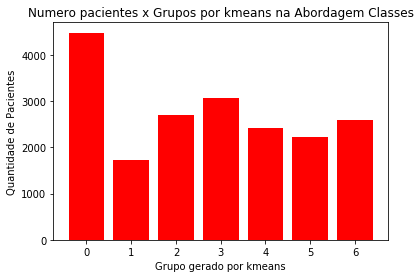

In [174]:
from sklearn.ensemble import RandomForestClassifier

#parametro simples do modelo
random_forest_classes = RandomForestClassifier(n_estimators=50)

#base para modelo
classes = []
qtds = []

contagem = Counter(grupos_classes)

for i in range(0,n_classes):
    classes.append(i)
    qtds.append(contagem[i])

plt.bar(classes,qtds,color="red")
plt.xticks(classes)
plt.ylabel('Quantidade de Pacientes')
plt.xlabel('Grupo gerado por kmeans')
plt.title('Numero pacientes x Grupos por kmeans na Abordagem Classes')
fig = plt.gcf()
fig.savefig(DIR_KMEANS / 'graficos' / 'grafico_Random_AbordagemClasses_doenca_por_grupos.svg',format="svg")
plt.show()

In [175]:
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

# Feature Selection
x_train, x_test, y_train, y_test = train_test_split(array_classes, grupos_classes, test_size=1 - train_ratio,random_state=42)

# Feature Selection
x_val, x_test, y_val, y_test = train_test_split(array_classes, grupos_classes, test_size=test_ratio/(test_ratio + validation_ratio),random_state=42)

# Aplicação do modelo Random Forest no conjunto de dados de treino
random_forest_classes.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [176]:
#### Abordagem 7: VALIDAÇÃO

#calcular acuracia, recall e f1
y_prev_val = random_forest_classes.predict(x_val)

accuracy = accuracy_score(y_val, y_prev_val)
recall = recall_score(y_val, y_prev_val,average='macro')
f1 = f1_score(y_val, y_prev_val,average='macro')

print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

#Matriz de Confusão
mat=list(confusion_matrix(y_val, y_prev_val, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

Accuracy: 1.0 - Recall: 1.0 - F1 Score: 1.0


0     1     2     3     4     5     6
0  2668     0     0     0     0     0     0
1     0  1030     0     0     0     0     0
2     0     0  1616     0     0     0     0
3     0     0     0  1850     0     0     0
4     0     0     0     0  1475     0     0
5     0     0     0     0     0  1323     0
6     0     0     0     0     0     0  1583

In [177]:
#### Abordagem 7: TESTE

#calcular acuracia, recall e f1
y_prev_test = random_forest_classes.predict(x_test)

accuracy = accuracy_score(y_test, y_prev_test)
recall = recall_score(y_test, y_prev_test,average='macro')
f1 = f1_score(y_test, y_prev_test,average='macro')

print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

#Matriz de Confusão
mat=list(confusion_matrix(y_test, y_prev_test, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

Accuracy: 0.9998700792516565 - Recall: 0.9998596688184114 - F1 Score: 0.9998545723664207


0    1     2     3    4    5     6
0  1812    0     0     0    0    0     0
1     0  704     0     0    0    0     0
2     0    0  1081     0    0    0     0
3     0    0     0  1227    0    0     0
4     0    0     0     0  949    0     0
5     0    0     0     0    0  906     0
6     0    0     0     0    1    0  1017

In [178]:
# Importância para Categorias

importancia = pd.DataFrame({'features':ls_classes,'importance':np.round(random_forest_classes.feature_importances_,3)})

importancia = importancia.sort_values('importance',ascending=False)

importancia.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'importancia_features_categoria.csv', 
             sep=';',index=False,encoding='UTF-8')

importancia

features  importance
1                idade       0.383
2                  IMC       0.288
6              Dipping       0.136
7          Non Dipping       0.084
9      Reverse Dipping       0.060
10       Morning Surge       0.024
8      Extreme Dipping       0.016
0               genero       0.005
3           Hipotensao       0.002
12           Whitecoat       0.001
4    Sistolica Isolada       0.000
5   Diastolica Isolada       0.000
11              Masked       0.000

# Abordagem 8: Extratificação do Sexo Masculino

In [179]:
#   Gera uma lista com cabeçalhos

ls_sist_diast = list(dataset_masc_medidas.loc[:,'sist 9:00':'diast 8:45'].columns)

dataset_masc_medidas_sem_id = dataset_masc_medidas.loc[:,'sist 9:00':'diast 8:45']

dataset_masc_medidas_sem_id


sist 9:00  sist 9:15  sist 9:30  sist 9:45  sist 10:00  sist 10:15  \
0          105.0      108.0      116.0      104.0       106.0        98.0   
1          103.0      114.0       82.0      104.0        98.0       106.0   
2          147.0      148.0      156.0      140.0       130.0       132.0   
4          113.0      110.0      101.0      108.0       111.0       111.0   
5          152.0      152.0      152.0      152.0       154.0       138.0   
...          ...        ...        ...        ...         ...         ...   
19231      105.0      117.0       86.0      110.0       114.0       117.0   
19236      119.0      116.0      113.0      110.0       115.0       117.0   
19237      163.0      198.0      172.0      148.0       161.0       156.0   
19238      114.0      120.0      164.0      116.0       119.0       126.0   
19241      111.0      104.0      103.0      101.0        97.0       110.0   

       sist 10:30  sist 10:45  sist 11:00  sist 11:15  ...  diast 6:30  \
0           102.0       107.0       111.0       116.0  ...        41.0   
1           108.0       107.0       109.0       100.0  ...        74.0   
2           121.0       113.0       149.0       128.0  ...        80.0   
4           114.0       115.0       113.0       112.0  ...        64.0   
5           137.0       152.0        95.0       117.0  ...        67.0   
...           ...         ...         ...         ...  ...         ...   
19231       119.0       119.0       119.0        96.0  ...        78.0   
19236       112.0       119.0       111.0       112.0  ...        83.0   
19237       156.0       138.0       107.0        76.0  ...       102.0   
19238       123.0       122.0       122.0       159.0  ...        87.0   
19241       111.0       116.0       104.0       121.0  ...        67.0   

       diast 6:45  diast 7:00  diast 7:15  diast 7:30  diast 7:45  diast 8:00  \
0            46.0        51.0        56.0        61.0        67.0        61.0   
1            74.0        74.0        70.0        67.0        63.0        60.0   
2            86.0        93.0        91.0        89.0        87.0        86.0   
4            73.0        83.0        93.0        68.0        91.0        87.0   
5            94.0       120.0       109.0       109.0       110.0       111.0   
...           ...         ...         ...         ...         ...         ...   
19231        78.0        77.0        65.0        64.0        54.0        60.0   
19236        80.0        78.0        72.0        66.0        70.0        75.0   
19237       114.0       126.0       125.0       124.0       123.0       123.0   
19238        73.0        59.0        74.0        68.0        86.0        96.0   
19241        68.0        69.0        71.0        73.0        56.0        57.0   

       diast 8:15  diast 8:30  diast 8:45  
0            69.0        62.0        51.0  
1            74.0        70.0        67.0  
2            87.0        82.0        82.0  
4            84.0        81.0        72.0  
5           112.0       114.0       115.0  
...           ...         ...         ...  
19231        62.0        65.0        63.0  
19236        66.0        83.0        82.0  
19237       121.0       119.0       123.0  
19238       107.0       106.0        93.0  
19241        65.0        68.0        82.0  

[8760 rows x 164 columns]

## Abordagem 8: Número de Clusters gerado pelo k-Means

In [180]:
#calculando a quantidade ótima de clusters (é possivel dividir os pacientes em quantos grupos)
%time sum_of_squares_masc = calculate_wcss(dataset_masc_medidas_sem_id)
num_otimo_clusters_masc = optimal_number_of_clusters(sum_of_squares_masc)
num_otimo_clusters_masc

Wall time: 1min 4s


6

In [181]:
#convertendo os dados para a clusterização

dataset_masc_medidas_array = np.array(dataset_masc_medidas_sem_id)

In [182]:
#habilitando o kmeans com "num_otimo_clusters" grupos (foi calculado na etapa anterior)

kmeans_masc = KMeans(n_clusters=num_otimo_clusters_masc, random_state=42).fit(dataset_masc_medidas_array)

In [183]:
#listar os grupos 

%time grupos_masc = kmeans_masc.fit_predict(dataset_masc_medidas_array)

Wall time: 2.26 s


##  Abordagem 8: Método Elbow
###  Esse método para calcular o melhor número de cluster para o algoritmo e mostar o gráfico
###  https://minerandodados.com.br/algoritmo-k-means-python-passo-passo/#:~:text=O%20m%C3%A9todo%20Elbow%20se%20trata,um%20valor%20significativo%20de%20ganho.

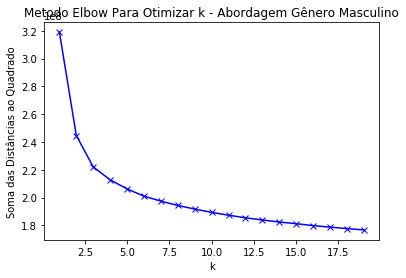

Wall time: 81.2 ms


In [184]:
#metodo de Elbow

Sum_of_squared_distances_masc = []
K = range(1,20)

for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(dataset_masc_medidas_array)
    Sum_of_squared_distances_masc.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances_masc, 'bx-')
plt.xlabel('k')
plt.ylabel('Soma das Distâncias ao Quadrado')
plt.title('Metodo Elbow Para Otimizar k - Abordagem Gênero Masculino')
fig = plt.gcf() 
fig.savefig( DIR_KMEANS / 'graficos' / f'metodoelbow_medidas_masc.svg', format="svg")
%time plt.show()

## Abordagem 8: Silhouette

####  A análise da Silhouette pode ser usada para determinar o grau de separação entre os clusters. O coeficiente de Silhouette quando próximo de +1, indica que os pontos estão muito longe dos pontos do outro cluster, e quando próximo de 0, indica que os pontos então muito perto ou até interseccionando um outro cluster



Para n_clusters = 2 O score_silhouette medio e : 0.19969389720651318
Para n_clusters = 3 O score_silhouette medio e : 0.1267730887059223
Para n_clusters = 4 O score_silhouette medio e : 0.08224369635378088
Para n_clusters = 5 O score_silhouette medio e : 0.07633344799739265
Para n_clusters = 6 O score_silhouette medio e : 0.06076150928355729
Para n_clusters = 7 O score_silhouette medio e : 0.05738686294700486
Para n_clusters = 8 O score_silhouette medio e : 0.055085210102461285


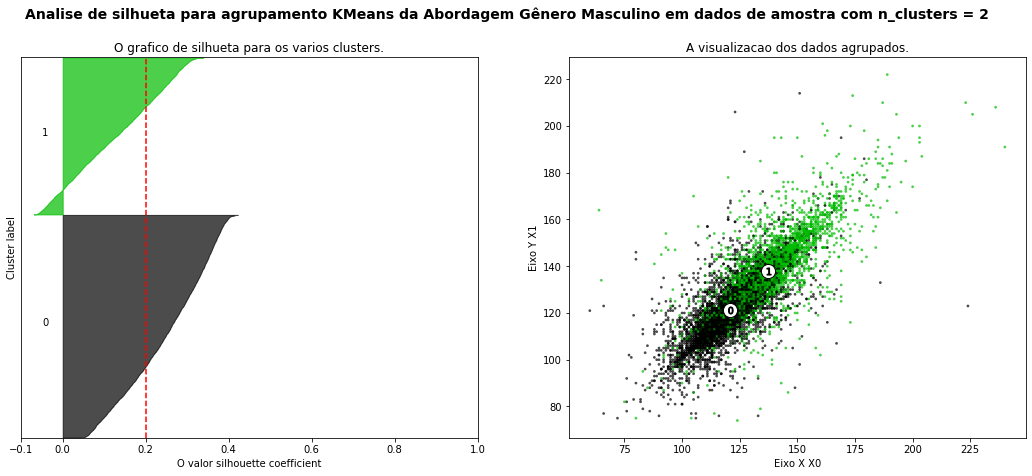

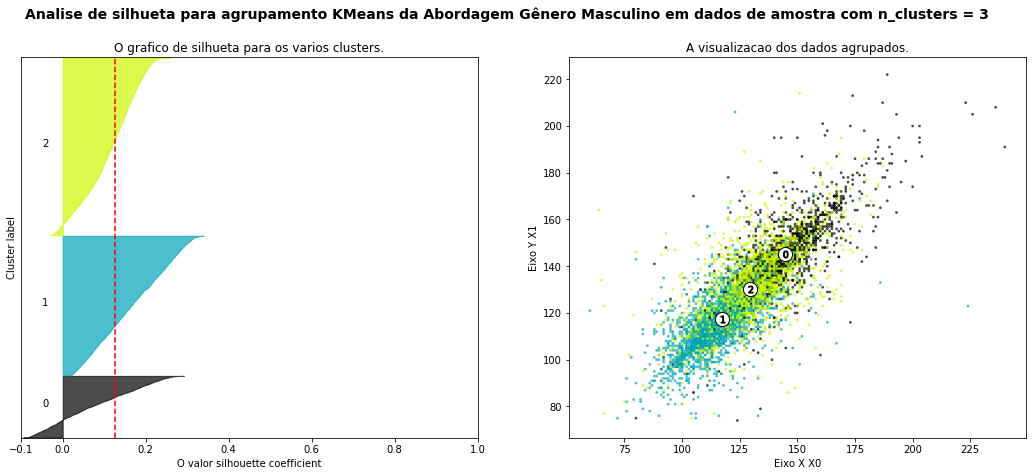

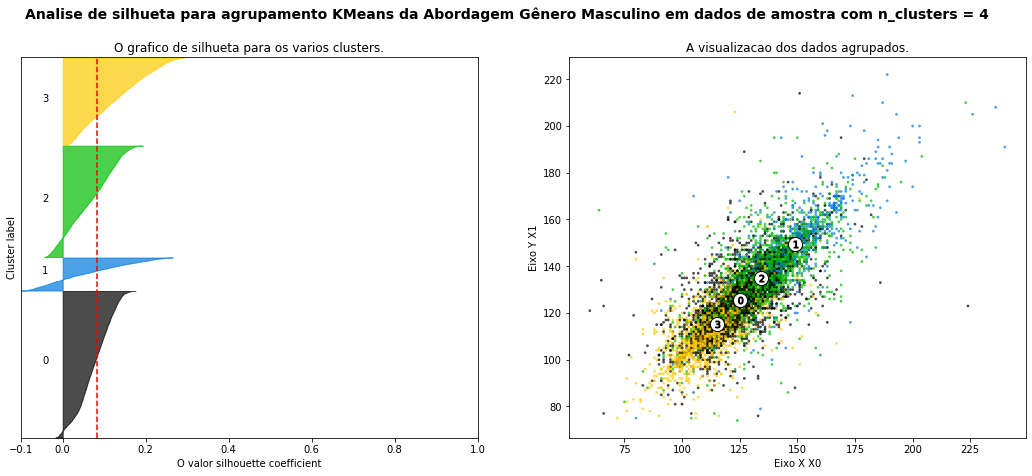

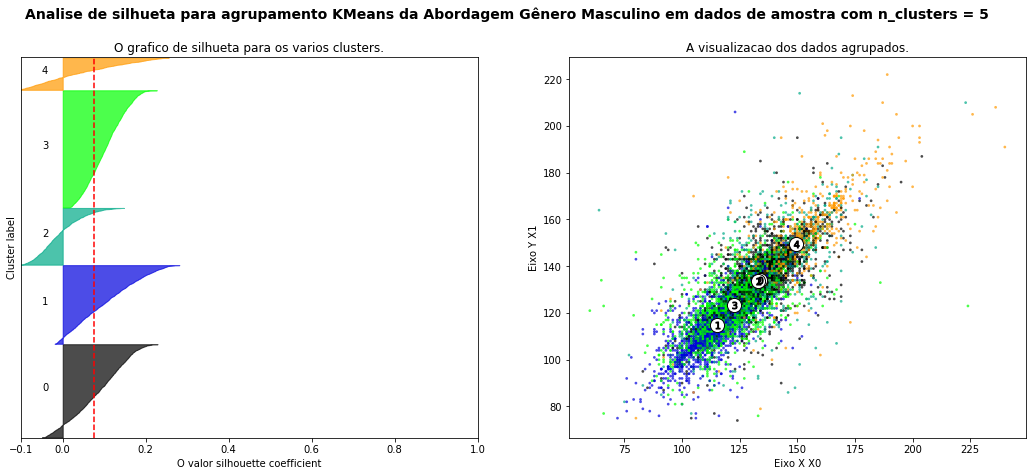

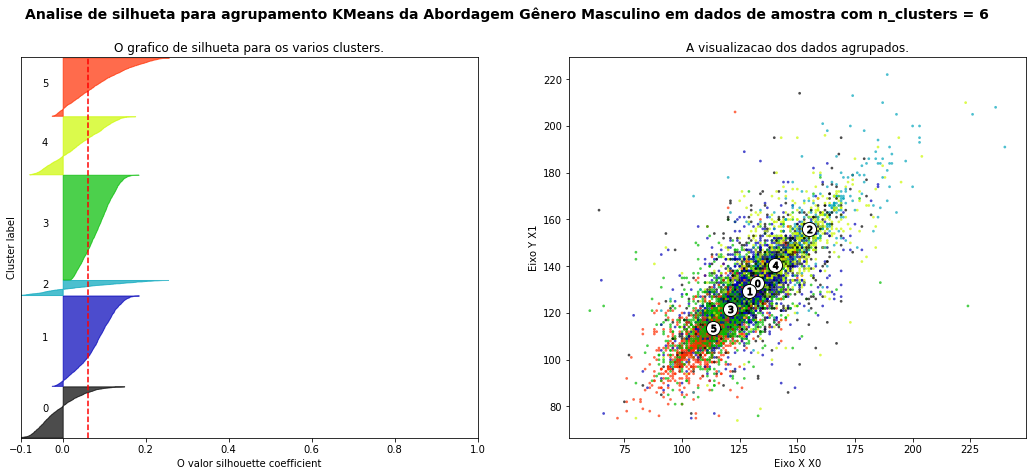

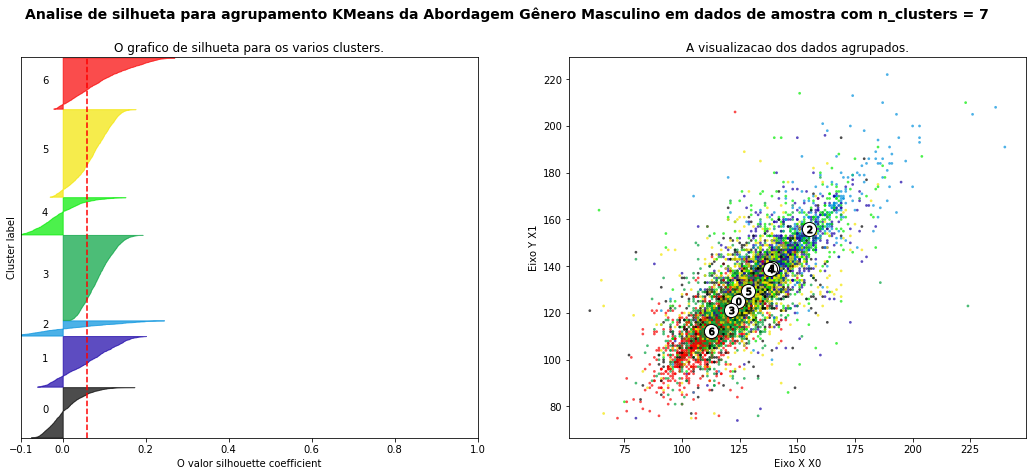

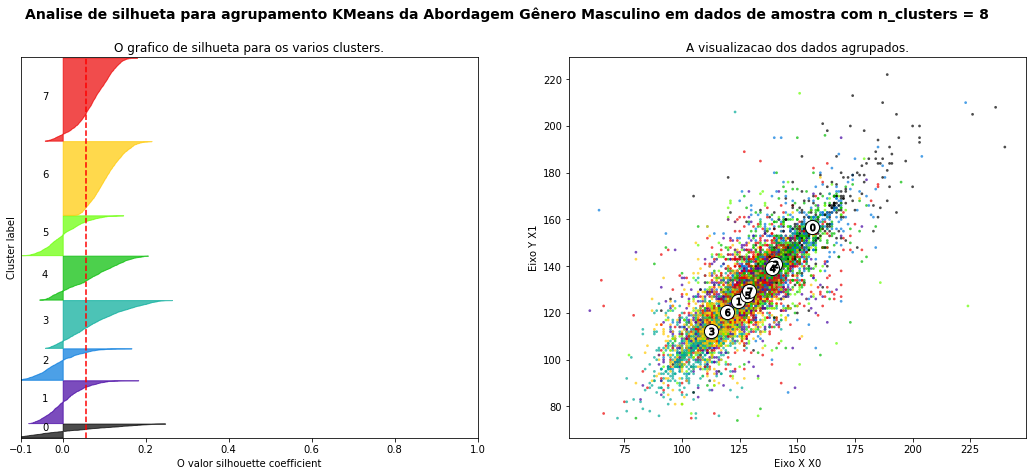

In [185]:
#Silhouette

range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for n_clusters in range_n_clusters:    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    # O 1st subplot é o grafico silhouette
    # O coeficiente silhouette  um range de -1, 1 but in this example all
    # Os exemplos vão ficar em [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # O (n_clusters + 1) * 10 é para inserir um espaço em branco entre a silhueta
    # Para gerar destaque
    ax1.set_ylim([0, len(dataset_masc_medidas_array) + (n_clusters + 1) * 10])
    # Inicialize o clusterer com o valor n_clusters e um valor aleatorio
    # seed 10.
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(dataset_masc_medidas_array)
# O silhouette_score fornece o valor médio para todas as amostras.
    # Isso dá uma perspectiva sobre a densidade e separação das formas
    # clusters
    #  Cálculo de toda a matriz que entra no cálculo do Silhouette
    silhouette_avg = silhouette_score(dataset_masc_medidas_array, cluster_labels)
    print("Para n_clusters =", n_clusters,
          "O score_silhouette medio e :", silhouette_avg)
    # Calcule as pontuações da silhueta para cada amostra
    sample_silhouette_values = silhouette_samples(dataset_masc_medidas_array, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        # Agregue as pontuações de silhueta para amostras pertencentes a
        # cluster i, e classifica-los
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        # Rotule os gráficos de silhueta com seus números de cluster no meio
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        # Calcule o novo y_lower para o próximo gráfico
        y_lower = y_upper + 10  #10 para as 0 amostras
    ax1.set_title("O grafico de silhueta para os varios clusters.")
    ax1.set_xlabel("O valor silhouette coefficient")
    ax1.set_ylabel("Cluster label")
    # A linha vertical para a pontuação média da silhueta de todos os valores
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])  # Limpar os yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    # 2º gráfico mostrando os clusters reais formados
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(dataset_masc_medidas_array[:, 0], dataset_masc_medidas_array[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
    # Labeling dos clusters
    centers = clusterer.cluster_centers_
    # Desenhe círculos brancos nos centros do cluster
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')
    ax2.set_title("A visualizacao dos dados agrupados.")
    ax2.set_xlabel("Eixo X X0")
    ax2.set_ylabel("Eixo Y X1")
    plt.suptitle(("Analise de silhueta para agrupamento KMeans da Abordagem Gênero Masculino em dados de amostra "
                  "com n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    fig = plt.gcf()
    fig.savefig( DIR_KMEANS / 'graficos' / f'metodosilhouette_medidas_masc_{n_clusters}.svg', format="svg")
    
plt.show()

#fig.savefig('diast_sist_kmeans.png', format='png')

### Não existe um valor de k clusters que não esteja se intersectando¶

In [186]:
# Dataset com grupos e medidas
# nume id, data exame, idade, peso, altura, medidas, 22 estatisticas, 11 doenças em cada grupo 

#
genero_M_F = {"genero": {1: "M", 0: "F"}}

dataset_masc_apos_kmeans = dataset_masc.loc[:,'numero_identificacao':'data_exame']

dataset_masc_apos_kmeans['grupo'] = grupos_masc

dataset_masc_apos_kmeans['grupo'] = dataset_masc_apos_kmeans['grupo'] + 1

dataset_masc_apos_kmeans = pd.concat([dataset_masc_apos_kmeans,
                                         dataset_masc.loc[:,'sist 9:00':'Picos Diastolica']],axis=1)

dataset_masc_apos_kmeans = dataset_masc_apos_kmeans.replace(genero_M_F)

# Salva dataset com dados completos após o K-Means com abordagem 1 (medidas)
dataset_masc_apos_kmeans.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'mapa_apos_kmeans_medidas_masc.csv', 
             sep=';',index=False,encoding='UTF-8')

dataset_masc_apos_kmeans

numero_identificacao data_nascimento genero  idade   peso altura   IMC  \
0                         4      1923-10-05      M   94.0   85.0    160  33.2   
1                         5      1948-10-07      M   70.0   80.0    165  29.4   
2                         6      1999-03-23      M   19.0  100.0    197  25.8   
4                         8      1990-03-07      M   28.0  120.0    172  40.6   
5                         9      1982-04-28      M   36.0  100.0    185  29.2   
...                     ...             ...    ...    ...    ...    ...   ...   
19231                 21775      1955-09-04      M   65.0   94.0   1,83  28.1   
19236                 21783      1969-05-24      M   51.0   93.0    168  33.0   
19237                 21786      1972-11-25      M   47.0   75.0    165  27.5   
19238                 21787      1970-10-19      M   49.0   90.0    183  26.9   
19241                 21793      1971-01-14      M   49.0   99.0    179  30.9   

                data_exame  grupo  sist 9:00  ...  Mediana Diastolica em 24h  \
0      2018-09-10 12:25:23      6      105.0  ...                       59.0   
1      2018-12-26 07:39:41      6      103.0  ...                       62.0   
2      2018-12-26 08:06:19      1      147.0  ...                       79.0   
4      2018-12-26 08:26:59      4      113.0  ...                       78.0   
5      2018-12-26 09:56:35      3      152.0  ...                      104.5   
...                    ...    ...        ...  ...                        ...   
19231  2020-09-10 14:40:03      4      105.0  ...                       78.0   
19236  2020-09-10 15:40:30      4      119.0  ...                       74.0   
19237  2020-09-10 16:03:08      3      163.0  ...                      116.0   
19238  2020-09-10 16:21:02      5      114.0  ...                       85.0   
19241  2020-09-10 17:42:01      2      111.0  ...                       86.0   

       AUC Sistolica em 24h  AUC Diastolica em 24h  AUC PP Daytime  \
0                    9545.5                 4902.0          3748.0   
1                    8586.5                 5034.5          2915.0   
2                   10674.0                 6154.0          3721.0   
4                    9141.5                 6118.0          2405.0   
5                   11583.0                 8198.0          2783.5   
...                     ...                    ...             ...   
19231                9742.5                 6171.5          2984.5   
19236                9121.5                 5963.5          2605.0   
19237               12224.5                 9265.0          2439.0   
19238               10970.0                 6819.0          3319.0   
19241                9812.0                 6746.5          2400.5   

       AUC PP Nighttime  DP Sistolica em 24h  DP Diastolica em 24h  \
0                 841.5                16.52                 11.36   
1                 606.0                 7.51                  6.65   
2                 751.5                12.70                 13.01   
4                 566.0                12.27                 12.79   
5                 558.5                10.83                 12.82   
...                 ...                  ...                   ...   
19231             546.0                14.42                  8.85   
19236             513.0                14.69                 11.86   
19237             474.5                18.66                 14.80   
19238             738.0                17.22                 13.67   
19241             612.0                13.92                 12.71   

       Diferenca % Dipping  Picos Sistolica  Picos Diastolica  
0                    0.966               11                34  
1                    0.969                9                23  
2                    1.056               19                19  
4                    1.137               10                11  
5                    1.051               37                52  
...    

### Abordagem 8: Random Forest

In [187]:
from sklearn.ensemble import RandomForestClassifier

In [188]:
#parametro simples do modelo
random_forest_masc = RandomForestClassifier(n_estimators=50)

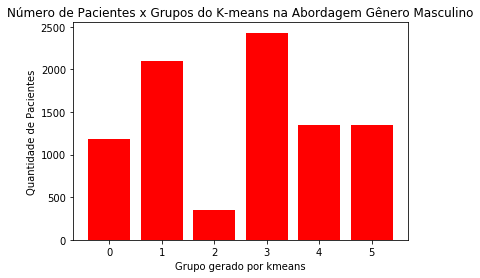

In [189]:
# Plota Gráfico da qtd pacientes em cada Grupos

classes = []
qtds = []

contagem = Counter(grupos_masc)

for i in range(0,num_otimo_clusters_masc):
    classes.append(i)
    qtds.append(contagem[i])

plt.bar(classes,qtds,color="red")
plt.xticks(classes)
plt.ylabel('Quantidade de Pacientes')
plt.xlabel('Grupo gerado por kmeans')
plt.title('Número de Pacientes x Grupos do K-means na Abordagem Gênero Masculino')
fig = plt.gcf()
fig.savefig(DIR_KMEANS / 'graficos' / 'grafico_Random_Abordagem9_pacientes_masculino_por_grupos.svg',format="svg")
plt.show()


In [190]:
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

#separar train(75%) - 14.485, test (10%) - 7.726  and validation (15%) - 11.588
#  O parâmetro random_state=42 garante o rastreio do numero de identificação
x_train, x_test, y_train, y_test = train_test_split(dataset_masc_medidas_array, grupos_masc, test_size=1 - train_ratio,random_state=42)
x_val, x_test, y_val, y_test = train_test_split(dataset_masc_medidas_array, grupos_masc, test_size=test_ratio/(test_ratio + validation_ratio),random_state=42)

In [191]:
#treino
random_forest_masc.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

#### Abordagem 8: VALIDAÇÃO

In [192]:
#calcular acuracia, recall e f1
y_prev_val = random_forest_masc.predict(x_val)

accuracy = accuracy_score(y_val, y_prev_val)
recall = recall_score(y_val, y_prev_val,average='macro')
f1 = f1_score(y_val, y_prev_val,average='macro')

In [193]:
print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

Accuracy: 1.0 - Recall: 1.0 - F1 Score: 1.0


In [194]:
#Matriz de Confusão
mat=list(confusion_matrix(y_val, y_prev_val, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

0     1    2     3    4    5
0  716     0    0     0    0    0
1    0  1226    0     0    0    0
2    0     0  219     0    0    0
3    0     0    0  1471    0    0
4    0     0    0     0  817    0
5    0     0    0     0    0  807

#### Abordagem 8: TESTE

In [195]:
#calcular acuracia, recall e f1
y_prev_test = random_forest_masc.predict(x_test)

accuracy = accuracy_score(y_test, y_prev_test)
recall = recall_score(y_test, y_prev_test,average='macro')
f1 = f1_score(y_test, y_prev_test,average='macro')

In [196]:
print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

Accuracy: 0.913527397260274 - Recall: 0.8905862759731075 - F1 Score: 0.9091308358552662


In [197]:
#Matriz da Confusão
mat=list(confusion_matrix(y_test, y_prev_test, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

0    1    2    3    4    5
0  400   27    0   36    1    5
1    5  831    0   28    8    0
2    1    0  105    0   25    0
3   11   33    0  903    0   14
4   11   42    0    0  478    0
5    5    0    0   51    0  484

In [198]:
dataset_masc_apos_kmeans.describe()


numero_identificacao        idade         peso          IMC  \
count           8760.000000  8760.000000  8760.000000  8760.000000   
mean           10841.889041    53.018607    85.824201    28.437397   
std             6291.907588    15.804672    16.529731     6.317480   
min                4.000000     8.000000     4.000000     1.400000   
25%             5383.250000    41.000000    75.000000    25.300000   
50%            10813.500000    52.000000    84.000000    27.700000   
75%            16318.750000    65.000000    95.000000    30.500000   
max            21793.000000   100.000000   200.000000   181.000000   

             grupo    sist 9:00    sist 9:15    sist 9:30    sist 9:45  \
count  8760.000000  8760.000000  8760.000000  8760.000000  8760.000000   
mean      3.536644   127.585616   128.031963   128.215639   128.112329   
std       1.664325    16.415145    16.542082    16.529712    16.338788   
min       1.000000    60.000000    74.000000    62.000000    63.000000   
25%       2.000000   117.000000   117.000000   117.000000   117.000000   
50%       4.000000   127.000000   127.000000   127.000000   127.000000   
75%       5.000000   137.000000   138.000000   138.000000   138.000000   
max       6.000000   240.000000   222.000000   257.000000   230.000000   

        sist 10:00  ...  Mediana Diastolica em 24h  AUC Sistolica em 24h  \
count  8760.000000  ...                8760.000000           8760.000000   
mean    127.871918  ...                  79.761301          10040.968379   
std      16.265466  ...                   9.418862            883.538089   
min      62.000000  ...                  43.000000           7438.500000   
25%     117.000000  ...                  73.500000           9438.375000   
50%     127.000000  ...                  79.000000           9964.000000   
75%     137.000000  ...                  86.000000          10530.000000   
max     232.000000  ...                 132.000000          15047.500000   

       AUC Diastolica em 24h  AUC PP Daytime  AUC PP Nighttime  \
count            8760.000000     8760.000000       8760.000000   
mean             6409.645205     2994.122432        591.001142   
std               726.016353      543.237245        111.229961   
min              3674.500000     1706.000000        301.000000   
25%              5921.875000     2609.500000        514.000000   
50%              6375.500000     2919.000000        575.250000   
75%              6856.125000     3290.125000        651.500000   
max             10530.500000     5885.000000       1250.500000   

       DP Sistolica em 24h  DP Diastolica em 24h  Diferenca % Dipping  \
count          8760.000000           8760.000000          8760.000000   
mean             12.549063             10.712627             1.086403   
std               3.190719              2.319117             0.080148   
min               5.070000              3.980000             0.785000   
25%              10.310000              9.050000             1.034000   
50%              12.120000             10.520000             1.086000   
75%              14.280000             12.130000             1.137250   
max              38.360000             23.850000             1.492000   

       Picos Sistolica  Picos Diastolica  
count      8760.000000       8760.000000  
mean         15.390982         21.106849  
std          13.186309         14.488115  
min           0.000000          0.000000  
25%           6.000000         11.000000  
50%          11.000000         17.000000  
75%          20.000000         28.000000  
max          81.000000         79.000000  

[8 rows x 194 columns]

In [199]:
#salvar dataframe numero_paciente, grupo_real, grupo, previsto validação
x_train_, x_test_, y_train_, y_test_ = train_test_split(dataset_masc_apos_kmeans, grupos_masc, test_size=1 - train_ratio, random_state=42)
x_val_, x_test_, y_val_, y_test_ = train_test_split(dataset_masc_apos_kmeans, grupos_masc, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42)

#validacao
pacientes_validacao_diast_sisto = x_val_[['numero_identificacao']]
pacientes_validacao_diast_sisto['Grupo_Real'] = y_val_
pacientes_validacao_diast_sisto['Grupo_Previsto'] = y_prev_val

pacientes_validacao_diast_sisto.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'pacientes_validacao_medidas_masc.csv', 
             sep=';',index=False,encoding='UTF-8')

#teste
pacientes_teste_diast_sisto = x_test_[['numero_identificacao']]
pacientes_teste_diast_sisto['Grupo_Real'] = y_test_
pacientes_teste_diast_sisto['Grupo_Previsto'] = y_prev_test

pacientes_teste_diast_sisto.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'pacientes_teste_medidas_masc.csv', 
             sep=';',index=False,encoding='UTF-8')


c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

#### Abordagem 8: Importância das Features Random Forest

In [200]:
#calculo da importancia de cada variavel para idenficar os grupos com 3 casas decimais
importancia = pd.DataFrame({'features':ls_sist_diast,'importance':np.round(random_forest_masc.feature_importances_,3)})
importancia = importancia.sort_values('importance',ascending=False)

importancia.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'importancia_features_medidas_masc.csv', 
             sep=';',index=False,encoding='UTF-8')

importancia

features  importance
71     sist 6:15       0.016
48    sist 21:00       0.014
45    sist 20:15       0.014
46    sist 20:30       0.013
90   diast 11:00       0.012
..           ...         ...
150   diast 5:00       0.002
152   diast 6:00       0.002
144   diast 2:00       0.002
142   diast 1:00       0.002
141   diast 0:30       0.002

[164 rows x 2 columns]

# Abordagem 9: Extratificação do Sexo Feminino

In [201]:
#selecionando variaveis de medidas : sist 9:00 a diast 8:45

#   Gera uma lista com cabeçalhos
ls_sist_diast = list(dataset_fem_medidas.loc[:,'sist 9:00':'diast 8:45'].columns)

dataset_fem_medidas_sem_id = dataset_fem_medidas.loc[:,'sist 9:00':'diast 8:45']

dataset_fem_medidas_sem_id


sist 9:00  sist 9:15  sist 9:30  sist 9:45  sist 10:00  sist 10:15  \
3          140.0      139.0      142.0      137.0       135.0       177.0   
9          131.0      131.0      130.0      129.0       129.0       111.0   
10         107.0      110.0      113.0      116.0       120.0       108.0   
11         166.0      171.0      176.0      181.0       186.0       192.0   
13         142.0      123.0      124.0      135.0       147.0       159.0   
...          ...        ...        ...        ...         ...         ...   
19233      137.0      121.0      118.0      148.0       111.0       115.0   
19234      153.0      149.0      136.0      152.0       157.0       153.0   
19235      121.0      123.0      125.0      122.0       120.0       118.0   
19239      107.0      110.0      103.0      105.0       108.0       111.0   
19240       94.0      107.0      112.0      124.0       120.0        94.0   

       sist 10:30  sist 10:45  sist 11:00  sist 11:15  ...  diast 6:30  \
3           148.0       152.0       135.0       136.0  ...        49.0   
9           122.0       133.0       144.0       155.0  ...        58.0   
10          105.0       108.0       114.0       105.0  ...        57.0   
11          177.0       168.0       159.0       150.0  ...        79.0   
13          142.0       141.0       133.0       141.0  ...        83.0   
...           ...         ...         ...         ...  ...         ...   
19233       111.0       128.0       136.0       133.0  ...        70.0   
19234       141.0       135.0       136.0       134.0  ...        88.0   
19235       120.0       117.0       121.0       149.0  ...        66.0   
19239       114.0       144.0       128.0       104.0  ...        49.0   
19240       102.0       113.0       104.0        96.0  ...        63.0   

       diast 6:45  diast 7:00  diast 7:15  diast 7:30  diast 7:45  diast 8:00  \
3            56.0        62.0        83.0       104.0        99.0        94.0   
9            99.0       140.0        67.0        81.0        95.0        94.0   
10           61.0        65.0        70.0        66.0        78.0        67.0   
11           98.0       116.0       114.0       113.0       111.0       110.0   
13           76.0        68.0        86.0        64.0       100.0        88.0   
...           ...         ...         ...         ...         ...         ...   
19233        61.0        52.0        50.0        52.0        65.0        72.0   
19234        90.0        93.0       104.0        94.0        91.0        99.0   
19235        66.0        67.0        65.0        85.0        82.0        82.0   
19239        50.0        50.0        53.0        52.0        62.0        68.0   
19240        63.0        64.0        76.0        72.0        69.0        75.0   

       diast 8:15  diast 8:30  diast 8:45  
3            89.0        90.0        72.0  
9            94.0        94.0        93.0  
10           73.0        75.0        66.0  
11          108.0       107.0       105.0  
13          110.0       119.0        90.0  
...           ...         ...         ...  
19233        79.0        57.0        77.0  
19234        96.0       103.0        98.0  
19235        85.0        87.0        86.0  
19239        61.0        64.0        60.0  
19240        74.0        69.0        67.0  

[10482 rows x 164 columns]

## Abordagem 9: Número de Clusters gerado pelo k-Means

In [202]:
#calculando a quantidade ótima de clusters (é possivel dividir os pacientes em quantos grupos)
%time sum_of_squares_fem = calculate_wcss(dataset_fem_medidas_sem_id)
num_otimo_clusters_fem = optimal_number_of_clusters(sum_of_squares_fem)
num_otimo_clusters_fem

Wall time: 1min 21s


7

In [203]:
#convertendo os dados para a clusterização

dataset_fem_medidas_array = np.array(dataset_fem_medidas_sem_id)

In [204]:
#habilitando o kmeans com "num_otimo_clusters" grupos (foi calculado na etapa anterior)

kmeans_fem = KMeans(n_clusters=num_otimo_clusters_fem, random_state=42).fit(dataset_fem_medidas_array)

In [205]:
#listar os grupos 

grupos_fem = kmeans_fem.fit_predict(dataset_fem_medidas_array)

##  Abordagem 9: Método Elbow
###  Esse método para calcular o melhor número de cluster para o algoritmo e mostar o gráfico
###  https://minerandodados.com.br/algoritmo-k-means-python-passo-passo/#:~:text=O%20m%C3%A9todo%20Elbow%20se%20trata,um%20valor%20significativo%20de%20ganho.

In [ ]:
#metodo de Elbow

Sum_of_squared_distances_fem = []
K = range(1,20)

for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(dataset_fem_medidas_array)
    Sum_of_squared_distances_fem.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances_fem, 'bx-')
plt.xlabel('k')
plt.ylabel('Soma das Distâncias ao Quadrado')
plt.title('Metodo Elbow Para Otimizar k - Abordagem Gênero Feminino')
fig = plt.gcf() 
fig.savefig( DIR_KMEANS / 'graficos' / f'metodoelbow_medidas_fem.svg', format="svg")
%time plt.show()

## Abordagem 9: Silhouette

####  A análise da Silhouette pode ser usada para determinar o grau de separação entre os clusters. O coeficiente de Silhouette quando próximo de +1, indica que os pontos estão muito longe dos pontos do outro cluster, e quando próximo de 0, indica que os pontos então muito perto ou até interseccionando um outro cluster



In [ ]:
#Silhouette

range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for n_clusters in range_n_clusters:    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    # O 1st subplot é o grafico silhouette
    # O coeficiente silhouette  um range de -1, 1 but in this example all
    # Os exemplos vão ficar em [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # O (n_clusters + 1) * 10 é para inserir um espaço em branco entre a silhueta
    # Para gerar destaque
    ax1.set_ylim([0, len(dataset_fem_medidas_array) + (n_clusters + 1) * 10])
    # Inicialize o clusterer com o valor n_clusters e um valor aleatorio
    # seed 10.
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(dataset_fem_medidas_array)
# O silhouette_score fornece o valor médio para todas as amostras.
    # Isso dá uma perspectiva sobre a densidade e separação das formas
    # clusters
    #  Cálculo de toda a matriz que entra no cálculo do Silhouette
    silhouette_avg = silhouette_score(dataset_fem_medidas_array, cluster_labels)
    print("Para n_clusters =", n_clusters,
          "O score_silhouette medio e :", silhouette_avg)
    # Calcule as pontuações da silhueta para cada amostra
    sample_silhouette_values = silhouette_samples(dataset_fem_medidas_array, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        # Agregue as pontuações de silhueta para amostras pertencentes a
        # cluster i, e classifica-los
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        # Rotule os gráficos de silhueta com seus números de cluster no meio
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        # Calcule o novo y_lower para o próximo gráfico
        y_lower = y_upper + 10  #10 para as 0 amostras
    ax1.set_title("O grafico de silhueta para os varios clusters.")
    ax1.set_xlabel("O valor silhouette coefficient")
    ax1.set_ylabel("Cluster label")
    # A linha vertical para a pontuação média da silhueta de todos os valores
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])  # Limpar os yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    # 2º gráfico mostrando os clusters reais formados
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(dataset_fem_medidas_array[:, 0], dataset_fem_medidas_array[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
    # Labeling dos clusters
    centers = clusterer.cluster_centers_
    # Desenhe círculos brancos nos centros do cluster
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')
    ax2.set_title("A visualizacao dos dados agrupados.")
    ax2.set_xlabel("Eixo X X0")
    ax2.set_ylabel("Eixo Y X1")
    plt.suptitle(("Analise de silhueta para agrupamento KMeans da Abordagem Gênero Feminino em dados de amostra "
                  "com n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    fig = plt.gcf()
    fig.savefig( DIR_KMEANS / 'graficos' / f'metodosilhouette_medidas_fem_{n_clusters}.svg', format="svg")
    
plt.show()

#fig.savefig('diast_sist_kmeans.png', format='png')

### Não existe um valor de k clusters que não esteja se intersectando¶

In [ ]:
# Dataset com grupos e medidas
# nume id, data exame, idade, peso, altura, medidas, 22 estatisticas, 11 doenças em cada grupo 

#
dataset_fem_apos_kmeans = dataset_fem.loc[:,'numero_identificacao':'data_exame']

dataset_fem_apos_kmeans['grupo'] = grupos_fem

dataset_fem_apos_kmeans['grupo'] = dataset_fem_apos_kmeans['grupo'] + 1

dataset_fem_apos_kmeans = pd.concat([dataset_fem_apos_kmeans,
                                         dataset_fem.loc[:,'sist 9:00':'Picos Diastolica']],axis=1)

dataset_fem_apos_kmeans = dataset_fem_apos_kmeans.replace(genero_M_F)

# Salva dataset com dados completos após o K-Means com abordagem 1 (medidas)
dataset_fem_apos_kmeans.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'mapa_apos_kmeans_medidas_fem.csv', 
             sep=';',index=False,encoding='UTF-8')

dataset_fem_apos_kmeans

### Abordagem 9: Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
#parametro simples do modelo
random_forest_fem = RandomForestClassifier(n_estimators=50)

In [ ]:
# Plota Gráfico da qtd pacientes em cada Grupos

classes = []
qtds = []

contagem = Counter(grupos_fem)

for i in range(0,num_otimo_clusters_fem):
    classes.append(i)
    qtds.append(contagem[i])

plt.bar(classes,qtds,color="red")
plt.xticks(classes)
plt.ylabel('Quantidade de Pacientes')
plt.xlabel('Grupo gerado por kmeans')
plt.title('Número de Pacientes x Grupos do K-means na Abordagem Gênero Feminino')
fig = plt.gcf()
fig.savefig(DIR_KMEANS / 'graficos' / 'grafico_Random_Abordagem9_pacientes_feminino_por_grupos.svg',format="svg")
plt.show()


In [ ]:
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

#separar train(75%) - 14.485, test (10%) - 7.726  and validation (15%) - 11.588
#  O parâmetro random_state=42 garante o rastreio do numero de identificação
x_train, x_test, y_train, y_test = train_test_split(dataset_fem_medidas_array, grupos_fem, test_size=1 - train_ratio,random_state=42)
x_val, x_test, y_val, y_test = train_test_split(dataset_fem_medidas_array, grupos_fem, test_size=test_ratio/(test_ratio + validation_ratio),random_state=42)

In [ ]:
#treino
random_forest_fem.fit(x_train, y_train)

#### Abordagem 9: VALIDAÇÃO

In [ ]:
#calcular acuracia, recall e f1
y_prev_val = random_forest_fem.predict(x_val)

accuracy = accuracy_score(y_val, y_prev_val)
recall = recall_score(y_val, y_prev_val,average='macro')
f1 = f1_score(y_val, y_prev_val,average='macro')

In [ ]:
print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

In [ ]:
#Matriz de Confusão
mat=list(confusion_matrix(y_val, y_prev_val, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

#### Abordagem 9: TESTE

In [ ]:
#calcular acuracia, recall e f1
y_prev_test = random_forest_fem.predict(x_test)

accuracy = accuracy_score(y_test, y_prev_test)
recall = recall_score(y_test, y_prev_test,average='macro')
f1 = f1_score(y_test, y_prev_test,average='macro')

print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

In [ ]:
#Matriz da Confusão
mat=list(confusion_matrix(y_test, y_prev_test, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

In [ ]:
#salvar dataframe numero_paciente, grupo_real, grupo, previsto validação
x_train_, x_test_, y_train_, y_test_ = train_test_split(dataset_fem_apos_kmeans, grupos_fem, test_size=1 - train_ratio, random_state=42)
x_val_, x_test_, y_val_, y_test_ = train_test_split(dataset_fem_apos_kmeans, grupos_fem, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42)

#validacao
pacientes_validacao_diast_sisto = x_val_[['numero_identificacao']]
pacientes_validacao_diast_sisto['Grupo_Real'] = y_val_
pacientes_validacao_diast_sisto['Grupo_Previsto'] = y_prev_val

pacientes_validacao_diast_sisto.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'pacientes_validacao_medidas_fem.csv', 
             sep=';',index=False,encoding='UTF-8')

#teste
pacientes_teste_diast_sisto = x_test_[['numero_identificacao']]
pacientes_teste_diast_sisto['Grupo_Real'] = y_test_
pacientes_teste_diast_sisto['Grupo_Previsto'] = y_prev_test

pacientes_teste_diast_sisto.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'pacientes_teste_medidas_fem.csv', 
             sep=';',index=False,encoding='UTF-8')


#### Abordagem 9: Importância das Features Random Forest

In [ ]:
#calculo da importancia de cada variavel para idenficar os grupos com 3 casas decimais
importancia = pd.DataFrame({'features':ls_sist_diast,'importance':np.round(random_forest_fem.feature_importances_,3)})
importancia = importancia.sort_values('importance',ascending=False)
importancia

importancia.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'importancia_features_medidas_fem.csv', 
             sep=';',index=False,encoding='UTF-8')

# Abordagem 10: Sistólicas separadas

In [ ]:
#selecionando variaveis de medidas : sist 9:00 a diast 8:45 em listas separadas

ls_sistolica = list(dataset_medidas.loc[:,'sist 9:00':'sist 8:45'].columns)
sistolica_sem_id = dataset_medidas.loc[:,'sist 9:00':'sist 8:45']


## Abordagem 10: Número de Clusters gerado pelo k-Means

In [ ]:
#calculando a quantidade ótima de clusters (é possivel dividir os pacientes em quantos grupos)
%time sum_of_squares_sistolica = calculate_wcss(sistolica_sem_id)
num_otimo_clusters_sistolica = optimal_number_of_clusters(sum_of_squares_sistolica)
num_otimo_clusters_sistolica

In [ ]:
#convertendo os dados para a clusterização

sistolica_array = np.array(sistolica_sem_id)

In [ ]:
#habilitando o kmeans com "num_otimo_clusters" grupos (foi calculado na etapa anterior)

kmeans_sistolica = KMeans(n_clusters=num_otimo_clusters_sistolica, random_state=42).fit(sistolica_array)

In [ ]:
#listar os grupos 

grupos_sistolica = kmeans_sistolica.fit_predict(sistolica_array)

In [ ]:
#incluir grupos nos dados de sist e diast

sistolica_sem_id['grupo'] = grupos_sistolica
sistolica_sem_id['grupo'] = sistolica_sem_id['grupo'] + 1
sistolica_sem_id

In [ ]:

# nume id, data exame, idade, peso, altura, medidas, 22 estatisticas, 11 doenças em cada grupo 

dataset_sistolica_apos_kmeans = dataset_apos_tratamento.loc[:,'numero_identificacao':'IMC']

dataset_sistolica_apos_kmeans = pd.concat([dataset_sistolica_apos_kmeans,
                                         dataset_apos_tratamento.loc[:,'sist 9:00':'Picos Diastolica']],axis=1)
dataset_sistolica_apos_kmeans

# Salva dataset com dados completos após o K-Means com abordagem 10 (medidas)
dataset_sistolica_apos_kmeans.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'mapa_apos_kmeans_sistolica.csv', 
             sep=';',index=False,encoding='UTF-8')


### Abordagem 10: Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
#parametro simples do modelo
random_forest_sistolica = RandomForestClassifier(n_estimators=50)

In [ ]:
# Plota Gráfico da qtd pacientes em cada Grupos

classes = []
qtds = []

contagem = Counter(grupos_sistolica)

for i in range(0,num_otimo_clusters_sistolica):
    classes.append(i)
    qtds.append(contagem[i])

plt.bar(classes,qtds,color="red")
plt.xticks(classes)
plt.ylabel('Quantidade de Pacientes')
plt.xlabel('Grupo gerado por kmeans')
plt.title('Número de Pacientes x Grupos do K-means na Abordagem Medidas')
fig = plt.gcf()
fig.savefig(DIR_KMEANS / 'graficos' / 'grafico_Random_Abordagem_sistolica_pacientes_por_grupos.svg',format="svg")
plt.show()


In [ ]:
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

#separar train(75%) - 14.485, test (10%) - 7.726  and validation (15%) - 11.588
#  O parâmetro random_state=42 garante o rastreio do numero de identificação
x_train, x_test, y_train, y_test = train_test_split(sistolica_array, grupos_sistolica, test_size=1 - train_ratio,random_state=42)
x_val, x_test, y_val, y_test = train_test_split(sistolica_array, grupos_sistolica, test_size=test_ratio/(test_ratio + validation_ratio),random_state=42)

In [ ]:
#treino
random_forest_sistolica.fit(x_train, y_train)

#### Abordagem 10: VALIDAÇÃO

In [ ]:
#calcular acuracia, recall e f1
y_prev_val = random_forest_sistolica.predict(x_val)

accuracy = accuracy_score(y_val, y_prev_val)
recall = recall_score(y_val, y_prev_val,average='macro')
f1 = f1_score(y_val, y_prev_val,average='macro')

print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

In [ ]:
#Matriz de Confusão
mat=list(confusion_matrix(y_val, y_prev_val, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

#### Abordagem 10: TESTE

In [ ]:
#calcular acuracia, recall e f1
y_prev_test = random_forest_sistolica.predict(x_test)

accuracy = accuracy_score(y_test, y_prev_test)
recall = recall_score(y_test, y_prev_test,average='macro')
f1 = f1_score(y_test, y_prev_test,average='macro')

print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

In [ ]:
#Matriz da Confusão
mat=list(confusion_matrix(y_test, y_prev_test, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

In [ ]:
#salvar dataframe numero_paciente, grupo_real, grupo, previsto validação
x_train_, x_test_, y_train_, y_test_ = train_test_split(dataset_sistolica_apos_kmeans, grupos_sistolica, test_size=1 - train_ratio, random_state=42)
x_val_, x_test_, y_val_, y_test_ = train_test_split(dataset_sistolica_apos_kmeans, grupos_sistolica, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42)

#validacao
pacientes_validacao_diast_sisto = x_val_[['numero_identificacao']]
pacientes_validacao_diast_sisto['Grupo_Real'] = y_val_
pacientes_validacao_diast_sisto['Grupo_Previsto'] = y_prev_val

pacientes_validacao_diast_sisto.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'pacientes_validacao_sistolica.csv', 
             sep=';',index=False,encoding='UTF-8')

#teste
pacientes_teste_diast_sisto = x_test_[['numero_identificacao']]
pacientes_teste_diast_sisto['Grupo_Real'] = y_test_
pacientes_teste_diast_sisto['Grupo_Previsto'] = y_prev_test

pacientes_teste_diast_sisto.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'pacientes_teste_sistolica.csv', 
             sep=';',index=False,encoding='UTF-8')


#### Abordagem 10: Importância das Features Random Forest

In [ ]:
#calculo da importancia de cada variavel para idenficar os grupos com 3 casas decimais
importancia = pd.DataFrame({'features':ls_sistolica,'importance':np.round(random_forest_sistolica.feature_importances_,3)})
importancia = importancia.sort_values('importance',ascending=False)

importancia.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'importancia_features_sistolica.csv', 
             sep=';',index=False,encoding='UTF-8')

importancia


# Abordagem 11: Sistólicas e Disatólicas separadas

In [ ]:
ls_diastolica = list(dataset_medidas.loc[:,'diast 9:00':'diast 8:45'].columns)
diastolica_sem_id = dataset_medidas.loc[:,'diast 9:00':'diast 8:45']

## Abordagem 11: Número de Clusters gerado pelo k-Means

In [ ]:
#calculando a quantidade ótima de clusters (é possivel dividir os pacientes em quantos grupos)
%time sum_of_squares_diastolica = calculate_wcss(diastolica_sem_id)
num_otimo_clusters_diastolica = optimal_number_of_clusters(sum_of_squares_diastolica)
num_otimo_clusters_diastolica

In [ ]:
#convertendo os dados para a clusterização

diastolica_array = np.array(diastolica_sem_id)

In [ ]:
#habilitando o kmeans com "num_otimo_clusters" grupos (foi calculado na etapa anterior)

kmeans_diastolica = KMeans(n_clusters=num_otimo_clusters_diastolica, random_state=42).fit(diastolica_array)

In [ ]:
#listar os grupos 

grupos_diastolica = kmeans_diastolica.fit_predict(diastolica_array)

In [ ]:
#incluir grupos nos dados de sist e diast

diastolica_sem_id['grupo'] = grupos_diastolica
diastolica_sem_id['grupo'] = diastolica_sem_id['grupo'] + 1
diastolica_sem_id

In [ ]:

# nume id, data exame, idade, peso, altura, medidas, 22 estatisticas, 11 doenças em cada grupo 

dataset_diastolica_apos_kmeans = dataset_apos_tratamento.loc[:,'numero_identificacao':'IMC']

dataset_diastolica_apos_kmeans = pd.concat([dataset_diastolica_apos_kmeans,
                                         dataset_apos_tratamento.loc[:,'sist 9:00':'Picos Diastolica']],axis=1)
dataset_diastolica_apos_kmeans

# Salva dataset com dados completos após o K-Means com abordagem 10 (medidas)
dataset_diastolica_apos_kmeans.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'mapa_apos_kmeans_diastolica.csv', 
             sep=';',index=False,encoding='UTF-8')


### Abordagem 11: Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
#parametro simples do modelo
random_forest_diastolica = RandomForestClassifier(n_estimators=50)

In [ ]:
# Plota Gráfico da qtd pacientes em cada Grupos

classes = []
qtds = []

contagem = Counter(grupos_diastolica)

for i in range(0,num_otimo_clusters_diastolica):
    classes.append(i)
    qtds.append(contagem[i])

plt.bar(classes,qtds,color="red")
plt.xticks(classes)
plt.ylabel('Quantidade de Pacientes')
plt.xlabel('Grupo gerado por kmeans')
plt.title('Número de Pacientes x Grupos do K-means na Abordagem Medidas')
fig = plt.gcf()
fig.savefig(DIR_KMEANS / 'graficos' / 'grafico_Random_Abordagem_diastolica_pacientes_por_grupos.svg',format="svg")
plt.show()


In [ ]:
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

#separar train(75%) - 14.485, test (10%) - 7.726  and validation (15%) - 11.588
#  O parâmetro random_state=42 garante o rastreio do numero de identificação
x_train, x_test, y_train, y_test = train_test_split(diastolica_array, grupos_diastolica, test_size=1 - train_ratio,random_state=42)
x_val, x_test, y_val, y_test = train_test_split(diastolica_array, grupos_diastolica, test_size=test_ratio/(test_ratio + validation_ratio),random_state=42)

In [ ]:
#treino
random_forest_diastolica.fit(x_train, y_train)

#### Abordagem 11: VALIDAÇÃO

In [ ]:
#calcular acuracia, recall e f1
y_prev_val = random_forest_diastolica.predict(x_val)

accuracy = accuracy_score(y_val, y_prev_val)
recall = recall_score(y_val, y_prev_val,average='macro')
f1 = f1_score(y_val, y_prev_val,average='macro')

print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

In [ ]:
#Matriz de Confusão
mat=list(confusion_matrix(y_val, y_prev_val, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

#### Abordagem 11: TESTE

In [ ]:
#calcular acuracia, recall e f1
y_prev_test = random_forest_diastolica.predict(x_test)

accuracy = accuracy_score(y_test, y_prev_test)
recall = recall_score(y_test, y_prev_test,average='macro')
f1 = f1_score(y_test, y_prev_test,average='macro')

print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

In [ ]:
#Matriz da Confusão
mat=list(confusion_matrix(y_test, y_prev_test, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

In [ ]:
#salvar dataframe numero_paciente, grupo_real, grupo, previsto validação
x_train_, x_test_, y_train_, y_test_ = train_test_split(dataset_diastolica_apos_kmeans, grupos_diastolica, test_size=1 - train_ratio, random_state=42)
x_val_, x_test_, y_val_, y_test_ = train_test_split(dataset_diastolica_apos_kmeans, grupos_diastolica, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42)

#validacao
pacientes_validacao_diast_sisto = x_val_[['numero_identificacao']]
pacientes_validacao_diast_sisto['Grupo_Real'] = y_val_
pacientes_validacao_diast_sisto['Grupo_Previsto'] = y_prev_val

pacientes_validacao_diast_sisto.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'pacientes_validacao_diastolica.csv', 
             sep=';',index=False,encoding='UTF-8')

#teste
pacientes_teste_diast_sisto = x_test_[['numero_identificacao']]
pacientes_teste_diast_sisto['Grupo_Real'] = y_test_
pacientes_teste_diast_sisto['Grupo_Previsto'] = y_prev_test

pacientes_teste_diast_sisto.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'pacientes_teste_diastolica.csv', 
             sep=';',index=False,encoding='UTF-8')


#### Abordagem 11: Importância das Features Random Forest

In [ ]:
#calculo da importancia de cada variavel para idenficar os grupos com 3 casas decimais
importancia = pd.DataFrame({'features':ls_diastolica,'importance':np.round(random_forest_diastolica.feature_importances_,3)})
importancia = importancia.sort_values('importance',ascending=False)

importancia.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'importancia_features_diastolica.csv', 
             sep=';',index=False,encoding='UTF-8')

importancia


# Abordagem 12 Medidas Mais Importantes

In [ ]:
ls_importantes = importancia['features'].iloc[:7].values
ls_importantes

In [ ]:
medidas_importantes = dataset_apos_tratamento[ls_importantes]
medidas_importantes

In [ ]:
#calculando a quantidade ótima de clusters (é possivel dividir os pacientes em quantos grupos)
%time sum_of_squares_medidas_importantes = calculate_wcss(medidas_importantes)
num_otimo_clusters_medidas_importantes = optimal_number_of_clusters(sum_of_squares_medidas_importantes)
num_otimo_clusters_medidas_importantes

In [ ]:
#convertendo os dados para a clusterização

dados_medidas_importantes_array = np.array(medidas_importantes)

## K-means Abordagem: Medidas Mais Importantes

In [ ]:
#habilitando o kmeans com "num_otimo_clusters" grupos (foi calculado na etapa anterior)

kmeans_medidas_importantes = KMeans(n_clusters=num_otimo_clusters_medidas_importantes, random_state=42).fit(dados_medidas_importantes_array)

In [ ]:
#listar os grupos 

%time grupos_medidas_importantes = kmeans_medidas_importantes.fit_predict(dados_medidas_importantes_array)
grupos_medidas_importantes

In [ ]:
medidas_importantes.insert(0,'grupo',grupos_medidas_importantes + 1)
medidas_importantes

In [ ]:
df_medidas_importantes = pd.concat([dataset_apos_tratamento.loc[:,:'data_exame'],medidas_importantes,dataset_apos_tratamento.loc[:,:'data_exame'],dataset_apos_tratamento.loc[:,'whitecoat':]], axis=1)
df_medidas_importantes


# Função para gravar os outputs

In [ ]:
def gera_arquivos_por_grupo(todos_dados_grupo, abordagem):
    grupos = list(set(todos_dados_grupo['grupo'].values))
    
    todos_dados_grupo.to_csv(DIR_KMEANS / f"KMEANS_approach_{abordagem}_todos_pacientes.csv", 
                        sep=";", encoding="latin1", index=False)
    
    for grupo in grupos:
        df_grupo = todos_dados_grupo[todos_dados_grupo['grupo'] == grupo]
        df_grupo.to_csv(DIR_KMEANS / f"KMEANS_approach_{abordagem}_grupo_{grupo}.csv", 
                        sep=";", encoding="latin1", index=False)
    true_false_1_0 = {True:1, False:0}
    for doenca in list(todos_dados_grupo.loc[:,'Hipotensao':'Normotenso'].columns):
        todos_dados_grupo.loc[:,doenca] = todos_dados_grupo.loc[:,doenca].replace(true_false_1_0)
    
    todos_dados_grupo.to_csv(DIR_KMEANS / f"KMEANS_approach_{abordagem}_compara_todos_pacientes.csv", 
                        sep=";", encoding="latin1", index=False)

In [ ]:
#gera_arquivos_por_grupo(dados_completos_escolho_doenca,'escolho_doenca')

##  Grava arquivo da abordagem 1 - Cadastro e Medidas

In [ ]:
#'def gera_arquivos_por_grupo(todos_dados_grupo):
#'    grupos = list(set(todos_dados_grupo['grupo'].values))
#'    
#'    for grupo in grupos:
#'        df_grupo = todos_dados_grupo[todos_dados_grupo['grupo'] == grupo]
#'        df_grupo.to_csv(DIR_KMEANS / f"KMEANS_approach_cadastro_grupo_{grupo}.csv", 
#'                        sep=";", encoding="latin1", index=False)
#'
#'
#'#gera_arquivos_por_grupo(todos_dados_grupo)

In [ ]:
dados_completos_cadastro = pd.concat([dataset_apos_tratamento.loc[:,:'data_exame'],
                                    dataset_padrao_doenca['grupo'],
                                    dataset_apos_tratamento.loc[:,'sist 9:00':]],
                                   axis=1)

genero_M_F = {"genero": {1: "M", 0: "F"}}
dados_completos_cadastro = dados_completos_cadastro.replace(genero_M_F)

In [ ]:
gera_arquivos_por_grupo(dados_completos_cadastro,'cadastro')

In [ ]:
dados_completos_cadastro[dados_completos_cadastro['grupo'] == 2]

In [ ]:
#dados_completos_cadastro = dados_completos_generico
#dados_completos_cadastro['grupo'] = dataset_padrao_doenca['grupo']

In [ ]:
#gera_arquivos_por_grupo(dados_completos_cadastro)

##  Grava arquivo da abordagem 2 - Medidas

In [ ]:
#def gera_arquivos_por_grupo(todos_dados_grupo):
#    grupos = list(set(todos_dados_grupo['grupo'].values))
#    
#    for grupo in grupos:
#        df_grupo = todos_dados_grupo[todos_dados_grupo['grupo'] == grupo]
#        df_grupo.to_csv(DIR_KMEANS /  f"KMEANS_approach_medidas_grupo_{grupo}.csv", 
#                        sep=";", encoding="latin1", index=False)
#
##gera_arquivos_por_grupo(todos_dados_grupo)

In [ ]:
dados_completos_medidas = pd.concat([dataset_apos_tratamento.loc[:,:'IMC'],
                                    dados_medidas_sem_id['grupo'],
                                    dataset_apos_tratamento.loc[:,'data_exame':]],
                                   axis=1)

genero_M_F = {"genero": {1: "M", 0: "F"}}
dados_completos_medidas = dados_completos_medidas.replace(genero_M_F)

In [ ]:
#gera_arquivos_por_grupo(dados_completos_medidas)

In [ ]:
gera_arquivos_por_grupo(dados_completos_medidas,'medidas')

##  Grava arquivo da abordagem 3 - Estatísticas

In [ ]:
#def gera_arquivos_por_grupo(todos_dados_grupo):
#    grupos = list(set(todos_dados_grupo['grupo'].values))
#    
#    for grupo in grupos:
#        df_grupo = todos_dados_grupo[todos_dados_grupo['grupo'] == grupo]
#        df_grupo.to_csv(DIR_KMEANS / f"KMEANS_approach_estatistica_grupo_{grupo}.csv", 
#                        sep=";", encoding="latin1", index=False)
#
##gera_arquivos_por_grupo(todos_dados_grupo)

In [ ]:
dados_completos_estatistica = pd.concat([dataset_apos_tratamento.loc[:,:'IMC'],
                                    dados_estatistica_sem_nan['grupo'],
                                    dataset_apos_tratamento.loc[:,'data_exame':]],
                                   axis=1)

genero_M_F = {"genero": {1: "M", 0: "F"}}
dados_completos_estatistica = dados_completos_estatistica.replace(genero_M_F)

In [ ]:
#gera_arquivos_por_grupo(dados_completos_estatistica)

In [ ]:
gera_arquivos_por_grupo(dados_completos_estatistica,'estatistica')

##   Grava arquivo da abordagem 4 - DOENÇAS

In [ ]:
#def gera_arquivos_por_grupo(todos_dados_grupo):
#    grupos = list(set(todos_dados_grupo['grupo'].values))
#    
#    for grupo in grupos:
#        df_grupo = todos_dados_grupo[todos_dados_grupo['grupo'] == grupo]
#        print(df_grupo)
#        df_grupo.to_csv(DIR_KMEANS / f"KMEANS_approach_doenca_grupo_{grupo}.csv", 
#                        sep=";", encoding="latin1", index=False)
#
##gera_arquivos_por_grupo(todos_dados_grupo)

In [ ]:
dados_completos_doenca = pd.concat([dataset_apos_tratamento.loc[:,:'data_exame'],
                                    dataset_padrao_doenca['grupo'],
                                    dataset_apos_tratamento.loc[:,'sist 9:00':]],
                                   axis=1)

genero_M_F = {"genero": {1: "M", 0: "F"}}
dados_completos_doenca = dados_completos_doenca.replace(genero_M_F)

In [ ]:
#gera_arquivos_por_grupo(dados_completos_doenca)

In [ ]:
gera_arquivos_por_grupo(dados_completos_doenca,'doenca')

In [ ]:
dataset = pd.read_csv(DIRETORIO_PRINCIPAL / "padrao_doenca" / "classificados_por_padroes_de_doenca_estatistica.csv",sep=';')

In [ ]:
arquivo_whitecoat = pd.concat([dataset[dataset['Whitecoat'] == True].loc[:,'numero_identificacao'],
                               dataset[dataset['Whitecoat'] == True].loc[:,'Whitecoat']],axis=1)

arquivo_whitecoat.to_csv(DIR_KMEANS / "KMEANS_validando_whitecoat.csv", 
                        sep=";", encoding="latin1", index=False)

## Grava arquivo da abordagem A5: Doenças sem Hipertensão e Normotenso

In [ ]:
gera_arquivos_por_grupo(dados_completos_escolho_doenca,'escolho_doenca')

In [ ]:
dados_completos_escolho_doenca

##   Grava arquivo da abordagem 7: CATEGORIAS

In [ ]:
#def gera_arquivos_por_grupo(todos_dados_grupo):
#    grupos = list(set(todos_dados_grupo['grupo'].values))
#    
#    for grupo in grupos:
#        df_grupo = todos_dados_grupo[todos_dados_grupo['grupo'] == grupo]
#        df_grupo.to_csv(DIR_KMEANS / f"KMEANS_approach_classes_grupo_{grupo}.csv", 
#                        sep=";", encoding="latin1", index=False)
#
#
##gera_arquivos_por_grupo(todos_dados_grupo)

In [ ]:
dados_completos_classes = pd.concat([dataset_apos_tratamento.loc[:,:'data_exame'],
                                    dataset_por_classes['grupo'],
                                    dataset_apos_tratamento.loc[:,'sist 9:00':]],
                                   axis=1)

genero_M_F = {"genero": {1: "M", 0: "F"}}
dados_completos_classes = dados_completos_classes.replace(genero_M_F)

In [ ]:
#gera_arquivos_por_grupo(dados_completos_classes)

In [ ]:
gera_arquivos_por_grupo(dados_completos_classes,'classes')

In [ ]:
gera_arquivos_por_grupo(df_medidas_importantes,'medidas_importantes')

##   Grava arquivo da abordagem 8 e 9: Sexo

In [ ]:
gera_arquivos_por_grupo(dataset_masc_apos_kmeans,'medidas_masc')

In [ ]:
gera_arquivos_por_grupo(dataset_fem_apos_kmeans,'medidas_fem')

In [ ]:
dataset_masc_apos_kmeans[dataset_masc_apos_kmeans['grupo'] == 1]

In [ ]:
dataset_fem_apos_kmeans[dataset_fem_apos_kmeans['grupo'] == 1]